# DI504-Project Emre Cakmakyurdu

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

# Dataset

In [3]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, type="train", transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.face_data = pd.read_csv(csv_file)
        self.transform = transform
        self.face_data['pixels'] = self.face_data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48))
        self.train_data, self.train_labels = self.face_data[self.face_data['Usage'] == "Training"]["pixels"], self.face_data[self.face_data['Usage'] == "Training"]["emotion"]
        self.val_data, self.val_labels = self.face_data[self.face_data['Usage'] == 'PublicTest']['pixels'], self.face_data[self.face_data['Usage'] == 'PublicTest']['emotion']
        self.test_data, self.test_labels = self.face_data[self.face_data['Usage'] == 'PrivateTest']['pixels'], self.face_data[self.face_data['Usage'] == 'PrivateTest']['emotion']
        self.type = type

    def __len__(self):
        if self.type == "train":
          return len(self.train_data)
        elif self.type == "val":
          return len(self.val_data)
        else:
          return len(self.test_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.type == "train":
          image = self.train_data.iloc[idx]
          image = Image.fromarray(image.astype(np.uint8),mode='L')
          label = self.train_labels.iloc[idx]
        elif self.type == "val":
          image = self.val_data.iloc[idx]
          image = Image.fromarray(image.astype(np.uint8),mode='L')
          label = self.val_labels.iloc[idx]
        else:
          image = self.test_data.iloc[idx]
          image = Image.fromarray(image.astype(np.uint8),mode='L')
          label = self.test_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label)
        else:
            image = transforms.ToTensor()(image)
            label = torch.tensor(label)

        return image, label


In [4]:
# Load the dataset
df = pd.read_csv('/content/gdrive/MyDrive/fer2013.csv')

df['pixels'] = df['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48))
all_pixels = np.concatenate(df['pixels'].values.flatten())
mean = np.mean(all_pixels)
std = np.std(all_pixels)


To run the ResNet18 please use ResNet 18 poreprocessing steps. Likewise, to use MaxVit please use MaxVit preprocessing steps.

---

MaxVit preprocessing steps




In [ ]:
class GrayToRGB:
    def __call__(self, img):
        return img.convert("RGB")

In [ ]:
#print(mean,std)
normalize = transforms.Normalize(mean=mean/255.0, std=std/255.0)
train_transform_maxvit = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

train_dataset = FER2013Dataset('/content/gdrive/MyDrive/fer2013.csv', type="train", transform=train_transform_maxvit)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_transform_maxvit = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize])
val_dataset = FER2013Dataset('/content/gdrive/MyDrive/fer2013.csv', type="val", transform=val_transform_maxvit)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = FER2013Dataset('/content/gdrive/MyDrive/fer2013.csv', type="test", transform=val_transform_maxvit)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



---

ResNet18 preprocessing steps

In [5]:
#print(mean,std)
normalize = transforms.Normalize(mean=mean/255.0, std=std/255.0)
train_transform_resnet = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

train_dataset = FER2013Dataset('/content/gdrive/MyDrive/fer2013.csv', type="train", transform=train_transform_resnet)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_transform_resnet = transforms.Compose([
    transforms.ToTensor(),
    normalize])
val_dataset = FER2013Dataset('/content/gdrive/MyDrive/fer2013.csv', type="val", transform=val_transform_resnet)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = FER2013Dataset('/content/gdrive/MyDrive/fer2013.csv', type="test", transform=val_transform_resnet)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
import os
print("\nCreate weights directory for checkpoints!")
dirName = "weights"
try:
    os.makedirs(dirName)
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")


Create weights directory for checkpoints!
Directory  weights  Created 


In [7]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00


# ResNet18

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: gmb6zciz
Sweep URL: https://wandb.ai/di725/DI504-Project-EmreCakmakyurdu-ResNet18_3/sweeps/gmb6zciz


wandb: Agent Starting Run: 3vrhckeq with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.001
wandb: 	weight_decay: 0
wandb: Currently logged in as: ecyurdu (di725). Use `wandb login --relogin` to force relogin


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudn

epoch:   1 | Train acc: 40.78 | Val acc: 46.56 | Train loss: 1.5167 | Val loss: 1.3597 | Confusion matrix: [[170   0   6  48 189  20  34]
 [ 28   0   1   6  13   1   7]
 [ 79   0  30  31 240  57  59]
 [ 56   0   6 597 178  32  26]
 [ 85   0  11  40 438  13  66]
 [ 35   0  17  20  50 257  36]
 [ 52   0   7  42 316  11 179]]
overwriting the best model!
epoch:   1 | Test acc: 45.86 | Test loss: 1.3760 | Test Confusion matrix: [[184   0  10  32 196  22  47]
 [ 32   0   0   3  17   1   2]
 [ 99   0  26  40 232  71  60]
 [ 56   0   4 591 194  21  13]
 [ 70   0  12  42 405  12  53]
 [ 40   0  20  21  60 237  38]
 [ 60   0  10  50 297   6 203]]


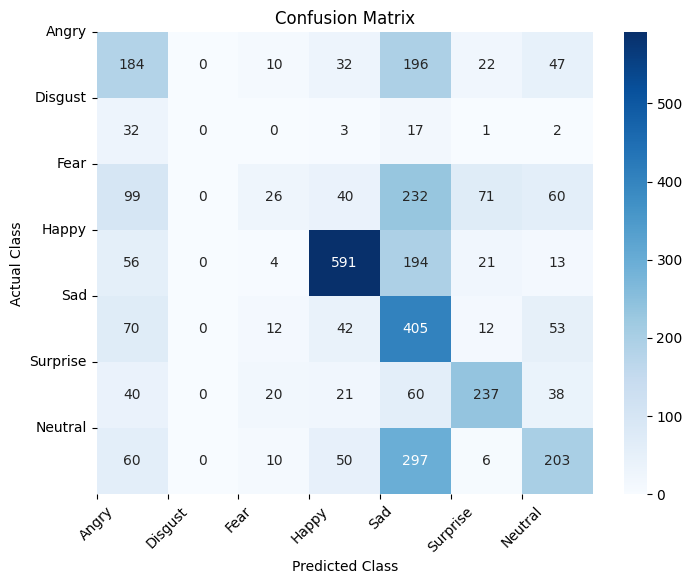

100%|██████████| 113/113 [00:01<00:00, 84.61it/s]


epoch:   2 | Train acc: 50.71 | Val acc: 50.21 | Train loss: 1.2959 | Val loss: 1.3089 | Confusion matrix: [[168   0  14  95 103   8  79]
 [ 22   0   0   7  19   0   8]
 [ 59   0  60  76 166  24 111]
 [ 17   0   7 734  50   7  80]
 [ 63   0  20 115 306   6 143]
 [ 30   0  35  50  34 209  57]
 [ 49   0  16  83 129   5 325]]
overwriting the best model!
epoch:   2 | Test acc: 50.57 | Test loss: 1.2956 | Test Confusion matrix: [[179   0  20  93 117   2  80]
 [ 25   0   3   4  14   0   9]
 [ 83   0  53  78 170  39 105]
 [ 20   0   7 740  71   2  39]
 [ 43   0  17  95 295   5 139]
 [ 31   0  45  58  37 188  57]
 [ 35   0   6  87 134   4 360]]


100%|██████████| 113/113 [00:01<00:00, 83.32it/s]


epoch:   3 | Train acc: 54.91 | Val acc: 55.22 | Train loss: 1.1950 | Val loss: 1.1955 | Confusion matrix: [[213   2  37  74  48  15  78]
 [ 23   7  12   4   4   0   6]
 [ 63   1 137  57 112  47  79]
 [ 25   1  23 763  24  12  47]
 [ 94   0  38  97 248   3 173]
 [ 22   0  53  35  14 267  24]
 [ 70   0  25  73  85   7 347]]
overwriting the best model!
epoch:   3 | Test acc: 55.08 | Test loss: 1.1787 | Test Confusion matrix: [[217   4  51  74  46  16  83]
 [ 22   9   9   6   8   1   0]
 [ 62   2 147  62 113  59  83]
 [ 21   0  15 750  39  20  34]
 [ 80   0  43  84 239   2 146]
 [ 17   0  57  37  12 261  32]
 [ 62   2  32  82  84  10 354]]


100%|██████████| 113/113 [00:01<00:00, 84.43it/s]


epoch:   4 | Train acc: 57.74 | Val acc: 56.03 | Train loss: 1.1257 | Val loss: 1.1609 | Confusion matrix: [[186   2  10  28 133  24  84]
 [ 14  12   1   2  20   0   7]
 [ 54   0  53  28 195  75  91]
 [ 26   0  10 688  66  31  74]
 [ 55   0  18  37 409  16 118]
 [ 12   0  25  17  23 313  25]
 [ 37   1   6  40 163  10 350]]
overwriting the best model!
epoch:   4 | Test acc: 56.03 | Test loss: 1.1455 | Test Confusion matrix: [[195   3  23  34 144  20  72]
 [ 19   9   2   6  14   3   2]
 [ 73   3  80  26 196  78  72]
 [ 32   0   9 689  86  23  40]
 [ 44   2  23  35 369   9 112]
 [ 12   0  21  15  33 311  24]
 [ 36   2  10  34 170  16 358]]


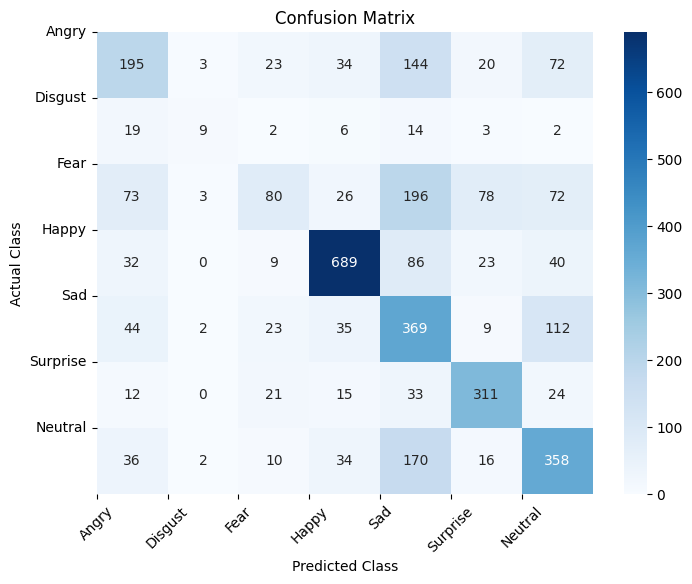

100%|██████████| 113/113 [00:01<00:00, 86.39it/s]


epoch:   5 | Train acc: 60.45 | Val acc: 56.12 | Train loss: 1.0591 | Val loss: 1.1644 | Confusion matrix: [[225   4  66  34  51  20  67]
 [ 15  14  12   3   5   0   7]
 [ 59   3 194  38  95  48  59]
 [ 40   0  34 710  36  22  53]
 [ 83   2 121  49 268  10 120]
 [ 14   0  56  29  11 293  12]
 [ 41   0  73  59 106  18 310]]
overwriting the best model!
epoch:   5 | Test acc: 58.12 | Test loss: 1.1002 | Test Confusion matrix: [[250   4  63  32  58  16  68]
 [ 19  12  14   2   6   1   1]
 [ 65   4 217  30  93  64  55]
 [ 41   1  21 736  36  14  30]
 [ 68   3 115  51 238  13 106]
 [ 13   0  72  24   9 279  19]
 [ 28   1  67  55  98  23 354]]


100%|██████████| 113/113 [00:01<00:00, 84.71it/s]


epoch:   6 | Train acc: 62.71 | Val acc: 56.09 | Train loss: 0.9958 | Val loss: 1.1623 | Confusion matrix: [[180   3  52  28 139  10  55]
 [  6  16   9   3  18   0   4]
 [ 40   1 142  30 196  44  43]
 [ 29   1  28 695  86  16  40]
 [ 44   1  64  30 431   9  74]
 [  9   0  42  21  27 296  20]
 [ 20   1  37  53 239   4 253]]


100%|██████████| 113/113 [00:01<00:00, 85.07it/s]


epoch:   7 | Train acc: 64.91 | Val acc: 58.96 | Train loss: 0.9367 | Val loss: 1.1242 | Confusion matrix: [[221  15  55  31  72   8  65]
 [ 14  24   5   4   3   0   6]
 [ 48   2 198  32 117  23  76]
 [ 28   1  15 750  39   8  54]
 [ 71   4  78  54 317   6 123]
 [ 12   1  62  34  12 271  23]
 [ 47   4  42  69 107   3 335]]
overwriting the best model!
epoch:   7 | Test acc: 58.71 | Test loss: 1.0988 | Test Confusion matrix: [[238  13  59  35  77   3  66]
 [ 15  24   5   3   7   0   1]
 [ 62   8 212  35 111  40  60]
 [ 17   3  24 743  46   9  37]
 [ 54   6  80  57 268   2 127]
 [ 10   5  77  39  13 247  25]
 [ 40   5  43  60  99   4 375]]


100%|██████████| 113/113 [00:01<00:00, 84.95it/s]


epoch:   8 | Train acc: 67.40 | Val acc: 57.95 | Train loss: 0.8789 | Val loss: 1.1765 | Confusion matrix: [[269   9  23  30  61   7  68]
 [ 20  20   2   4   5   0   5]
 [ 68   3 144  27 139  33  82]
 [ 41   0   9 728  38  15  64]
 [102   2  44  45 300   6 154]
 [ 22   3  60  24  15 257  34]
 [ 74   0  23  54  91   3 362]]


100%|██████████| 113/113 [00:01<00:00, 82.54it/s]


epoch:   9 | Train acc: 70.52 | Val acc: 58.07 | Train loss: 0.8052 | Val loss: 1.1947 | Confusion matrix: [[282   5  47  27  41  22  43]
 [ 18  26   2   2   5   0   3]
 [ 77   2 177  21  93  69  57]
 [ 48   4  30 687  17  41  68]
 [124   7  97  39 259  25 102]
 [  7   1  31   9  14 339  14]
 [ 86   0  69  33  84  21 314]]


100%|██████████| 113/113 [00:01<00:00, 84.39it/s]


epoch:  10 | Train acc: 73.27 | Val acc: 58.37 | Train loss: 0.7388 | Val loss: 1.2177 | Confusion matrix: [[195   8  53  38 109  20  44]
 [ 12  21   2   2  16   0   3]
 [ 35   4 181  37 146  52  41]
 [ 31   0  24 723  44  29  44]
 [ 49   1  86  42 370  22  83]
 [  7   2  39  18  14 323  12]
 [ 37   1  54  48 164  21 282]]


100%|██████████| 113/113 [00:01<00:00, 85.16it/s]


epoch:  11 | Train acc: 75.67 | Val acc: 59.88 | Train loss: 0.6626 | Val loss: 1.2199 | Confusion matrix: [[253   2  30  22  76  20  64]
 [ 19  24   2   0   5   0   6]
 [ 50   3 173  20 114  46  90]
 [ 39   0  12 705  43  16  80]
 [ 68   0  61  25 329  12 158]
 [ 10   1  34  22  15 299  34]
 [ 50   2  42  41  96  10 366]]
overwriting the best model!
epoch:  11 | Test acc: 60.49 | Test loss: 1.1751 | Test Confusion matrix: [[258   6  39  21  78  13  76]
 [ 10  28   2   2  11   0   2]
 [ 79   1 201  14  94  53  86]
 [ 46   2  24 679  44  17  67]
 [ 69   2  69  28 292   5 129]
 [ 13   0  44  23   8 300  28]
 [ 50   2  29  27  95  10 413]]


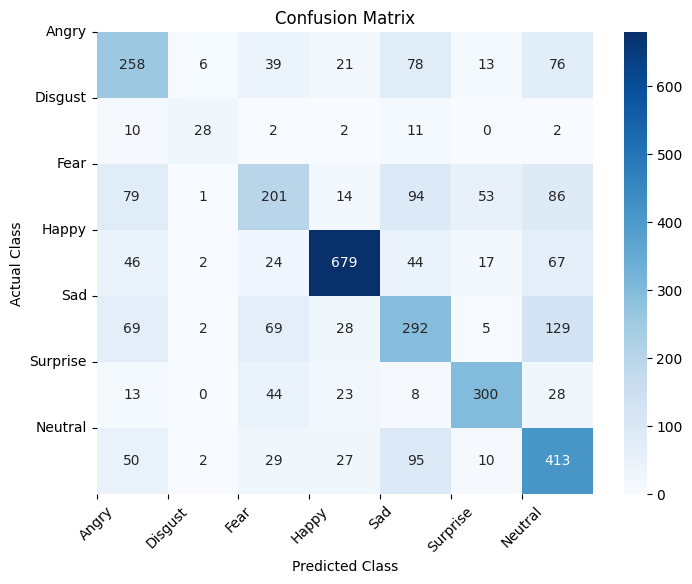

100%|██████████| 113/113 [00:01<00:00, 85.94it/s]


epoch:  12 | Train acc: 78.40 | Val acc: 58.76 | Train loss: 0.5959 | Val loss: 1.2740 | Confusion matrix: [[289   7  45  16  38  18  54]
 [ 22  24   2   1   2   0   5]
 [ 79   5 206  20  71  44  71]
 [ 46   0  27 684  29  30  79]
 [112   1 106  20 245  18 151]
 [ 14   1  56  12   8 310  14]
 [ 79   1  71  45  51   9 351]]


100%|██████████| 113/113 [00:01<00:00, 84.65it/s]


epoch:  13 | Train acc: 81.03 | Val acc: 59.46 | Train loss: 0.5332 | Val loss: 1.3106 | Confusion matrix: [[288   9  41  25  30  16  58]
 [ 17  25   7   1   2   0   4]
 [ 68   5 202  24  61  56  80]
 [ 43   2  21 712  19  21  77]
 [129   4  96  44 203  19 158]
 [  7   2  34  17   3 335  17]
 [ 71   2  55  45  50  15 369]]


100%|██████████| 113/113 [00:01<00:00, 86.77it/s]


epoch:  14 | Train acc: 83.28 | Val acc: 59.10 | Train loss: 0.4661 | Val loss: 1.3940 | Confusion matrix: [[297   3  36  16  39  24  52]
 [ 21  22   3   2   2   0   6]
 [ 75   1 179  26  80  61  74]
 [ 56   0  15 700  20  37  67]
 [137   0  81  29 253  20 133]
 [ 18   0  20  14   4 339  20]
 [ 67   1  58  48  80  22 331]]


100%|██████████| 113/113 [00:01<00:00, 84.72it/s]


epoch:  15 | Train acc: 85.30 | Val acc: 59.77 | Train loss: 0.4178 | Val loss: 1.4535 | Confusion matrix: [[246   9  53  23  70  16  50]
 [ 14  26   6   1   7   0   2]
 [ 47   5 213  18 112  46  55]
 [ 37   0  29 692  43  24  70]
 [ 88   1  73  36 316  28 111]
 [  7   0  31  15  12 337  13]
 [ 61   4  60  40 105  22 315]]


100%|██████████| 113/113 [00:01<00:00, 79.10it/s]


epoch:  16 | Train acc: 87.15 | Val acc: 60.27 | Train loss: 0.3672 | Val loss: 1.4620 | Confusion matrix: [[244   7  54  37  53  13  59]
 [ 10  30   6   3   4   0   3]
 [ 40   5 221  34  98  31  67]
 [ 23   3  27 731  30  12  69]
 [ 82   7  75  43 286  12 148]
 [ 11   1  47  25  12 295  24]
 [ 42   1  42  56 101   9 356]]
overwriting the best model!
epoch:  16 | Test acc: 60.18 | Test loss: 1.4581 | Test Confusion matrix: [[242  16  69  33  60   7  64]
 [ 11  33   4   3   3   0   1]
 [ 65   8 231  22  86  41  75]
 [ 30   1  25 720  32  16  55]
 [ 63   8  81  45 263   3 131]
 [ 10   3  61  26   9 291  16]
 [ 45   5  41  51  91  13 380]]


100%|██████████| 113/113 [00:01<00:00, 81.02it/s]


epoch:  17 | Train acc: 88.65 | Val acc: 59.82 | Train loss: 0.3230 | Val loss: 1.6081 | Confusion matrix: [[232   6  47  24  89  16  53]
 [ 10  28   5   1   8   0   4]
 [ 43   1 183  24 139  45  61]
 [ 22   0  20 721  46  19  67]
 [ 58   2  68  38 348  20 119]
 [ 12   1  28  23  17 318  16]
 [ 50   0  45  47 139   9 317]]


100%|██████████| 113/113 [00:01<00:00, 86.66it/s]


epoch:  18 | Train acc: 89.98 | Val acc: 59.15 | Train loss: 0.2895 | Val loss: 1.6341 | Confusion matrix: [[233   4  43  32  84   7  64]
 [ 14  24   6   1   7   0   4]
 [ 46   2 190  34 136  32  56]
 [ 27   1  23 727  48  13  56]
 [ 65   2  67  45 359   6 109]
 [ 15   2  53  24  13 283  25]
 [ 45   1  40  58 150   6 307]]


100%|██████████| 113/113 [00:01<00:00, 86.39it/s]


epoch:  19 | Train acc: 90.77 | Val acc: 59.43 | Train loss: 0.2658 | Val loss: 1.7377 | Confusion matrix: [[284   6  46  16  60  16  39]
 [ 17  25   7   2   1   0   4]
 [ 55   2 216  16 107  41  59]
 [ 44   0  35 686  35  27  68]
 [111   1  94  29 290  22 106]
 [  9   0  49  13   9 318  17]
 [ 83   0  64  36 103   7 314]]


100%|██████████| 113/113 [00:01<00:00, 86.43it/s]


epoch:  20 | Train acc: 91.44 | Val acc: 58.74 | Train loss: 0.2447 | Val loss: 1.9312 | Confusion matrix: [[217  10  51  50  64  21  54]
 [ 13  28   5   2   4   1   3]
 [ 38   2 215  51  85  47  58]
 [ 15   1  21 750  20  23  65]
 [ 72   1  90  75 284  16 115]
 [  9   1  49  21   3 313  19]
 [ 47   1  56  72 111  19 301]]


100%|██████████| 113/113 [00:01<00:00, 86.22it/s]


epoch:  21 | Train acc: 92.30 | Val acc: 60.07 | Train loss: 0.2253 | Val loss: 1.8293 | Confusion matrix: [[255   6  28  31  88  11  48]
 [ 15  28   4   2   6   0   1]
 [ 53   5 200  23 115  41  59]
 [ 30   0  20 690  54  36  65]
 [ 84   1  60  39 358  12  99]
 [ 12   1  35  21  13 320  13]
 [ 53   2  56  56 121  14 305]]


100%|██████████| 113/113 [00:01<00:00, 82.72it/s]


epoch:  22 | Train acc: 93.15 | Val acc: 59.77 | Train loss: 0.2027 | Val loss: 1.8961 | Confusion matrix: [[247   1  54  36  75   7  47]
 [ 16  24   3   2   9   0   2]
 [ 41   2 208  31 111  35  68]
 [ 26   1  17 748  36  14  53]
 [ 74   1  74  59 330  10 105]
 [ 19   0  39  23  14 295  25]
 [ 54   2  55  68 132   3 293]]


100%|██████████| 113/113 [00:01<00:00, 84.36it/s]


epoch:  23 | Train acc: 96.95 | Val acc: 60.99 | Train loss: 0.0992 | Val loss: 1.9374 | Confusion matrix: [[265   1  49  27  68  10  47]
 [ 16  26   5   0   7   0   2]
 [ 47   3 217  22 113  36  58]
 [ 30   0  22 723  38  16  66]
 [ 89   0  70  40 329  10 115]
 [ 18   0  33  18  13 314  19]
 [ 59   1  54  42 129   7 315]]
overwriting the best model!
epoch:  23 | Test acc: 61.83 | Test loss: 1.8259 | Test Confusion matrix: [[271   6  62  23  68   8  53]
 [ 12  29   6   1   6   0   1]
 [ 73   2 252  17  94  39  51]
 [ 38   0  23 709  41  18  50]
 [ 71   3  87  42 296   7  88]
 [ 12   1  38  17   8 321  19]
 [ 60   2  50  55 107  11 341]]


100%|██████████| 113/113 [00:01<00:00, 86.28it/s]


epoch:  24 | Train acc: 98.43 | Val acc: 60.94 | Train loss: 0.0560 | Val loss: 2.1273 | Confusion matrix: [[257   4  44  35  68  11  48]
 [ 11  30   5   0   8   0   2]
 [ 38   3 219  23 109  37  67]
 [ 19   1  18 742  36  16  63]
 [ 88   2  81  53 308  14 107]
 [ 15   0  37  20  10 311  22]
 [ 54   2  52  58 113   8 320]]


100%|██████████| 113/113 [00:01<00:00, 86.24it/s]


epoch:  25 | Train acc: 98.82 | Val acc: 60.77 | Train loss: 0.0419 | Val loss: 2.3017 | Confusion matrix: [[261   2  41  28  71   7  57]
 [ 18  25   5   0   7   0   1]
 [ 41   4 223  18 108  36  66]
 [ 30   0  26 717  37  16  69]
 [ 88   0  75  38 325  11 116]
 [ 18   0  38  16  12 309  22]
 [ 59   0  59  41 119   8 321]]


100%|██████████| 113/113 [00:01<00:00, 84.35it/s]


epoch:  26 | Train acc: 99.09 | Val acc: 61.41 | Train loss: 0.0337 | Val loss: 2.3844 | Confusion matrix: [[262   3  39  32  66  10  55]
 [ 16  29   2   0   6   0   3]
 [ 40   4 217  21 101  37  76]
 [ 26   1  17 730  35  19  67]
 [ 91   1  72  42 319  15 113]
 [ 13   0  31  19  10 322  20]
 [ 52   0  51  43 127   9 325]]
overwriting the best model!
epoch:  26 | Test acc: 61.88 | Test loss: 2.2215 | Test Confusion matrix: [[266   5  50  31  73  12  54]
 [ 11  30   2   0   9   1   2]
 [ 75   3 246  18  82  43  61]
 [ 30   0  22 718  41  19  49]
 [ 72   4  88  45 273   4 108]
 [ 15   2  39  14   7 322  17]
 [ 50   1  49  59  89  12 366]]


100%|██████████| 113/113 [00:01<00:00, 85.16it/s]


epoch:  27 | Train acc: 99.31 | Val acc: 61.33 | Train loss: 0.0276 | Val loss: 2.4569 | Confusion matrix: [[258   5  43  35  62  10  54]
 [ 14  31   3   1   4   0   3]
 [ 39   5 219  27  94  42  70]
 [ 21   3  18 739  31  16  67]
 [ 81   2  72  51 311  15 121]
 [ 16   0  39  19   7 313  21]
 [ 41   1  49  52 124  10 330]]


100%|██████████| 113/113 [00:01<00:00, 82.75it/s]


epoch:  28 | Train acc: 99.39 | Val acc: 60.94 | Train loss: 0.0259 | Val loss: 2.5246 | Confusion matrix: [[249   1  50  29  65  12  61]
 [ 16  29   4   0   5   0   2]
 [ 33   4 221  18 104  37  79]
 [ 29   0  20 713  31  16  86]
 [ 78   0  70  37 313  12 143]
 [ 13   0  40  17   8 318  19]
 [ 53   0  46  39 117   8 344]]


100%|██████████| 113/113 [00:01<00:00, 84.41it/s]


epoch:  29 | Train acc: 99.46 | Val acc: 60.63 | Train loss: 0.0231 | Val loss: 2.6449 | Confusion matrix: [[263   4  48  35  60   8  49]
 [ 15  30   3   0   7   0   1]
 [ 45   4 215  32 105  39  56]
 [ 26   2  20 736  30  14  67]
 [ 83   3  73  59 312  11 112]
 [ 17   0  34  20  11 312  21]
 [ 61   0  47  57 122  12 308]]


100%|██████████| 113/113 [00:01<00:00, 77.54it/s]


epoch:  30 | Train acc: 99.39 | Val acc: 60.88 | Train loss: 0.0237 | Val loss: 2.5741 | Confusion matrix: [[231   4  59  36  78   9  50]
 [ 12  31   4   0   7   0   2]
 [ 39   5 227  23 108  32  62]
 [ 21   1  20 740  36  16  61]
 [ 72   2  81  50 335   9 104]
 [ 13   0  43  19  13 306  21]
 [ 47   0  61  49 129   6 315]]


100%|██████████| 113/113 [00:01<00:00, 85.27it/s]


epoch:  31 | Train acc: 99.52 | Val acc: 60.63 | Train loss: 0.0186 | Val loss: 2.6540 | Confusion matrix: [[248   4  57  29  72  10  47]
 [ 16  27   4   1   6   0   2]
 [ 42   4 220  23 101  40  66]
 [ 25   0  21 729  33  14  73]
 [ 80   0  84  44 323  15 107]
 [ 14   0  34  21  12 317  17]
 [ 54   0  57  45 127  12 312]]


100%|██████████| 113/113 [00:01<00:00, 86.40it/s]


epoch:  32 | Train acc: 99.52 | Val acc: 60.10 | Train loss: 0.0195 | Val loss: 2.7789 | Confusion matrix: [[240   1  58  27  70  12  59]
 [ 13  28   6   1   6   0   2]
 [ 32   2 227  22 102  41  70]
 [ 22   0  28 718  35  17  75]
 [ 68   0  91  45 308  10 131]
 [  8   0  42  18  13 317  17]
 [ 45   0  65  47 123   8 319]]


100%|██████████| 113/113 [00:01<00:00, 85.11it/s]


epoch:  33 | Train acc: 99.58 | Val acc: 60.88 | Train loss: 0.0158 | Val loss: 2.7302 | Confusion matrix: [[259   3  51  29  68   9  48]
 [ 16  28   5   1   5   0   1]
 [ 46   4 224  21  97  38  66]
 [ 24   0  19 730  37  13  72]
 [ 84   0  86  44 310  13 116]
 [ 12   0  43  17  12 314  17]
 [ 54   0  57  46 124   6 320]]


100%|██████████| 113/113 [00:01<00:00, 84.72it/s]


epoch:  34 | Train acc: 99.69 | Val acc: 60.77 | Train loss: 0.0117 | Val loss: 2.7338 | Confusion matrix: [[255   2  44  29  77  10  50]
 [ 16  27   4   1   6   0   2]
 [ 48   4 213  20 108  41  62]
 [ 33   0  22 710  39  15  76]
 [ 83   0  66  39 346  12 107]
 [ 13   0  40  16  13 317  16]
 [ 57   0  46  43 140   8 313]]


100%|██████████| 113/113 [00:01<00:00, 84.70it/s]


epoch:  35 | Train acc: 99.72 | Val acc: 60.69 | Train loss: 0.0087 | Val loss: 2.7870 | Confusion matrix: [[251   4  49  31  66  11  55]
 [ 14  28   5   1   6   0   2]
 [ 46   5 215  24  95  40  71]
 [ 23   1  21 728  34  16  72]
 [ 81   1  70  45 318  16 122]
 [ 12   0  40  17  11 318  17]
 [ 50   1  54  48 124  10 320]]


100%|██████████| 113/113 [00:01<00:00, 83.39it/s]


epoch:  36 | Train acc: 99.70 | Val acc: 60.99 | Train loss: 0.0085 | Val loss: 2.8113 | Confusion matrix: [[259   3  51  29  63   8  54]
 [ 15  27   5   1   6   0   2]
 [ 42   2 227  26  89  40  70]
 [ 23   0  21 733  32  14  72]
 [ 86   0  87  48 303  14 115]
 [ 11   0  43  17  10 319  15]
 [ 57   0  59  47 115   8 321]]


100%|██████████| 113/113 [00:01<00:00, 85.15it/s]


epoch:  37 | Train acc: 99.72 | Val acc: 60.99 | Train loss: 0.0078 | Val loss: 2.8939 | Confusion matrix: [[255   3  42  32  67   9  59]
 [ 13  30   5   1   5   0   2]
 [ 51   5 212  26  92  41  69]
 [ 23   1  18 740  31  14  68]
 [ 80   1  73  53 304  13 129]
 [ 15   0  33  18  11 319  19]
 [ 54   1  49  48 116  10 329]]


100%|██████████| 113/113 [00:01<00:00, 85.78it/s]


epoch:  38 | Train acc: 99.73 | Val acc: 60.80 | Train loss: 0.0078 | Val loss: 2.9099 | Confusion matrix: [[259   4  48  28  72  10  46]
 [ 15  28   4   1   6   0   2]
 [ 45   6 217  19 102  41  66]
 [ 29   0  23 721  37  15  70]
 [ 82   1  75  45 327  17 106]
 [ 12   0  44  15  11 318  15]
 [ 53   1  53  48 129  11 312]]


100%|██████████| 113/113 [00:01<00:00, 87.15it/s]


epoch:  39 | Train acc: 99.80 | Val acc: 61.02 | Train loss: 0.0058 | Val loss: 2.8947 | Confusion matrix: [[250   3  52  29  68   9  56]
 [ 14  28   5   1   6   0   2]
 [ 40   5 226  22  98  37  68]
 [ 22   1  21 731  33  14  73]
 [ 79   1  81  46 311  12 123]
 [ 11   0  48  17  10 314  15]
 [ 43   1  55  51 120   7 330]]


100%|██████████| 113/113 [00:01<00:00, 84.83it/s]


epoch:  40 | Train acc: 99.77 | Val acc: 60.77 | Train loss: 0.0061 | Val loss: 2.9004 | Confusion matrix: [[267   3  47  29  63   7  51]
 [ 16  27   4   1   6   0   2]
 [ 52   5 218  21  95  38  67]
 [ 29   0  19 729  33  14  71]
 [ 91   1  81  47 309  15 109]
 [ 17   0  42  16  10 315  15]
 [ 56   2  54  49 119  11 316]]


100%|██████████| 113/113 [00:01<00:00, 80.48it/s]


epoch:  41 | Train acc: 99.79 | Val acc: 60.99 | Train loss: 0.0060 | Val loss: 2.8911 | Confusion matrix: [[259   3  46  31  68   5  55]
 [ 16  27   4   1   6   0   2]
 [ 45   3 219  21  99  39  70]
 [ 27   0  21 733  32  14  68]
 [ 82   0  80  49 316  13 113]
 [ 15   0  43  17  11 314  15]
 [ 48   1  54  50 124   9 321]]
epoch:  41 | Test acc: 62.39 | Test loss: 2.6681 | Test Confusion matrix: [[273   6  61  25  69   9  48]
 [  9  31   4   2   6   1   2]
 [ 73   3 256  18  84  40  54]
 [ 26   1  22 729  40  16  45]
 [ 67   3  94  48 277   5 100]
 [ 10   2  48  18   7 316  15]
 [ 42   2  51  57 103  14 357]]
Early stopping at epoch 41
epoch:  41 | Test acc: 62.39 | Test loss: 2.6681 | Test Confusion matrix: [[273   6  61  25  69   9  48]
 [  9  31   4   2   6   1   2]
 [ 73   3 256  18  84  40  54]
 [ 26   1  22 729  40  16  45]
 [ 67   3  94  48 277   5 100]
 [ 10   2  48  18   7 316  15]
 [ 42   2  51  57 103  14 357]]


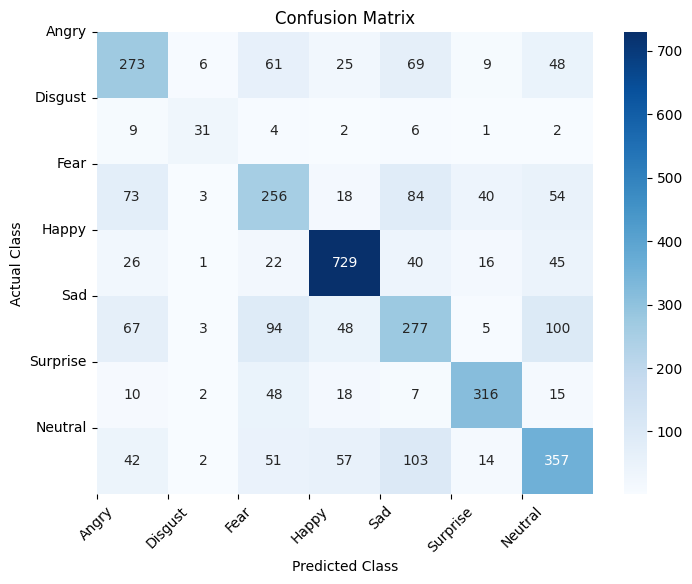

wandb: Agent Starting Run: ycijoyyj with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.001
wandb: 	weight_decay: 0.01


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudn

epoch:   1 | Train acc: 36.07 | Val acc: 34.38 | Train loss: 1.6301 | Val loss: 1.6487 | Confusion matrix: [[  0   0   2  68   0  11 386]
 [  0   0   0   5   0   1  50]
 [  0   0   5  32   0  29 430]
 [  0   0   2 502   2   7 382]
 [  0   0   2  38   0   7 606]
 [  0   0   8  45   0 161 201]
 [  0   0   1  38   0   2 566]]
overwriting the best model!
epoch:   1 | Test acc: 34.13 | Test loss: 1.6684 | Test Confusion matrix: [[  0   0   1  58   0   8 424]
 [  0   0   0  10   0   1  44]
 [  0   0   6  58   1  39 424]
 [  0   0   0 497   1   2 379]
 [  0   0   1  30   1   4 558]
 [  0   0   5  39   0 136 236]
 [  0   0   1  30   0  10 585]]


100%|██████████| 113/113 [00:01<00:00, 87.85it/s]


epoch:   2 | Train acc: 39.64 | Val acc: 40.65 | Train loss: 1.5524 | Val loss: 1.5546 | Confusion matrix: [[  0   0  20 135 256  18  38]
 [  0   0   2   7  43   1   3]
 [  0   0  40 114 244  62  36]
 [  0   0  20 647 182  20  26]
 [  0   0  32 142 402  20  57]
 [  0   0  21  87  63 225  19]
 [  0   0  22  96 313  31 145]]
overwriting the best model!
epoch:   2 | Test acc: 38.53 | Test loss: 1.5733 | Test Confusion matrix: [[  0   0  17 138 263  23  50]
 [  0   0   0  13  32   3   7]
 [  0   0  31 124 251  74  48]
 [  0   0  14 627 209  11  18]
 [  0   0  28 134 362  12  58]
 [  0   0  37  83  67 216  13]
 [  0   0  33  94 316  36 147]]


100%|██████████| 113/113 [00:01<00:00, 85.16it/s]


epoch:   3 | Train acc: 41.77 | Val acc: 43.61 | Train loss: 1.4951 | Val loss: 1.4359 | Confusion matrix: [[  0   0  26 103 126  17 195]
 [  0   0   2   7  23   0  24]
 [  0   0  35  62 124  61 214]
 [  0   0  19 706  54  21  95]
 [  0   0  16 124 177   5 331]
 [  0   0  34  35  30 242  74]
 [  0   0  12  88  97   5 405]]
overwriting the best model!
epoch:   3 | Test acc: 43.72 | Test loss: 1.4270 | Test Confusion matrix: [[  0   0  28 108 132  18 205]
 [  0   0   1   8  24   1  21]
 [  0   0  33  81 141  68 205]
 [  0   0  20 707  70  14  68]
 [  0   0  23 131 146   3 291]
 [  0   0  45  38  28 224  81]
 [  0   0  14  94  55   4 459]]


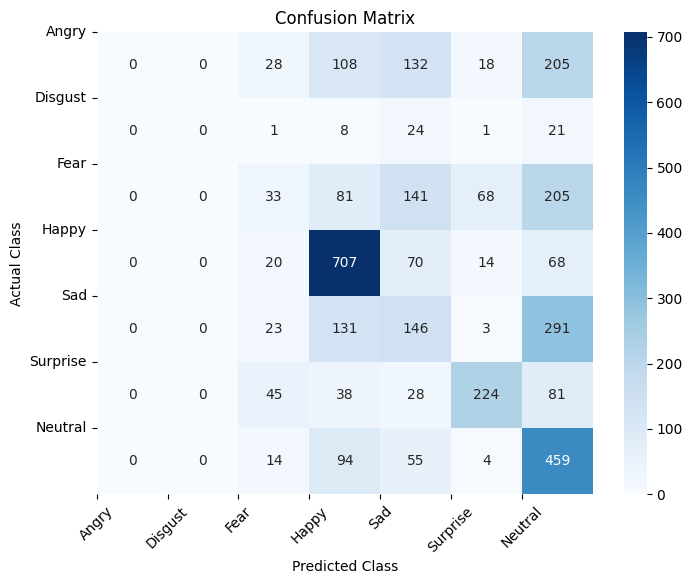

100%|██████████| 113/113 [00:01<00:00, 87.21it/s]


epoch:   4 | Train acc: 44.40 | Val acc: 44.00 | Train loss: 1.4324 | Val loss: 1.4529 | Confusion matrix: [[ 83   0  72  47  94  60 111]
 [ 13   0   4   4  10   7  18]
 [ 54   0  55  42  78 141 126]
 [ 29   0  39 609  51  90  77]
 [107   0  66  72 172  51 185]
 [  6   0  20  21   5 342  21]
 [ 43   0  30  65 112  39 318]]
overwriting the best model!
epoch:   4 | Test acc: 45.11 | Test loss: 1.4355 | Test Confusion matrix: [[ 90   0  72  52  90  67 120]
 [ 17   0   2   4  13   4  15]
 [ 50   0  80  57  67 143 131]
 [ 36   0  30 615  62  94  42]
 [103   0  67  73 145  41 165]
 [ 10   0  29  18   5 329  25]
 [ 36   0  29  53  93  55 360]]


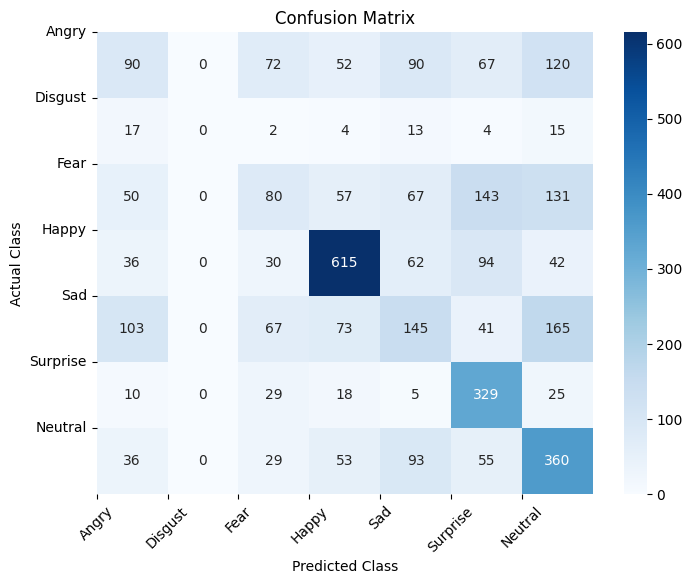

100%|██████████| 113/113 [00:01<00:00, 84.16it/s]


epoch:   5 | Train acc: 45.73 | Val acc: 46.06 | Train loss: 1.3965 | Val loss: 1.3760 | Confusion matrix: [[ 17   0  41 101 204  22  82]
 [  4   0   3   9  33   1   6]
 [ 12   0  46  77 154  76 131]
 [  6   0  14 721  53  21  80]
 [  3   0  35 121 282  18 194]
 [  1   0  29  33  21 278  53]
 [  4   0  17 103 160  14 309]]
overwriting the best model!
epoch:   5 | Test acc: 47.76 | Test loss: 1.3732 | Test Confusion matrix: [[ 15   0  42  97 226  25  86]
 [  3   0   1   8  35   2   6]
 [ 14   0  64  93 162  75 120]
 [  2   0  25 736  54  24  38]
 [  5   0  32 121 283  18 135]
 [  4   0  36  39  25 262  50]
 [  1   0  14 100 146  11 354]]


100%|██████████| 113/113 [00:01<00:00, 85.34it/s]


epoch:   6 | Train acc: 46.96 | Val acc: 46.53 | Train loss: 1.3729 | Val loss: 1.3530 | Confusion matrix: [[125   0  39  44 129  23 107]
 [ 17   0   2   6  20   1  10]
 [ 72   0  47  46  99  84 148]
 [ 43   0  17 680  52  20  83]
 [ 95   0  39  86 177  14 242]
 [  9   0  31  24   7 287  57]
 [ 40   0  16  74 115   8 354]]
overwriting the best model!
epoch:   6 | Test acc: 47.09 | Test loss: 1.3383 | Test Confusion matrix: [[123   0  45  57 137  20 109]
 [ 21   0   4   3  19   2   6]
 [ 93   0  43  55 106  79 152]
 [ 41   0  24 687  55  10  62]
 [ 94   0  30  61 188  11 210]
 [ 14   0  40  37   7 268  50]
 [ 21   0  21  74 116  13 381]]


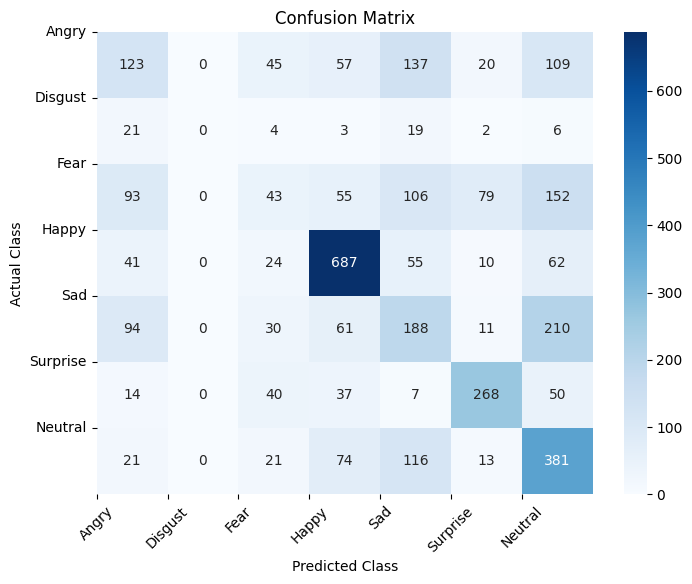

100%|██████████| 113/113 [00:01<00:00, 86.16it/s]


epoch:   7 | Train acc: 47.79 | Val acc: 47.53 | Train loss: 1.3582 | Val loss: 1.3716 | Confusion matrix: [[ 94   0  46  34 113  27 153]
 [ 13   0   2   5  15   2  19]
 [ 52   0  55  40  68  84 197]
 [ 18   0  18 658  48  38 115]
 [ 47   0  40  66 193  20 287]
 [  7   0  35  22   6 288  57]
 [ 18   0  21  39 101  10 418]]
overwriting the best model!
epoch:   7 | Test acc: 48.17 | Test loss: 1.3537 | Test Confusion matrix: [[ 97   0  51  40 114  31 158]
 [ 16   0   3   6  17   2  11]
 [ 57   0  64  47  76  80 204]
 [ 23   0  28 666  39  31  92]
 [ 61   0  28  51 168  16 270]
 [ 11   0  43  18   8 278  58]
 [ 21   0   8  47  78  16 456]]


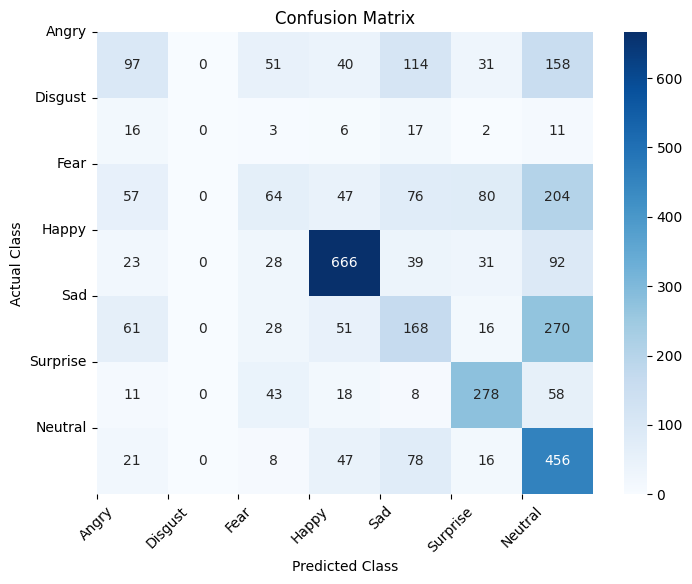

100%|██████████| 113/113 [00:01<00:00, 85.21it/s]


epoch:   8 | Train acc: 48.11 | Val acc: 47.59 | Train loss: 1.3452 | Val loss: 1.3526 | Confusion matrix: [[130   0  19  60 127  32  99]
 [ 17   0   6   7  17   0   9]
 [ 67   0  29  65  78 115 142]
 [ 31   0   5 704  50  18  87]
 [ 77   0  11  94 188  34 249]
 [ 17   0  12  50   2 309  25]
 [ 35   0  16  72 111  25 348]]
overwriting the best model!
epoch:   8 | Test acc: 48.40 | Test loss: 1.3351 | Test Confusion matrix: [[136   0  20  63 133  30 109]
 [ 24   0   1   5  16   3   6]
 [ 89   0  32  77  86 117 127]
 [ 38   0   5 719  48  16  53]
 [ 68   0  17  97 175  28 209]
 [ 19   0  15  54   5 292  31]
 [ 28   0  17  76  88  34 383]]


100%|██████████| 113/113 [00:01<00:00, 83.47it/s]


epoch:   9 | Train acc: 48.38 | Val acc: 46.42 | Train loss: 1.3360 | Val loss: 1.3607 | Confusion matrix: [[ 89   0  17  82 126  18 135]
 [ 18   0   5   8  18   0   7]
 [ 45   0  30 102  97  55 167]
 [ 17   0   6 774  28  17  53]
 [ 42   0  17 167 180   9 238]
 [  9   0  35  52   8 244  67]
 [ 15   0  10 131  98   4 349]]


100%|██████████| 113/113 [00:01<00:00, 85.82it/s]


epoch:  10 | Train acc: 49.00 | Val acc: 47.00 | Train loss: 1.3291 | Val loss: 1.3618 | Confusion matrix: [[148   0   9  73  86   8 143]
 [ 22   0   3   7  12   0  12]
 [ 87   0  32  53  78  46 200]
 [ 31   0   5 704  36  17 102]
 [ 72   0  12  94 159   5 311]
 [ 37   0  34  43  10 227  64]
 [ 33   0   8  55  85   9 417]]


100%|██████████| 113/113 [00:01<00:00, 87.28it/s]


epoch:  11 | Train acc: 49.86 | Val acc: 49.85 | Train loss: 1.3178 | Val loss: 1.3065 | Confusion matrix: [[127   0   9  85 152  19  75]
 [ 19   0   1   9  24   0   3]
 [ 66   0  32  61 152  61 124]
 [ 16   0   4 732  40  22  81]
 [ 59   0  14 102 291  11 176]
 [ 14   0  29  31  14 274  53]
 [ 17   0   6  68 177   6 333]]
overwriting the best model!
epoch:  11 | Test acc: 50.35 | Test loss: 1.2999 | Test Confusion matrix: [[139   0  17  70 177  17  71]
 [ 28   0   1  13  11   2   0]
 [ 80   0  28  78 151  73 118]
 [ 30   0  10 744  40  14  41]
 [ 40   0  12  89 283  10 160]
 [ 18   0  26  43  19 261  49]
 [ 17   0   6  66 175  10 352]]


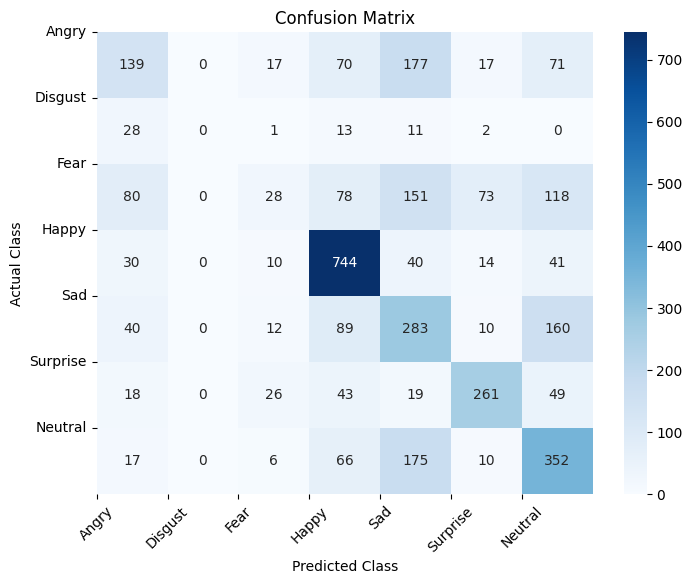

100%|██████████| 113/113 [00:01<00:00, 85.77it/s]


epoch:  12 | Train acc: 49.65 | Val acc: 48.82 | Train loss: 1.3144 | Val loss: 1.3275 | Confusion matrix: [[140   0  43  62 102  29  91]
 [ 21   0   5   7  17   1   5]
 [ 64   0  56  66  94 110 106]
 [ 16   0  14 715  36  51  63]
 [ 61   0  44 102 206  32 208]
 [ 12   0  28  27  11 312  25]
 [ 32   0  28  77 108  39 323]]


100%|██████████| 113/113 [00:01<00:00, 87.62it/s]


epoch:  13 | Train acc: 49.96 | Val acc: 47.87 | Train loss: 1.3119 | Val loss: 1.3172 | Confusion matrix: [[171   0  30  72  85  20  89]
 [ 31   0   3   6   9   0   7]
 [ 91   0  64  77  73  74 117]
 [ 25   0  14 738  26  27  65]
 [125   0  36 122 151   9 210]
 [ 21   0  56  38   3 274  23]
 [ 59   0  32 105  80  11 320]]


100%|██████████| 113/113 [00:01<00:00, 86.23it/s]


epoch:  14 | Train acc: 49.84 | Val acc: 49.76 | Train loss: 1.3066 | Val loss: 1.3193 | Confusion matrix: [[ 95   0   7  83 165  23  94]
 [ 15   0   0   8  25   1   7]
 [ 33   0  26  69 156  87 125]
 [  5   0   5 709  76  35  65]
 [ 28   0   9  88 326  15 187]
 [ 11   0  25  33  17 287  42]
 [ 11   0   5  57 176  15 343]]


100%|██████████| 113/113 [00:01<00:00, 84.00it/s]


epoch:  15 | Train acc: 50.84 | Val acc: 50.32 | Train loss: 1.2967 | Val loss: 1.3099 | Confusion matrix: [[116   0  20  67 134  36  94]
 [ 15   0   3  11  17   3   7]
 [ 40   0  35  63 117 138 103]
 [ 13   0   7 737  40  43  55]
 [ 43   0  23  96 262  50 179]
 [  4   0  17  30   7 339  18]
 [ 17   0  16  70 140  47 317]]
overwriting the best model!
epoch:  15 | Test acc: 50.10 | Test loss: 1.2901 | Test Confusion matrix: [[113   0  34  70 141  54  79]
 [ 24   0   2  10  14   3   2]
 [ 46   0  39  81 109 143 110]
 [ 15   0  12 740  45  34  33]
 [ 45   0  25  90 245  35 154]
 [  6   0  26  37   6 318  23]
 [ 16   0  20  75 124  48 343]]


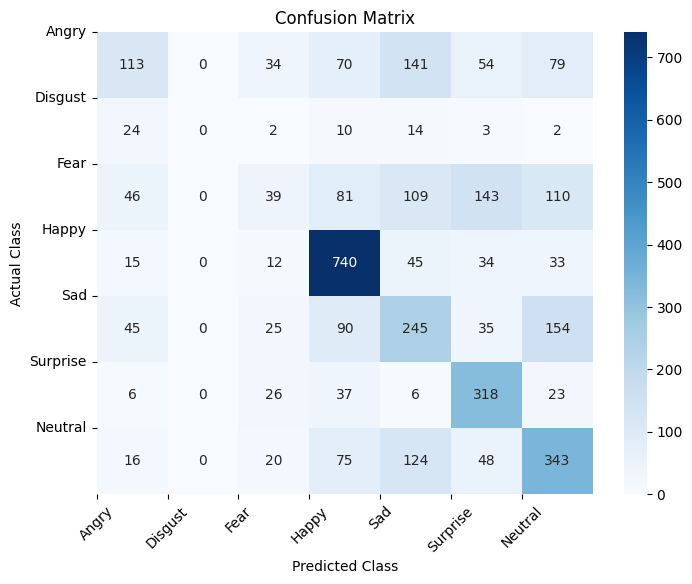

100%|██████████| 113/113 [00:01<00:00, 88.72it/s]


epoch:  16 | Train acc: 50.77 | Val acc: 49.18 | Train loss: 1.2991 | Val loss: 1.3209 | Confusion matrix: [[133   0  32  83  98  29  92]
 [ 19   0   5  13  10   4   5]
 [ 50   0  57  70  95 101 123]
 [ 17   0  15 737  33  41  52]
 [ 60   0  61 116 212  27 177]
 [ 12   0  34  27  13 303  26]
 [ 16   0  38  91 119  20 323]]


100%|██████████| 113/113 [00:01<00:00, 87.89it/s]


epoch:  17 | Train acc: 51.09 | Val acc: 49.76 | Train loss: 1.2870 | Val loss: 1.3100 | Confusion matrix: [[196   0  13  59 146   2  51]
 [ 31   0   0   2  19   0   4]
 [110   0  46  43 188  39  70]
 [ 31   0   4 703  83  15  59]
 [ 89   0  12  57 341   6 148]
 [ 40   0  40  40  27 223  45]
 [ 49   0  10  53 215   3 277]]


100%|██████████| 113/113 [00:01<00:00, 85.50it/s]


epoch:  18 | Train acc: 51.57 | Val acc: 51.69 | Train loss: 1.2829 | Val loss: 1.2670 | Confusion matrix: [[154   0  42  60 127  16  68]
 [ 26   0   3   7  12   1   7]
 [ 61   0  90  53 132  75  85]
 [ 19   0  19 722  50  29  56]
 [ 62   0  57  86 298  12 138]
 [ 10   0  58  26  11 292  18]
 [ 29   0  47  80 144   8 299]]
overwriting the best model!
epoch:  18 | Test acc: 50.68 | Test loss: 1.2648 | Test Confusion matrix: [[151   0  57  63 143  16  61]
 [ 30   0   4   6   8   2   5]
 [ 74   0  78  64 143  94  75]
 [ 24   0  22 729  54  14  36]
 [ 56   0  52  95 263  11 117]
 [ 10   0  50  32  14 284  26]
 [ 34   0  41  72 151  14 314]]


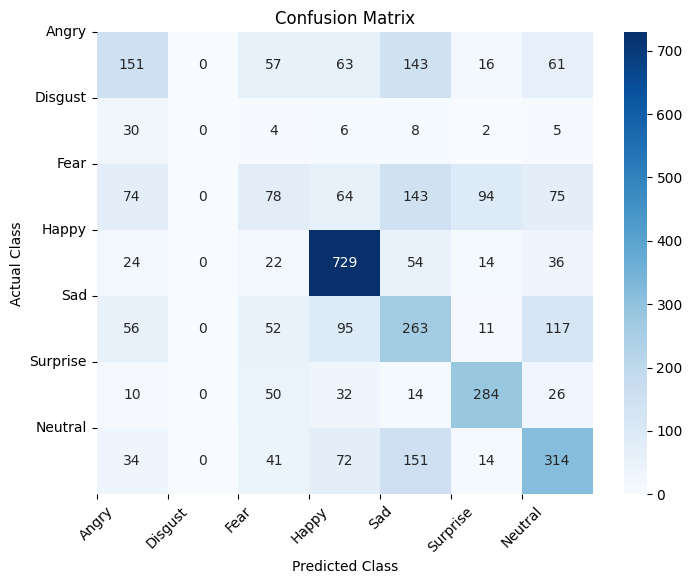

100%|██████████| 113/113 [00:01<00:00, 84.97it/s]


epoch:  19 | Train acc: 51.80 | Val acc: 51.30 | Train loss: 1.2811 | Val loss: 1.2733 | Confusion matrix: [[226   0  10  49  77  15  90]
 [ 34   0   0   6   7   1   8]
 [100   0  39  44 122  63 128]
 [ 47   0   7 713  42  22  64]
 [124   0  12  75 247  13 182]
 [ 26   0  37  31  11 279  31]
 [ 76   0  11  79  99   5 337]]


100%|██████████| 113/113 [00:01<00:00, 73.10it/s]


epoch:  20 | Train acc: 51.63 | Val acc: 49.07 | Train loss: 1.2796 | Val loss: 1.3040 | Confusion matrix: [[180   0  45  77 141   8  16]
 [ 31   0   3   9  12   0   1]
 [ 84   0 105  61 178  44  24]
 [ 21   0  24 752  71  11  16]
 [ 98   0  67  91 353   5  39]
 [ 17   0 110  36  14 237   1]
 [ 61   0  56  92 263   1 134]]


100%|██████████| 113/113 [00:01<00:00, 87.25it/s]


epoch:  21 | Train acc: 52.00 | Val acc: 50.68 | Train loss: 1.2719 | Val loss: 1.2900 | Confusion matrix: [[219   0  17  43 143  15  30]
 [ 35   0   1   4  14   1   1]
 [106   0  62  35 199  53  41]
 [ 50   0  15 690  83  29  28]
 [112   0  26  53 409   5  48]
 [ 19   0  74  17  34 266   5]
 [ 90   0  27  59 247  11 173]]


100%|██████████| 113/113 [00:01<00:00, 85.83it/s]


epoch:  22 | Train acc: 51.63 | Val acc: 51.38 | Train loss: 1.2750 | Val loss: 1.2908 | Confusion matrix: [[168   0  29  53  81  29 107]
 [ 27   0   8   4   9   1   7]
 [ 60   0  40  40  97 116 143]
 [ 37   0  10 700  41  35  72]
 [ 73   0  37  69 244  30 200]
 [ 12   0  25  19   7 329  23]
 [ 38   0  22  52 108  24 363]]


100%|██████████| 113/113 [00:01<00:00, 84.83it/s]


epoch:  23 | Train acc: 51.96 | Val acc: 50.65 | Train loss: 1.2691 | Val loss: 1.2975 | Confusion matrix: [[167   0  15  63  63  14 145]
 [ 28   0   0   6  10   2  10]
 [ 79   0  46  39 106  82 144]
 [ 25   0   6 648  55  24 137]
 [ 75   0  29  33 230  14 272]
 [ 11   0  29  24  12 296  43]
 [ 46   0  11  35  72  12 431]]


100%|██████████| 113/113 [00:01<00:00, 87.19it/s]


epoch:  24 | Train acc: 52.20 | Val acc: 50.71 | Train loss: 1.2653 | Val loss: 1.2681 | Confusion matrix: [[181   0  17  50 165  10  44]
 [ 29   0   2   4  19   0   2]
 [ 75   0  45  51 206  59  60]
 [ 23   0   8 715  82  24  43]
 [ 67   0  25  75 389   7  90]
 [ 30   0  45  29  19 269  23]
 [ 43   0  16  64 257   6 221]]


100%|██████████| 113/113 [00:01<00:00, 85.52it/s]


epoch:  25 | Train acc: 55.33 | Val acc: 54.95 | Train loss: 1.1897 | Val loss: 1.1934 | Confusion matrix: [[193   0  27  48 110  22  67]
 [ 21   0   2  11  16   1   5]
 [ 62   0  66  42 148  95  83]
 [ 25   0   7 741  39  32  51]
 [ 66   0  47  56 319  17 148]
 [ 10   0  38  24   7 322  14]
 [ 53   0  26  58 124  15 331]]
overwriting the best model!
epoch:  25 | Test acc: 55.17 | Test loss: 1.1808 | Test Confusion matrix: [[233   0  39  39  94  18  68]
 [ 32   0   4   5   9   2   3]
 [ 92   0  53  50 143 105  85]
 [ 26   0  13 739  47  19  35]
 [ 67   0  41  61 292  13 120]
 [  9   0  35  34  10 305  23]
 [ 41   0  26  60 125  16 358]]


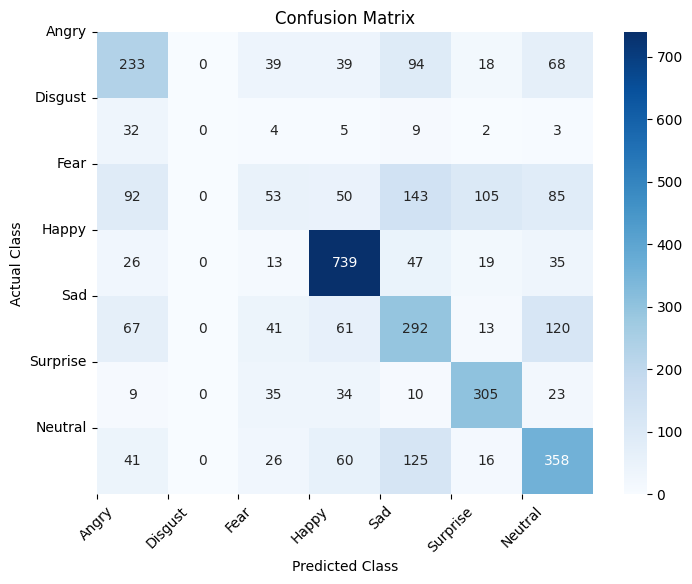

100%|██████████| 113/113 [00:01<00:00, 84.48it/s]


epoch:  26 | Train acc: 56.88 | Val acc: 55.56 | Train loss: 1.1612 | Val loss: 1.1900 | Confusion matrix: [[221   0  13  42  89  15  87]
 [ 30   0   2   5  14   0   5]
 [ 73   0  65  37 153  78  90]
 [ 30   0   5 725  44  24  67]
 [ 78   0  37  43 316   9 170]
 [ 16   0  35  24  10 308  22]
 [ 50   0  22  49 119   8 359]]
overwriting the best model!
epoch:  26 | Test acc: 55.78 | Test loss: 1.1681 | Test Confusion matrix: [[252   0  28  32  88   9  82]
 [ 30   0   4   2  14   2   3]
 [105   0  59  37 135  93  99]
 [ 29   0  11 735  42  15  47]
 [ 74   0  34  53 286   7 140]
 [ 16   0  40  31  10 290  29]
 [ 47   0  16  49 125   9 380]]


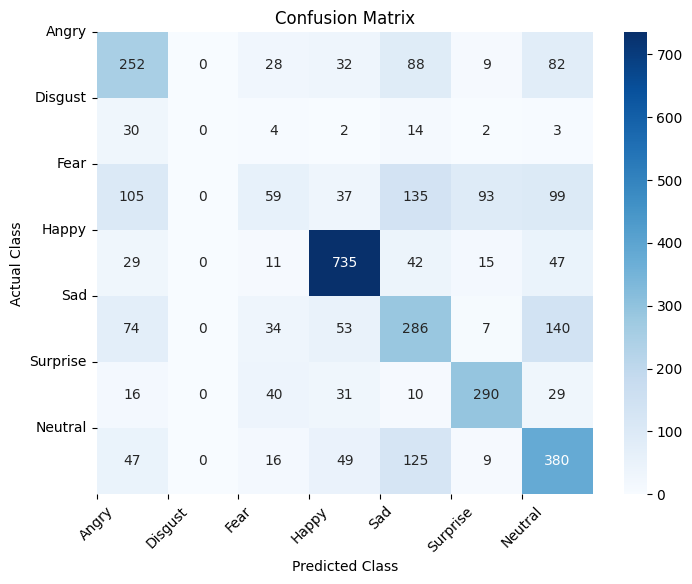

100%|██████████| 113/113 [00:01<00:00, 85.94it/s]


epoch:  27 | Train acc: 57.09 | Val acc: 55.42 | Train loss: 1.1497 | Val loss: 1.1850 | Confusion matrix: [[200   0  20  38 104  15  90]
 [ 26   0   4   5  15   0   6]
 [ 64   0  76  36 156  74  90]
 [ 25   0   8 733  47  34  48]
 [ 59   0  45  48 338   9 154]
 [ 16   0  52  22  10 296  19]
 [ 38   0  24  59 130  10 346]]


100%|██████████| 113/113 [00:01<00:00, 86.42it/s]


epoch:  28 | Train acc: 57.44 | Val acc: 54.92 | Train loss: 1.1401 | Val loss: 1.1805 | Confusion matrix: [[183   0  21  46 135  13  69]
 [ 24   0   1   8  19   0   4]
 [ 55   0  75  40 186  66  74]
 [ 22   0  16 733  57  21  46]
 [ 51   0  45  51 373  12 121]
 [ 13   0  61  25  12 286  18]
 [ 36   0  23  58 162   7 321]]


100%|██████████| 113/113 [00:01<00:00, 87.14it/s]


epoch:  29 | Train acc: 58.01 | Val acc: 55.00 | Train loss: 1.1333 | Val loss: 1.1858 | Confusion matrix: [[211   0  13  46 113  11  73]
 [ 27   0   2   7  16   0   4]
 [ 77   0  63  49 167  56  84]
 [ 27   0   6 751  35  23  53]
 [ 80   0  31  57 338   5 142]
 [ 20   0  53  28  13 274  27]
 [ 53   0  18  63 132   4 337]]


100%|██████████| 113/113 [00:01<00:00, 86.01it/s]


epoch:  30 | Train acc: 58.47 | Val acc: 55.25 | Train loss: 1.1224 | Val loss: 1.1853 | Confusion matrix: [[183   0   8  64 118  17  77]
 [ 30   0   2   9  12   0   3]
 [ 56   0  59  58 174  65  84]
 [ 13   0   8 763  46  21  44]
 [ 59   0  30  72 355  10 127]
 [ 12   0  40  33  14 293  23]
 [ 36   0  19  74 140   8 330]]


100%|██████████| 113/113 [00:01<00:00, 86.62it/s]


epoch:  31 | Train acc: 58.56 | Val acc: 55.75 | Train loss: 1.1148 | Val loss: 1.1781 | Confusion matrix: [[247   0  16  40  92  18  54]
 [ 39   0   3   3   8   0   3]
 [ 90   0  85  39 146  69  67]
 [ 40   0  10 727  46  31  41]
 [112   0  52  45 325  12 107]
 [ 15   0  42  25  11 310  12]
 [ 75   0  31  60 123  11 307]]
overwriting the best model!
epoch:  31 | Test acc: 55.87 | Test loss: 1.1596 | Test Confusion matrix: [[286   0  27  30  79  13  56]
 [ 36   0   4   1  11   2   1]
 [131   0  72  30 135  98  62]
 [ 34   0  15 731  53  17  29]
 [ 95   0  39  46 300  12 102]
 [ 15   0  47  28   5 303  18]
 [ 74   0  30  60 131  18 313]]


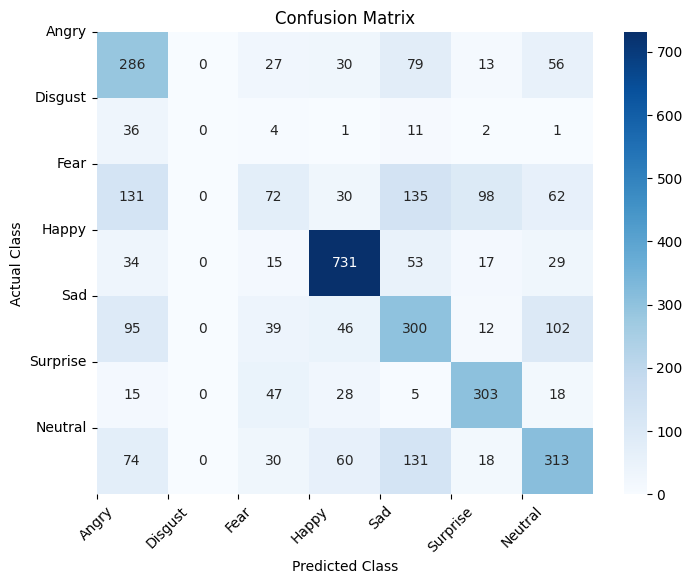

100%|██████████| 113/113 [00:01<00:00, 87.30it/s]


epoch:  32 | Train acc: 58.61 | Val acc: 55.56 | Train loss: 1.1153 | Val loss: 1.1724 | Confusion matrix: [[204   0  21  36  95  19  92]
 [ 29   0   3   6  13   0   5]
 [ 67   0  70  42 154  80  83]
 [ 30   0   9 721  40  28  67]
 [ 64   0  49  44 317  12 167]
 [ 13   0  36  26   8 316  16]
 [ 37   0  32  49 113  10 366]]


100%|██████████| 113/113 [00:01<00:00, 86.40it/s]


epoch:  33 | Train acc: 58.86 | Val acc: 55.25 | Train loss: 1.1084 | Val loss: 1.1850 | Confusion matrix: [[166   0  24  46 145  19  67]
 [ 20   0   3   7  20   2   4]
 [ 49   0  85  42 161  85  74]
 [ 17   0   8 735  51  28  56]
 [ 37   0  67  49 360  11 129]
 [  9   0  28  30  11 317  20]
 [ 27   0  27  52 166  15 320]]


100%|██████████| 113/113 [00:01<00:00, 84.41it/s]


epoch:  34 | Train acc: 59.25 | Val acc: 55.06 | Train loss: 1.1026 | Val loss: 1.1799 | Confusion matrix: [[205   0  19  52 104  12  75]
 [ 29   0   2   7  14   0   4]
 [ 69   0  87  41 150  61  88]
 [ 26   0  12 741  42  24  50]
 [ 65   0  41  56 317  10 164]
 [ 19   0  55  29  10 283  19]
 [ 51   0  26  64 115   8 343]]


100%|██████████| 113/113 [00:01<00:00, 88.25it/s]


epoch:  35 | Train acc: 59.71 | Val acc: 55.11 | Train loss: 1.0944 | Val loss: 1.1746 | Confusion matrix: [[195   0  19  38 141  13  61]
 [ 26   0   3   4  18   1   4]
 [ 62   0  83  38 192  61  60]
 [ 23   0  14 734  59  24  41]
 [ 64   0  41  43 393  10 102]
 [ 11   0  66  25  15 280  18]
 [ 37   0  29  51 191   6 293]]


100%|██████████| 113/113 [00:01<00:00, 90.79it/s]


epoch:  36 | Train acc: 59.21 | Val acc: 56.14 | Train loss: 1.0985 | Val loss: 1.1745 | Confusion matrix: [[231   0  19  51  72  12  82]
 [ 35   0   3   6   9   0   3]
 [ 86   0  87  38 131  66  88]
 [ 30   0  10 745  30  23  57]
 [100   0  41  63 296  13 140]
 [ 25   0  22  32   6 305  25]
 [ 53   0  26  65  99  13 351]]
overwriting the best model!
epoch:  36 | Test acc: 56.00 | Test loss: 1.1578 | Test Confusion matrix: [[267   0  25  39  70  14  76]
 [ 37   0   2   2  10   2   2]
 [120   0  86  42 106  85  89]
 [ 34   0   8 753  33  18  33]
 [ 88   0  41  73 250  11 131]
 [ 19   0  41  38   6 281  31]
 [ 55   0  17  71  99  11 373]]


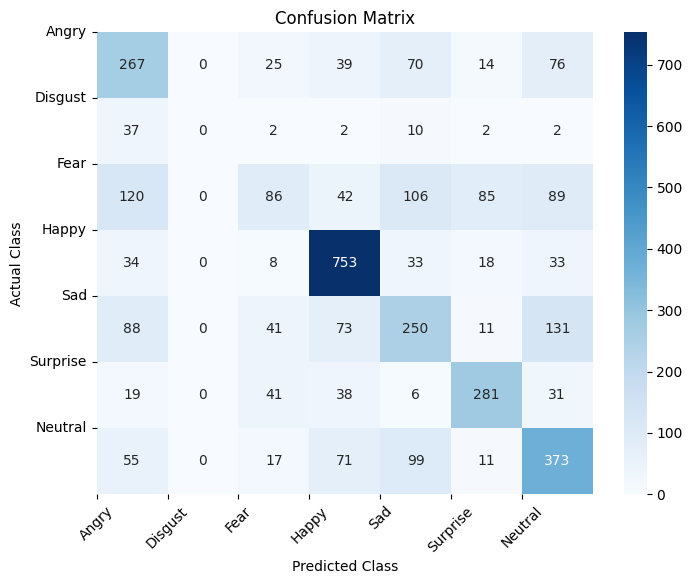

100%|██████████| 113/113 [00:01<00:00, 86.82it/s]


epoch:  37 | Train acc: 59.95 | Val acc: 55.22 | Train loss: 1.0897 | Val loss: 1.1859 | Confusion matrix: [[217   0  22  53  85  15  75]
 [ 32   0   7   5   7   0   5]
 [ 72   0  98  39 141  60  86]
 [ 33   0  11 725  35  21  70]
 [ 84   0  44  50 325  11 139]
 [ 13   0  45  29  11 283  34]
 [ 61   0  19  53 134   6 334]]


100%|██████████| 113/113 [00:01<00:00, 84.80it/s]


epoch:  38 | Train acc: 59.54 | Val acc: 56.23 | Train loss: 1.0884 | Val loss: 1.1744 | Confusion matrix: [[210   0  21  38  91  18  89]
 [ 32   0   4   4  12   0   4]
 [ 64   0 101  32 150  70  79]
 [ 29   0  14 728  48  27  49]
 [ 74   0  45  47 327  16 144]
 [ 14   0  37  27  12 306  19]
 [ 38   0  25  54 128  16 346]]
overwriting the best model!
epoch:  38 | Test acc: 56.81 | Test loss: 1.1388 | Test Confusion matrix: [[242   0  44  25  88  15  77]
 [ 33   0   3   2  12   2   3]
 [ 88   0  99  29 144  86  82]
 [ 27   0  15 741  46  16  34]
 [ 64   0  58  46 291   8 127]
 [  9   0  47  33   6 293  28]
 [ 33   0  28  52 130  10 373]]


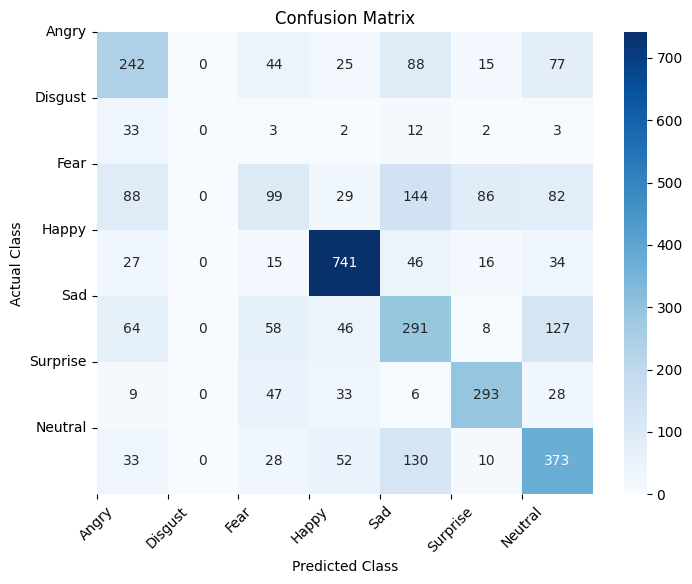

100%|██████████| 113/113 [00:01<00:00, 85.38it/s]


epoch:  39 | Train acc: 60.06 | Val acc: 54.81 | Train loss: 1.0857 | Val loss: 1.1862 | Confusion matrix: [[220   0  30  43  80  13  81]
 [ 34   0   3   6  10   0   3]
 [ 66   0  98  49 125  60  98]
 [ 28   0  12 740  37  21  57]
 [ 81   0  61  61 281  14 155]
 [ 13   0  46  35   4 286  31]
 [ 53   0  21  60 118  13 342]]


100%|██████████| 113/113 [00:01<00:00, 88.02it/s]


epoch:  40 | Train acc: 60.26 | Val acc: 56.06 | Train loss: 1.0814 | Val loss: 1.1773 | Confusion matrix: [[178   0  38  47 104  20  80]
 [ 27   0   9   3  12   1   4]
 [ 49   0 109  33 145  72  88]
 [ 14   0  15 733  46  31  56]
 [ 47   0  62  46 345  20 133]
 [ 11   0  49  24  11 310  10]
 [ 33   0  34  54 134  15 337]]


100%|██████████| 113/113 [00:01<00:00, 85.48it/s]


epoch:  41 | Train acc: 60.25 | Val acc: 55.61 | Train loss: 1.0791 | Val loss: 1.1806 | Confusion matrix: [[214   0  19  45  96  15  78]
 [ 31   0   3   6  10   0   6]
 [ 54   0  94  41 153  73  81]
 [ 28   0   9 730  35  27  66]
 [ 62   0  56  57 333  11 134]
 [ 19   0  48  24   9 291  24]
 [ 43   0  17  57 148   8 334]]


100%|██████████| 113/113 [00:01<00:00, 86.71it/s]


epoch:  42 | Train acc: 60.42 | Val acc: 55.17 | Train loss: 1.0734 | Val loss: 1.1885 | Confusion matrix: [[227   0  23  62  77   8  70]
 [ 33   0   4   6   7   1   5]
 [ 86   0  83  47 132  58  90]
 [ 28   0   8 750  32  21  56]
 [ 87   0  42  71 302  11 140]
 [ 24   0  46  32  11 273  29]
 [ 55   0  18  64 121   4 345]]


100%|██████████| 113/113 [00:01<00:00, 86.68it/s]


epoch:  43 | Train acc: 60.65 | Val acc: 55.64 | Train loss: 1.0674 | Val loss: 1.1909 | Confusion matrix: [[201   0  26  48 104  14  74]
 [ 29   0   5   4  11   0   7]
 [ 62   0 107  38 145  56  88]
 [ 18   0  16 718  56  27  60]
 [ 58   0  55  55 339  13 133]
 [ 11   0  63  24  13 285  19]
 [ 36   0  31  41 144   8 347]]


100%|██████████| 113/113 [00:01<00:00, 87.49it/s]


epoch:  44 | Train acc: 60.89 | Val acc: 56.78 | Train loss: 1.0674 | Val loss: 1.1868 | Confusion matrix: [[222   0  26  57  92  19  51]
 [ 38   0   3   5   7   0   3]
 [ 69   0 100  50 131  70  76]
 [ 24   0  10 766  24  30  41]
 [ 75   0  61  75 323  19 100]
 [ 13   0  39  26  12 308  17]
 [ 51   0  30  78 117  12 319]]
overwriting the best model!
epoch:  44 | Test acc: 55.56 | Test loss: 1.1620 | Test Confusion matrix: [[240   0  40  42  96  15  58]
 [ 29   0   4   8   8   2   4]
 [ 89   0  92  51 139 101  56]
 [ 31   0  20 758  28  18  24]
 [ 61   0  43  81 287  12 110]
 [ 13   0  52  29   9 296  17]
 [ 48   0  23  85 137  12 321]]


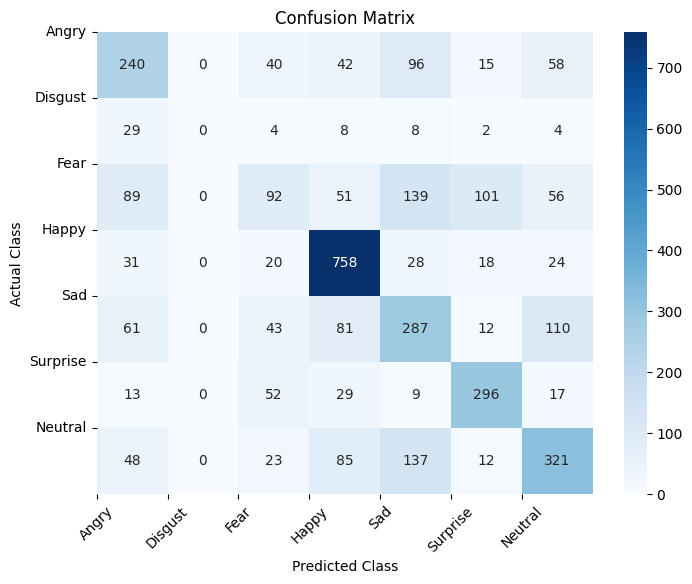

100%|██████████| 113/113 [00:01<00:00, 85.67it/s]


epoch:  45 | Train acc: 60.95 | Val acc: 55.06 | Train loss: 1.0632 | Val loss: 1.2009 | Confusion matrix: [[173   0  42  42 125   9  76]
 [ 26   0   8   4  14   0   4]
 [ 47   0 136  39 149  47  78]
 [ 20   0  23 724  50  19  59]
 [ 42   0  64  47 373   6 121]
 [ 11   0  76  26  10 259  33]
 [ 29   0  56  56 154   1 311]]


100%|██████████| 113/113 [00:01<00:00, 82.21it/s]


epoch:  46 | Train acc: 60.95 | Val acc: 55.61 | Train loss: 1.0620 | Val loss: 1.1925 | Confusion matrix: [[230   0  29  47  89  12  60]
 [ 35   0   3   7   8   0   3]
 [ 70   0 124  40 140  48  74]
 [ 25   0  16 712  52  23  67]
 [ 96   0  70  41 330  10 106]
 [ 16   0  56  27  11 288  17]
 [ 62   0  41  50 134   8 312]]


100%|██████████| 113/113 [00:01<00:00, 85.93it/s]


epoch:  47 | Train acc: 61.43 | Val acc: 55.67 | Train loss: 1.0585 | Val loss: 1.1928 | Confusion matrix: [[220   0  30  42  80  17  78]
 [ 29   0   3   8  10   1   5]
 [ 55   0  99  50 131  71  90]
 [ 29   0  13 734  29  30  60]
 [ 72   0  58  58 302  13 150]
 [ 13   0  40  30   8 306  18]
 [ 65   0  27  65  98  15 337]]


100%|██████████| 113/113 [00:01<00:00, 85.91it/s]


epoch:  48 | Train acc: 61.53 | Val acc: 55.78 | Train loss: 1.0579 | Val loss: 1.1938 | Confusion matrix: [[211   0  25  58  89   8  76]
 [ 32   0   3   5  12   0   4]
 [ 62   0  97  47 149  46  95]
 [ 23   0  16 753  36  19  48]
 [ 77   0  39  66 328  12 131]
 [ 15   0  71  33   8 267  21]
 [ 49   0  26  60 121   5 346]]


100%|██████████| 113/113 [00:01<00:00, 88.17it/s]


epoch:  49 | Train acc: 61.59 | Val acc: 55.36 | Train loss: 1.0523 | Val loss: 1.1962 | Confusion matrix: [[208   0  33  38  84  16  88]
 [ 35   0   4   4  10   0   3]
 [ 64   0 112  37 130  52 101]
 [ 26   0  16 717  43  26  67]
 [ 76   0  59  44 302  12 160]
 [ 14   0  46  19   9 294  33]
 [ 56   0  22  44 123   8 354]]


100%|██████████| 113/113 [00:01<00:00, 85.15it/s]


epoch:  50 | Train acc: 61.37 | Val acc: 55.22 | Train loss: 1.0466 | Val loss: 1.1927 | Confusion matrix: [[227   0  41  42  72  12  73]
 [ 35   0   9   3   6   0   3]
 [ 58   0 126  45 127  60  80]
 [ 40   0  17 735  28  21  54]
 [ 87   0  81  55 292  10 128]
 [ 17   0  58  29  11 274  26]
 [ 56   0  40  67 108   8 328]]


100%|██████████| 113/113 [00:01<00:00, 87.68it/s]


epoch:  51 | Train acc: 63.66 | Val acc: 56.17 | Train loss: 1.0053 | Val loss: 1.1827 | Confusion matrix: [[224   0  23  42  78  15  85]
 [ 32   0   5   6  10   0   3]
 [ 68   0  87  45 133  74  89]
 [ 26   0  11 736  34  25  63]
 [ 76   0  47  50 320  17 143]
 [ 16   0  37  28   7 304  23]
 [ 51   0  29  49 118  15 345]]


100%|██████████| 113/113 [00:01<00:00, 85.89it/s]


epoch:  52 | Train acc: 64.04 | Val acc: 56.37 | Train loss: 0.9922 | Val loss: 1.1781 | Confusion matrix: [[220   0  27  35  98  11  76]
 [ 33   0   6   4  10   0   3]
 [ 70   0 108  37 153  51  77]
 [ 31   0  14 722  47  21  60]
 [ 75   0  51  36 364   9 118]
 [ 16   0  52  22  12 292  21]
 [ 51   0  34  43 155   7 317]]


100%|██████████| 113/113 [00:01<00:00, 80.53it/s]


epoch:  53 | Train acc: 64.39 | Val acc: 56.06 | Train loss: 0.9864 | Val loss: 1.1911 | Confusion matrix: [[233   0  18  40  77  14  85]
 [ 32   0   6   5   7   0   6]
 [ 84   0  92  44 122  65  89]
 [ 32   0  12 726  32  26  67]
 [ 80   0  46  55 298  20 154]
 [ 19   0  44  26   2 305  19]
 [ 52   0  28  54 100  15 358]]


100%|██████████| 113/113 [00:01<00:00, 82.64it/s]


epoch:  54 | Train acc: 64.67 | Val acc: 56.45 | Train loss: 0.9796 | Val loss: 1.1896 | Confusion matrix: [[233   0  35  34  87  15  63]
 [ 32   0   6   5   9   0   4]
 [ 63   0 123  41 134  65  70]
 [ 37   0  17 719  41  25  56]
 [ 74   0  80  37 333  16 113]
 [ 14   0  55  24   7 302  13]
 [ 49   0  44  49 134  15 316]]


100%|██████████| 113/113 [00:01<00:00, 86.80it/s]


epoch:  55 | Train acc: 64.98 | Val acc: 56.39 | Train loss: 0.9748 | Val loss: 1.1851 | Confusion matrix: [[226   0  33  33  87  14  74]
 [ 32   0   8   3   9   0   4]
 [ 67   0 121  33 140  64  71]
 [ 33   0  17 721  42  26  56]
 [ 74   0  61  44 337  21 116]
 [ 13   0  54  24  11 303  10]
 [ 49   0  42  52 134  14 316]]


100%|██████████| 113/113 [00:01<00:00, 88.23it/s]


epoch:  56 | Train acc: 65.26 | Val acc: 56.39 | Train loss: 0.9717 | Val loss: 1.1874 | Confusion matrix: [[230   0  28  36  85  15  73]
 [ 32   0   6   5   9   0   4]
 [ 67   0 104  40 135  63  87]
 [ 37   0  17 719  40  23  59]
 [ 71   0  56  40 336  16 134]
 [ 16   0  51  24   8 299  17]
 [ 47   0  36  44 134  10 336]]


100%|██████████| 113/113 [00:01<00:00, 86.77it/s]


epoch:  57 | Train acc: 65.99 | Val acc: 56.56 | Train loss: 0.9506 | Val loss: 1.1822 | Confusion matrix: [[231   0  26  39 108   9  54]
 [ 33   0   5   4  10   0   4]
 [ 74   0 114  40 165  39  64]
 [ 26   0  17 733  51  18  50]
 [ 72   0  48  41 385   9  98]
 [ 17   0  59  29  19 279  12]
 [ 56   0  29  52 176   6 288]]


100%|██████████| 113/113 [00:01<00:00, 85.81it/s]


epoch:  58 | Train acc: 65.88 | Val acc: 56.37 | Train loss: 0.9507 | Val loss: 1.1888 | Confusion matrix: [[226   0  26  40  86  14  75]
 [ 34   0   5   5   8   0   4]
 [ 71   0 106  40 135  61  83]
 [ 27   0  18 727  36  21  66]
 [ 78   0  55  44 319  18 139]
 [ 16   0  50  25   7 298  19]
 [ 49   0  33  48 118  12 347]]


100%|██████████| 113/113 [00:01<00:00, 86.47it/s]


epoch:  59 | Train acc: 65.81 | Val acc: 56.37 | Train loss: 0.9540 | Val loss: 1.1848 | Confusion matrix: [[226   0  25  38 108  13  57]
 [ 32   0   6   4  10   0   4]
 [ 74   0 117  36 158  52  59]
 [ 29   0  17 721  53  21  54]
 [ 70   0  56  37 377  12 101]
 [ 14   0  57  26  13 288  17]
 [ 52   0  37  49 166   9 294]]
epoch:  59 | Test acc: 57.40 | Test loss: 1.1587 | Test Confusion matrix: [[258   0  51  26  92   8  56]
 [ 31   0   3   5  14   0   2]
 [ 81   0 130  31 162  67  57]
 [ 35   0  26 731  43  11  33]
 [ 62   0  49  38 344   9  92]
 [ 17   0  55  31  12 282  19]
 [ 53   0  18  55 173  12 315]]
Early stopping at epoch 59
epoch:  59 | Test acc: 57.40 | Test loss: 1.1587 | Test Confusion matrix: [[258   0  51  26  92   8  56]
 [ 31   0   3   5  14   0   2]
 [ 81   0 130  31 162  67  57]
 [ 35   0  26 731  43  11  33]
 [ 62   0  49  38 344   9  92]
 [ 17   0  55  31  12 282  19]
 [ 53   0  18  55 173  12 315]]


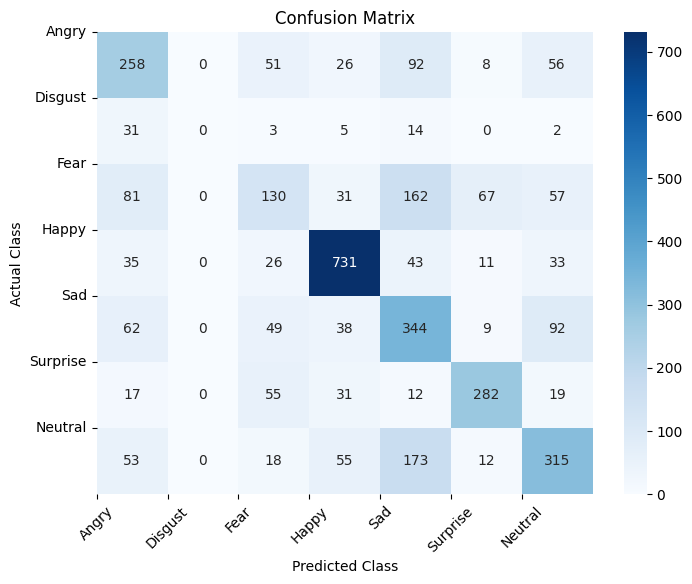

wandb: Agent Starting Run: qjjfzjfn with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.0001
wandb: 	weight_decay: 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


device:  cuda:0


  0%|          | 0/898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 113/113 [00:01<00:00, 85.97it/s]


epoch:   1 | Train acc: 37.77 | Val acc: 44.08 | Train loss: 1.5817 | Val loss: 1.4567 | Confusion matrix: [[ 91   0  39  86 142  39  70]
 [ 10   0   6  13  17   1   9]
 [ 42   0  78  58 159  86  73]
 [ 22   0  28 564 168  43  70]
 [ 50   0  35  88 338  30 112]
 [ 10   0  35  27  48 259  36]
 [ 30   0  38  70 180  37 252]]
overwriting the best model!
epoch:   1 | Test acc: 43.49 | Test loss: 1.4556 | Test Confusion matrix: [[ 97   0  41  64 164  39  86]
 [ 13   0   3  12  10   4  13]
 [ 35   0  85  75 162  95  76]
 [ 37   0  41 547 172  31  51]
 [ 42   0  33  67 304  34 114]
 [  6   0  48  31  42 252  37]
 [ 28   0  33  75 182  32 276]]


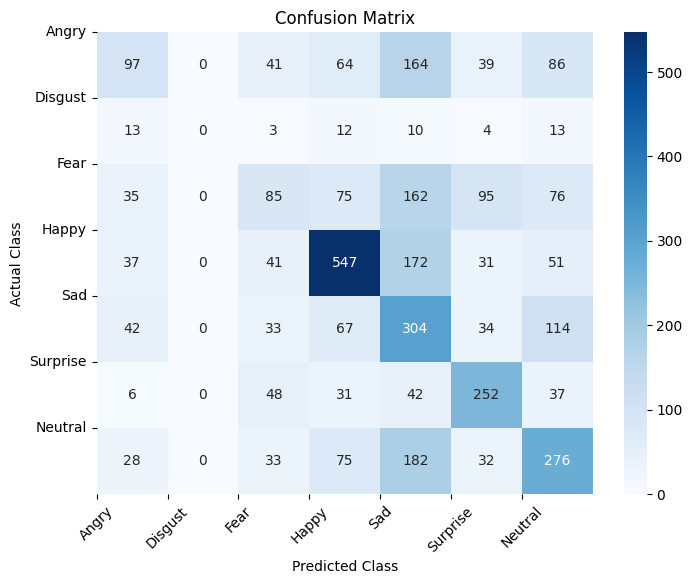

100%|██████████| 113/113 [00:01<00:00, 84.99it/s]


epoch:   2 | Train acc: 47.60 | Val acc: 48.48 | Train loss: 1.3714 | Val loss: 1.3464 | Confusion matrix: [[143   0  28  88 102  17  89]
 [ 12   6   8   8  14   0   8]
 [ 59   0 107  79  98  57  96]
 [ 40   0  22 672  62  12  87]
 [ 80   0  53 127 245  15 133]
 [ 20   0  34  38  31 257  35]
 [ 55   1  34  81 107  19 310]]
overwriting the best model!
epoch:   2 | Test acc: 47.81 | Test loss: 1.3505 | Test Confusion matrix: [[165   3  38  73 104  18  90]
 [ 22   6   7   7   6   1   6]
 [ 73   1  95  82 127  65  85]
 [ 43   0  28 663  77   7  61]
 [ 75   1  36  98 229  14 141]
 [ 24   0  42  42  34 243  31]
 [ 57   1  24 104 103  22 315]]


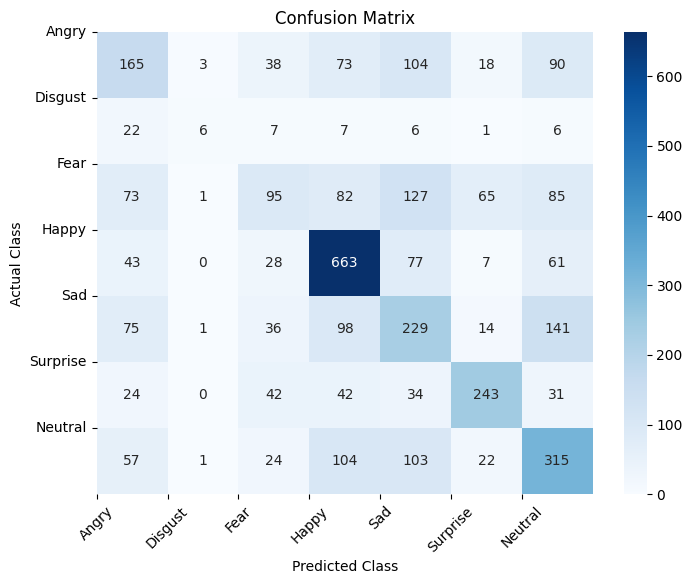

100%|██████████| 113/113 [00:01<00:00, 88.66it/s]


epoch:   3 | Train acc: 53.15 | Val acc: 49.35 | Train loss: 1.2366 | Val loss: 1.3233 | Confusion matrix: [[178   1  31  94  49  17  97]
 [ 21   8   5   9   5   1   7]
 [ 90   0 119  72  69  56  90]
 [ 44   0  27 707  18  23  76]
 [111   0  56 152 150  16 168]
 [ 24   0  43  28  15 274  31]
 [ 75   1  24 106  50  16 335]]
overwriting the best model!
epoch:   3 | Test acc: 49.57 | Test loss: 1.3159 | Test Confusion matrix: [[203   2  43  82  44  22  95]
 [ 24   7   3   7   4   4   6]
 [101   0 126  79  66  66  90]
 [ 58   0  34 693  27  17  50]
 [115   1  46 108 133  17 174]
 [ 30   0  48  32   3 268  35]
 [ 70   1  23 121  46  16 349]]


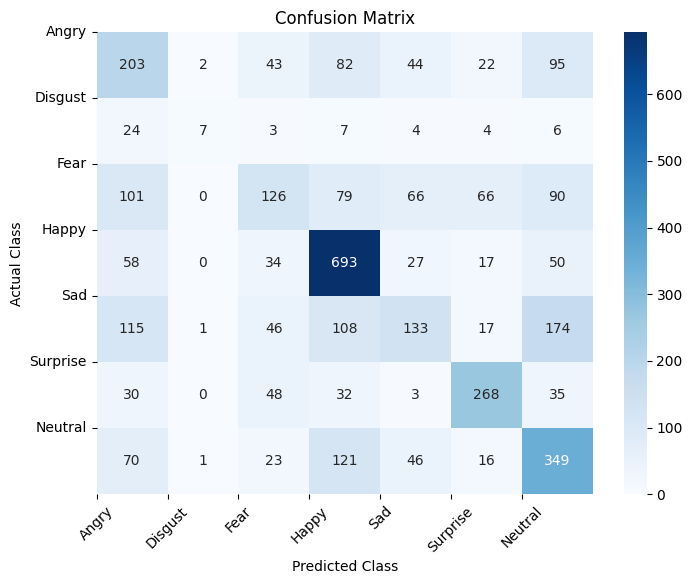

100%|██████████| 113/113 [00:01<00:00, 86.58it/s]


epoch:   4 | Train acc: 58.53 | Val acc: 49.85 | Train loss: 1.1186 | Val loss: 1.3425 | Confusion matrix: [[158   1  32  57  86  45  88]
 [  8  16   5   8  10   3   6]
 [ 61   0  98  45 102 108  82]
 [ 40   0  31 623  56  51  94]
 [ 62   1  65  90 249  56 130]
 [ 17   1  23  13  16 327  18]
 [ 42   1  22  64 103  57 318]]
overwriting the best model!
epoch:   4 | Test acc: 49.71 | Test loss: 1.3206 | Test Confusion matrix: [[166   3  38  50 102  49  83]
 [ 14  13   5   6   6   4   7]
 [ 57   4 118  56 107 112  74]
 [ 56   0  37 618  60  48  60]
 [ 51   4  51  82 231  47 128]
 [ 17   1  21  19  12 323  23]
 [ 45   2  26  75 107  56 315]]


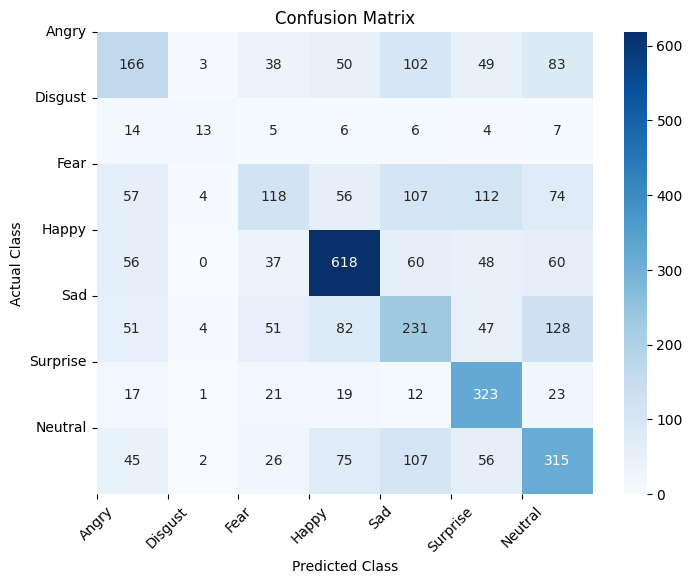

100%|██████████| 113/113 [00:01<00:00, 85.73it/s]


epoch:   5 | Train acc: 63.66 | Val acc: 50.01 | Train loss: 0.9923 | Val loss: 1.3254 | Confusion matrix: [[173   5  85  57  74  16  57]
 [  8  21  14   5   4   1   3]
 [ 49   1 185  58 109  46  48]
 [ 51   4  35 657  69  21  58]
 [ 81   5 115  97 247  18  90]
 [ 15   1  53  25  26 277  18]
 [ 65   0  73  62 146  26 235]]
overwriting the best model!
epoch:   5 | Test acc: 50.57 | Test loss: 1.2931 | Test Confusion matrix: [[185   2  88  54  81  22  59]
 [ 10  21  10   4   4   2   4]
 [ 64   4 200  54 106  57  43]
 [ 70   3  33 644  75  14  40]
 [ 86   7  98  72 232  22  77]
 [ 15   0  58  30  13 278  22]
 [ 48   2  61  93 146  21 255]]


100%|██████████| 113/113 [00:01<00:00, 88.19it/s]


epoch:   6 | Train acc: 68.79 | Val acc: 51.46 | Train loss: 0.8731 | Val loss: 1.3709 | Confusion matrix: [[179   4  40  49 111  10  74]
 [ 13  18   8   4   7   0   6]
 [ 66   0 155  43 130  31  71]
 [ 39   1  37 635  93  17  73]
 [ 74   4  90  61 297  21 106]
 [ 20   1  49  21  28 270  26]
 [ 48   2  34  65 153  12 293]]
overwriting the best model!
epoch:   6 | Test acc: 51.07 | Test loss: 1.3400 | Test Confusion matrix: [[199   6  53  35 110  13  75]
 [  9  21  10   3   6   1   5]
 [ 73   2 160  42 130  48  73]
 [ 47   2  36 601 110  15  68]
 [ 58   2  99  51 272   8 104]
 [ 16   0  58  28  23 259  32]
 [ 40   2  43  59 149  12 321]]


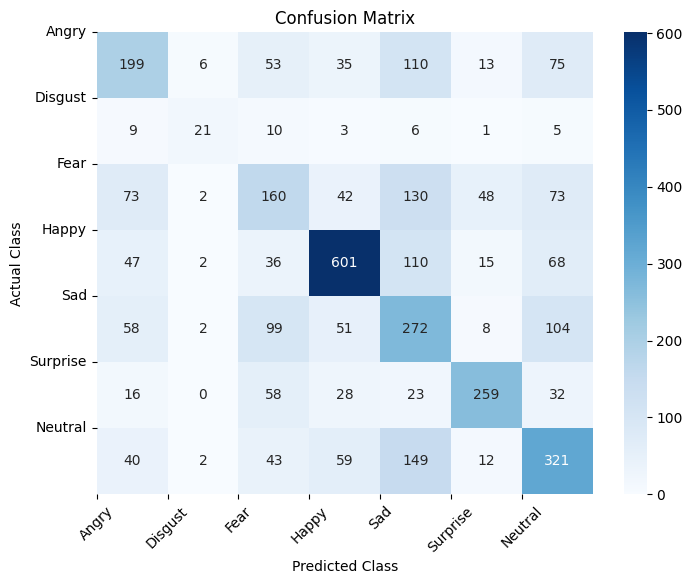

100%|██████████| 113/113 [00:01<00:00, 82.91it/s]


epoch:   7 | Train acc: 73.72 | Val acc: 52.69 | Train loss: 0.7450 | Val loss: 1.4115 | Confusion matrix: [[150   0  52  61 107  19  78]
 [ 14  15   6   6   8   1   6]
 [ 47   1 166  41 110  44  87]
 [ 25   0  32 668  84  13  73]
 [ 66   2  72  74 293  17 129]
 [ 14   1  48  23  24 279  26]
 [ 41   0  33  63 133  17 320]]
overwriting the best model!
epoch:   7 | Test acc: 51.71 | Test loss: 1.4044 | Test Confusion matrix: [[168   1  50  48 113  22  89]
 [ 12  16   9   6   6   1   5]
 [ 59   1 165  55 113  50  85]
 [ 30   2  32 632 101  16  66]
 [ 59   0  73  65 259  10 128]
 [ 15   0  53  32  18 272  26]
 [ 36   1  38  59 133  15 344]]


100%|██████████| 113/113 [00:01<00:00, 84.14it/s]


epoch:   8 | Train acc: 77.80 | Val acc: 50.85 | Train loss: 0.6429 | Val loss: 1.5369 | Confusion matrix: [[189   5  49  47  81  14  82]
 [ 15  19   4   1  10   0   7]
 [ 59   3 159  42 114  30  89]
 [ 42   6  42 601  53  17 134]
 [ 72   2  80  80 268  13 138]
 [ 16   1  63  31  17 259  28]
 [ 59   2  40  53 111  12 330]]


100%|██████████| 113/113 [00:01<00:00, 85.91it/s]


epoch:   9 | Train acc: 81.28 | Val acc: 52.97 | Train loss: 0.5423 | Val loss: 1.5607 | Confusion matrix: [[198   5  50  55  99  14  46]
 [ 17  19   6   3   9   1   1]
 [ 62   4 165  40 127  36  62]
 [ 45   2  29 664  80  16  59]
 [ 92   4  76  71 321  16  73]
 [ 18   2  42  23  24 272  34]
 [ 78   2  35  82 140   8 262]]
overwriting the best model!
epoch:   9 | Test acc: 52.61 | Test loss: 1.5223 | Test Confusion matrix: [[207   3  56  40 117  17  51]
 [ 13  24   4   3   6   1   4]
 [ 64   3 192  39 123  46  61]
 [ 38   3  43 643  89  17  46]
 [ 72   8  78  53 287   7  89]
 [ 19   2  50  33  14 271  27]
 [ 79   2  44  81 144  12 264]]


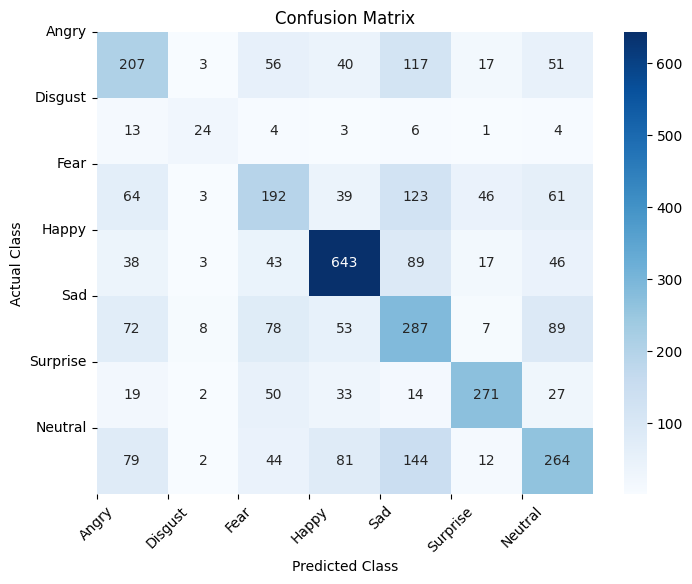

100%|██████████| 113/113 [00:01<00:00, 86.51it/s]


epoch:  10 | Train acc: 84.12 | Val acc: 51.30 | Train loss: 0.4664 | Val loss: 1.6233 | Confusion matrix: [[194   1  62  38  73  24  75]
 [ 19  15   6   5   6   1   4]
 [ 56   2 197  33  99  42  67]
 [ 55   1  49 612  54  27  97]
 [ 87   2 129  65 234  18 118]
 [ 16   1  46  19  16 293  24]
 [ 59   1  65  59 105  22 296]]


100%|██████████| 113/113 [00:01<00:00, 89.06it/s]


epoch:  11 | Train acc: 86.62 | Val acc: 51.80 | Train loss: 0.3962 | Val loss: 1.7727 | Confusion matrix: [[197   8  47  41  81  20  73]
 [ 16  28   2   2   3   1   4]
 [ 62   5 159  38 108  49  75]
 [ 62   3  32 604  66  27 101]
 [ 80   8  78  78 269  19 121]
 [ 20   3  36  16  25 283  32]
 [ 63   5  33  58 112  17 319]]


100%|██████████| 113/113 [00:01<00:00, 86.78it/s]


epoch:  12 | Train acc: 87.87 | Val acc: 51.16 | Train loss: 0.3531 | Val loss: 1.8561 | Confusion matrix: [[203   5  51  35  80  17  76]
 [ 12  25   2   5   7   1   4]
 [ 57   6 164  40 105  44  80]
 [ 53   6  40 594  59  22 121]
 [112   6  78  59 268  18 112]
 [ 13   4  36  24  21 286  31]
 [ 79   2  30  50 129  21 296]]


100%|██████████| 113/113 [00:01<00:00, 84.99it/s]


epoch:  13 | Train acc: 89.53 | Val acc: 52.30 | Train loss: 0.3104 | Val loss: 1.8599 | Confusion matrix: [[169   3  49  47  86  21  92]
 [  9  26   4   4   5   3   5]
 [ 38   1 155  44 101  62  95]
 [ 26   2  26 653  59  23 106]
 [ 60   6  84  65 277  22 139]
 [ 17   0  35  24  20 286  33]
 [ 43   3  36  60 128  26 311]]


100%|██████████| 113/113 [00:01<00:00, 86.92it/s]


epoch:  14 | Train acc: 90.85 | Val acc: 51.77 | Train loss: 0.2711 | Val loss: 1.9262 | Confusion matrix: [[183   4  48  61  86  12  73]
 [ 13  21   5   4   5   1   7]
 [ 55   5 175  53 112  20  76]
 [ 30   3  37 661  56  13  95]
 [ 81   3  74  71 289   9 126]
 [ 22   6  56  37  23 236  35]
 [ 58   0  46  62 139   9 293]]


100%|██████████| 113/113 [00:01<00:00, 88.64it/s]


epoch:  15 | Train acc: 91.63 | Val acc: 51.21 | Train loss: 0.2477 | Val loss: 2.0461 | Confusion matrix: [[189   4  58  31 100  20  65]
 [ 10  22   6   3   7   2   6]
 [ 54   1 179  27 131  50  54]
 [ 62   5  48 573  94  25  88]
 [ 72   3  98  41 326  18  95]
 [ 24   2  43  12  30 284  20]
 [ 70   4  40  36 172  20 265]]


100%|██████████| 113/113 [00:01<00:00, 84.86it/s]


epoch:  16 | Train acc: 96.27 | Val acc: 53.78 | Train loss: 0.1242 | Val loss: 2.1001 | Confusion matrix: [[199   3  53  57  64  24  67]
 [ 13  23   4   6   5   1   4]
 [ 54   3 184  52  94  40  69]
 [ 38   4  34 684  38  23  74]
 [ 87   4  92  82 265  16 107]
 [ 24   1  49  20  15 283  23]
 [ 70   0  41  74 114  16 292]]
overwriting the best model!
epoch:  16 | Test acc: 54.30 | Test loss: 2.0022 | Test Confusion matrix: [[222   3  60  49  73  15  69]
 [  9  30   4   6   1   2   3]
 [ 77   5 211  38  91  54  52]
 [ 49   1  33 657  68  27  44]
 [ 92   3  89  63 222  19 106]
 [ 14   3  47  29  15 285  23]
 [ 65   7  34  78 104  16 322]]


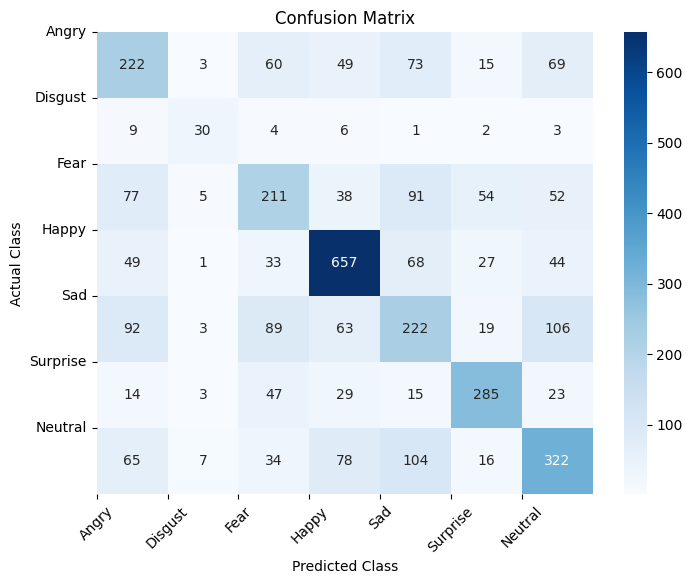

100%|██████████| 113/113 [00:01<00:00, 89.34it/s]


epoch:  17 | Train acc: 97.84 | Val acc: 53.22 | Train loss: 0.0757 | Val loss: 2.3082 | Confusion matrix: [[202   4  54  55  66  22  64]
 [ 13  24   6   4   5   1   3]
 [ 62   5 190  50  84  42  63]
 [ 38   3  43 673  44  21  73]
 [ 96   6 103  79 246  14 109]
 [ 22   1  37  27  16 289  23]
 [ 77   0  40  76 110  18 286]]


100%|██████████| 113/113 [00:01<00:00, 85.77it/s]


epoch:  18 | Train acc: 98.43 | Val acc: 53.50 | Train loss: 0.0557 | Val loss: 2.4310 | Confusion matrix: [[187   3  52  62  77  21  65]
 [ 12  22   3   6   6   2   5]
 [ 57   1 189  50  94  43  62]
 [ 37   2  32 686  53  18  67]
 [ 76   4  85  89 269  17 113]
 [ 18   1  42  28  17 290  19]
 [ 53   1  50  87 123  16 277]]


100%|██████████| 113/113 [00:01<00:00, 85.38it/s]


epoch:  19 | Train acc: 98.89 | Val acc: 52.91 | Train loss: 0.0423 | Val loss: 2.5914 | Confusion matrix: [[197   3  56  55  65  24  67]
 [ 10  22   7   4   7   1   5]
 [ 61   2 192  44  92  40  65]
 [ 43   3  37 670  39  27  76]
 [ 95   6 102  83 248  18 101]
 [ 21   0  42  24  17 289  22]
 [ 62   1  49  80 117  17 281]]


100%|██████████| 113/113 [00:01<00:00, 89.10it/s]


epoch:  20 | Train acc: 98.78 | Val acc: 52.61 | Train loss: 0.0431 | Val loss: 2.5263 | Confusion matrix: [[205   4  53  41  81  18  65]
 [ 12  25   5   4   6   1   3]
 [ 62   3 190  32 102  45  62]
 [ 46   5  40 632  61  26  85]
 [105   2  88  62 263  14 119]
 [ 19   0  51  19  18 289  19]
 [ 74   1  47  60 122  19 284]]


100%|██████████| 113/113 [00:01<00:00, 85.21it/s]


epoch:  21 | Train acc: 99.01 | Val acc: 53.13 | Train loss: 0.0367 | Val loss: 2.6516 | Confusion matrix: [[181   6  60  52  81  23  64]
 [ 13  26   4   4   5   1   3]
 [ 54   4 191  41 100  46  60]
 [ 39   1  34 668  50  29  74]
 [ 81   5  99  75 275  16 102]
 [ 16   2  44  24  17 292  20]
 [ 72   2  44  69 129  17 274]]


100%|██████████| 113/113 [00:01<00:00, 87.12it/s]


epoch:  22 | Train acc: 99.18 | Val acc: 53.25 | Train loss: 0.0320 | Val loss: 2.7837 | Confusion matrix: [[206   2  50  44  70  23  72]
 [ 16  20   4   6   5   1   4]
 [ 69   3 178  42  89  47  68]
 [ 45   3  32 666  48  25  76]
 [105   4  81  78 247  17 121]
 [ 16   0  42  23  22 293  19]
 [ 71   0  38  68 114  15 301]]


100%|██████████| 113/113 [00:01<00:00, 86.26it/s]


epoch:  23 | Train acc: 99.48 | Val acc: 52.86 | Train loss: 0.0221 | Val loss: 2.7160 | Confusion matrix: [[190   2  59  46  86  23  61]
 [ 15  20   5   6   5   1   4]
 [ 56   5 184  42 106  43  60]
 [ 38   2  36 671  56  25  67]
 [ 88   5  94  79 272  12 103]
 [ 15   0  48  23  21 288  20]
 [ 65   1  43  73 138  15 272]]


100%|██████████| 113/113 [00:01<00:00, 86.55it/s]


epoch:  24 | Train acc: 99.59 | Val acc: 53.00 | Train loss: 0.0181 | Val loss: 2.7703 | Confusion matrix: [[180   3  51  52  80  22  79]
 [ 14  22   5   5   5   1   4]
 [ 57   5 182  40  93  40  79]
 [ 39   3  34 664  48  24  83]
 [ 83   5  86  77 256  15 131]
 [ 16   0  44  22  20 288  25]
 [ 62   1  36  70 118  10 310]]


100%|██████████| 113/113 [00:01<00:00, 85.52it/s]


epoch:  25 | Train acc: 99.58 | Val acc: 53.02 | Train loss: 0.0172 | Val loss: 2.7671 | Confusion matrix: [[186   4  60  41  80  19  77]
 [ 17  19   6   4   5   1   4]
 [ 59   3 192  38  94  36  74]
 [ 41   2  38 664  53  19  78]
 [ 81   4 103  66 253  13 133]
 [ 16   0  52  23  17 280  27]
 [ 62   1  45  67 115   8 309]]


100%|██████████| 113/113 [00:01<00:00, 86.15it/s]


epoch:  26 | Train acc: 99.64 | Val acc: 52.94 | Train loss: 0.0157 | Val loss: 2.8131 | Confusion matrix: [[189   3  57  41  91  18  68]
 [ 15  20   5   6   5   1   4]
 [ 53   3 189  36 107  40  68]
 [ 38   1  38 645  63  22  88]
 [ 78   4 104  63 273  14 117]
 [ 16   0  45  23  22 289  20]
 [ 61   1  45  67 125  13 295]]


100%|██████████| 113/113 [00:01<00:00, 87.73it/s]


epoch:  27 | Train acc: 99.64 | Val acc: 52.94 | Train loss: 0.0146 | Val loss: 2.8729 | Confusion matrix: [[185   3  55  49  70  23  82]
 [ 14  21   5   6   5   1   4]
 [ 57   2 191  40  82  47  77]
 [ 41   1  40 664  43  23  83]
 [ 89   5 104  71 232  16 136]
 [ 16   0  48  23  16 289  23]
 [ 61   1  38  74 101  14 318]]


100%|██████████| 113/113 [00:01<00:00, 85.38it/s]


epoch:  28 | Train acc: 99.69 | Val acc: 53.72 | Train loss: 0.0120 | Val loss: 2.8495 | Confusion matrix: [[199   3  48  53  81  15  68]
 [ 14  22   4   6   5   1   4]
 [ 64   4 179  49 100  34  66]
 [ 42   2  32 683  53  15  68]
 [ 82   6  88  85 276  11 105]
 [ 17   0  48  31  20 275  24]
 [ 64   1  41  80 120   7 294]]


100%|██████████| 113/113 [00:01<00:00, 88.82it/s]


epoch:  29 | Train acc: 99.71 | Val acc: 53.27 | Train loss: 0.0113 | Val loss: 2.8711 | Confusion matrix: [[184   4  53  53  80  24  69]
 [ 13  21   5   6   5   1   5]
 [ 57   3 184  43 103  42  64]
 [ 37   3  34 678  54  17  72]
 [ 83   8  90  78 260  18 116]
 [ 16   0  41  25  20 290  23]
 [ 62   2  38  77 119  14 295]]


100%|██████████| 113/113 [00:01<00:00, 89.14it/s]


epoch:  30 | Train acc: 99.72 | Val acc: 53.33 | Train loss: 0.0109 | Val loss: 2.8027 | Confusion matrix: [[187   4  59  50  74  24  69]
 [ 13  23   5   5   5   1   4]
 [ 60   5 189  41  95  44  62]
 [ 36   3  37 675  53  22  69]
 [ 83   6  98  77 260  16 113]
 [ 15   0  46  26  18 289  21]
 [ 64   2  47  70 121  12 291]]


100%|██████████| 113/113 [00:01<00:00, 87.02it/s]


epoch:  31 | Train acc: 99.71 | Val acc: 53.44 | Train loss: 0.0105 | Val loss: 2.8661 | Confusion matrix: [[185   5  52  57  73  24  71]
 [ 13  23   4   6   5   1   4]
 [ 56   4 185  51  84  48  68]
 [ 36   2  33 687  44  21  72]
 [ 80   6  96  90 246  15 120]
 [ 15   1  42  29  17 290  21]
 [ 65   1  39  80 105  15 302]]
epoch:  31 | Test acc: 55.20 | Test loss: 2.6614 | Test Confusion matrix: [[214   2  56  55  76  15  73]
 [  7  29   4   7   3   2   3]
 [ 68   4 213  56  80  48  59]
 [ 38   2  26 674  63  29  47]
 [ 74   4  91  81 223  17 104]
 [ 13   3  47  35   8 293  17]
 [ 46   2  37  84 103  19 335]]
Early stopping at epoch 31
epoch:  31 | Test acc: 55.20 | Test loss: 2.6614 | Test Confusion matrix: [[214   2  56  55  76  15  73]
 [  7  29   4   7   3   2   3]
 [ 68   4 213  56  80  48  59]
 [ 38   2  26 674  63  29  47]
 [ 74   4  91  81 223  17 104]
 [ 13   3  47  35   8 293  17]
 [ 46   2  37  84 103  19 335]]


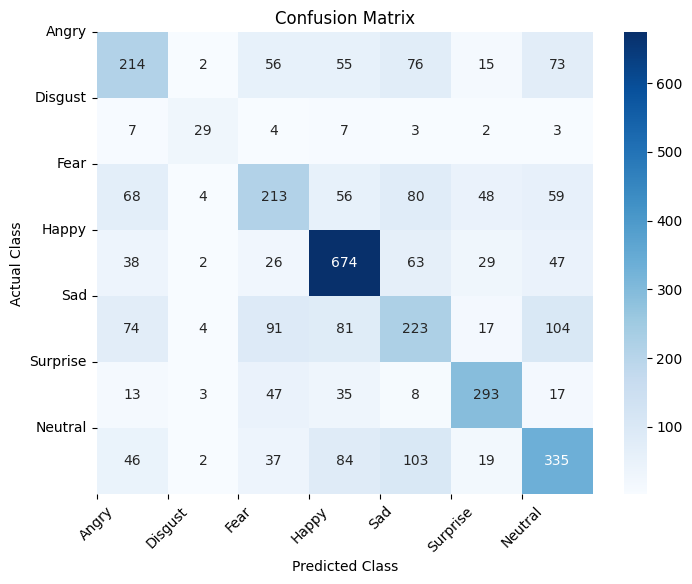

wandb: Agent Starting Run: x7dvd0m3 with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.0001
wandb: 	weight_decay: 0.01


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudn

epoch:   1 | Train acc: 37.73 | Val acc: 42.16 | Train loss: 1.5834 | Val loss: 1.4750 | Confusion matrix: [[ 57   0  33  66 205  46  60]
 [  9   0   6   7  21   4   9]
 [ 28   0  63  44 206 100  55]
 [ 29   0  23 518 215  61  49]
 [ 44   0  37  64 397  48  63]
 [ 11   0  26  19  60 269  30]
 [ 20   0  18  64 256  40 209]]
overwriting the best model!
epoch:   1 | Test acc: 42.38 | Test loss: 1.4783 | Test Confusion matrix: [[ 85   0  27  49 210  51  69]
 [ 11   0   3   5  20   5  11]
 [ 30   0  71  60 199 110  58]
 [ 20   0  23 518 244  45  29]
 [ 30   0  29  57 362  37  79]
 [  9   0  29  25  56 273  24]
 [ 20   0  19  67 266  42 212]]


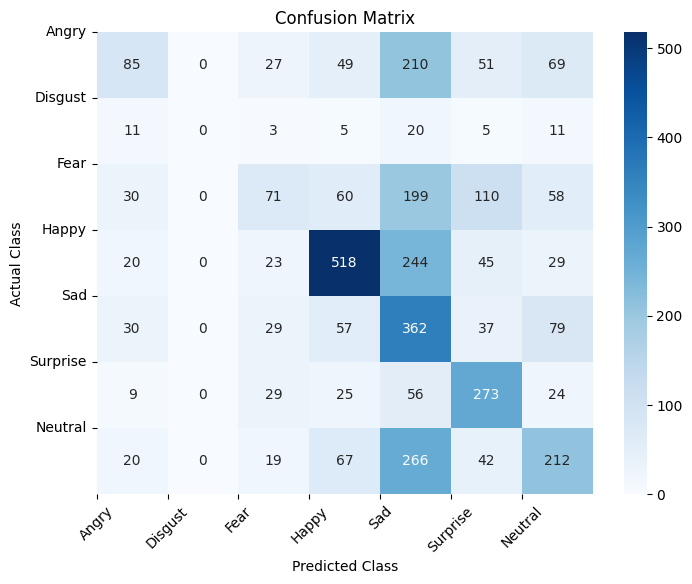

100%|██████████| 113/113 [00:01<00:00, 81.26it/s]


epoch:   2 | Train acc: 47.02 | Val acc: 46.53 | Train loss: 1.3851 | Val loss: 1.3755 | Confusion matrix: [[ 99   0  53  83  69  14 149]
 [ 13   5  10   7   6   0  15]
 [ 38   0 123  66  67  40 162]
 [ 21   0  27 624  46  14 163]
 [ 52   0  58  96 184  13 250]
 [ 12   0  60  30  17 225  71]
 [ 23   1  31  58  71  13 410]]
overwriting the best model!
epoch:   2 | Test acc: 47.65 | Test loss: 1.3596 | Test Confusion matrix: [[126   1  54  71  59  11 169]
 [ 18   3   5   8   3   3  15]
 [ 43   1 120  63  95  51 155]
 [ 24   0  27 632  58   5 133]
 [ 43   2  57  91 169   6 226]
 [  8   0  73  40  17 217  61]
 [ 22   0  27  64  56  14 443]]


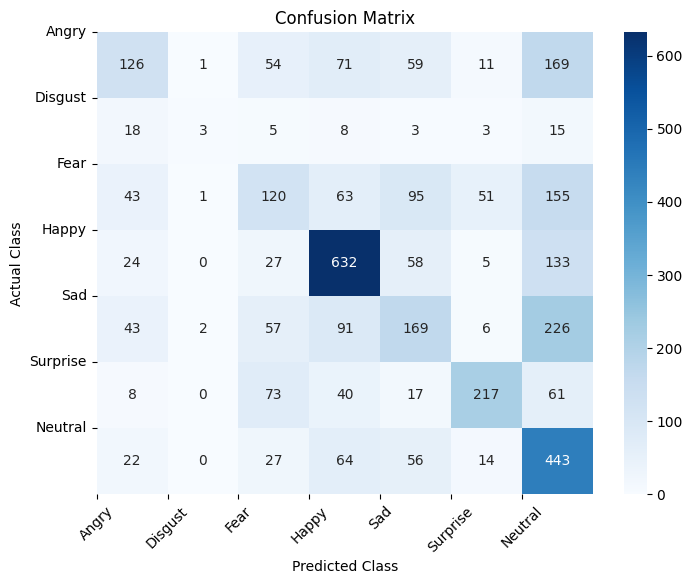

100%|██████████| 113/113 [00:01<00:00, 79.73it/s]


epoch:   3 | Train acc: 51.68 | Val acc: 49.65 | Train loss: 1.2763 | Val loss: 1.3013 | Confusion matrix: [[111   0  47  98 108  14  89]
 [ 10   7  13  12   8   0   6]
 [ 46   1 142  91 106  35  75]
 [ 25   0  25 720  51  15  59]
 [ 48   0  62 142 254  10 137]
 [ 22   0  67  41  13 241  31]
 [ 29   0  36 127  98  10 307]]
overwriting the best model!
epoch:   3 | Test acc: 50.40 | Test loss: 1.2960 | Test Confusion matrix: [[141   1  51 106  95  12  85]
 [ 16   6   8  10   8   1   6]
 [ 41   0 158  95 122  41  71]
 [ 21   0  24 720  64  10  40]
 [ 46   1  57 126 229  10 125]
 [ 12   0  77  39  20 235  33]
 [ 28   1  39 132  94  12 320]]


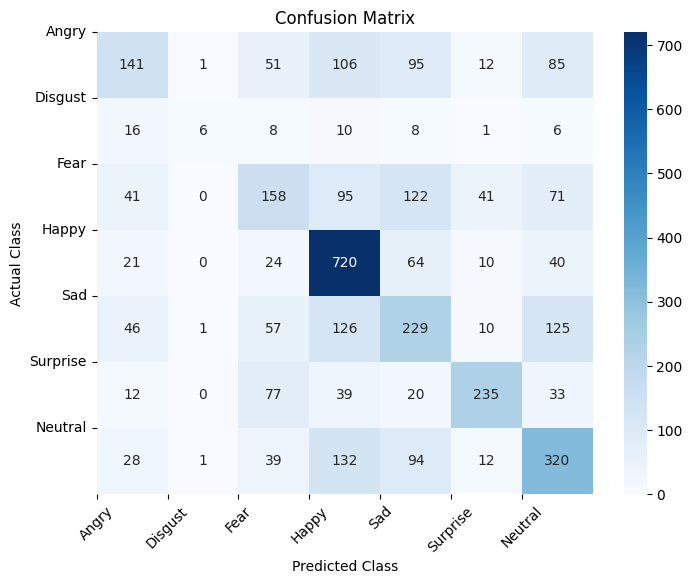

100%|██████████| 113/113 [00:01<00:00, 84.41it/s]


epoch:   4 | Train acc: 55.08 | Val acc: 50.29 | Train loss: 1.1960 | Val loss: 1.3323 | Confusion matrix: [[182   0   6  48 107  46  78]
 [ 25   9   2   5   8   3   4]
 [ 74   0  31  45 128 134  84]
 [ 60   0   5 612  57  73  88]
 [ 91   0  11  71 300  54 126]
 [ 20   0   8  13  17 341  16]
 [ 64   0   6  60 112  35 330]]
overwriting the best model!
epoch:   4 | Test acc: 50.15 | Test loss: 1.3202 | Test Confusion matrix: [[211   1   5  43 101  52  78]
 [ 25   5   2   5   9   4   5]
 [ 84   0  43  40 146 136  79]
 [ 66   0  17 614  60  54  68]
 [ 86   0  12  67 261  45 123]
 [ 17   0   7  17  21 333  21]
 [ 63   0   5  69 109  47 333]]


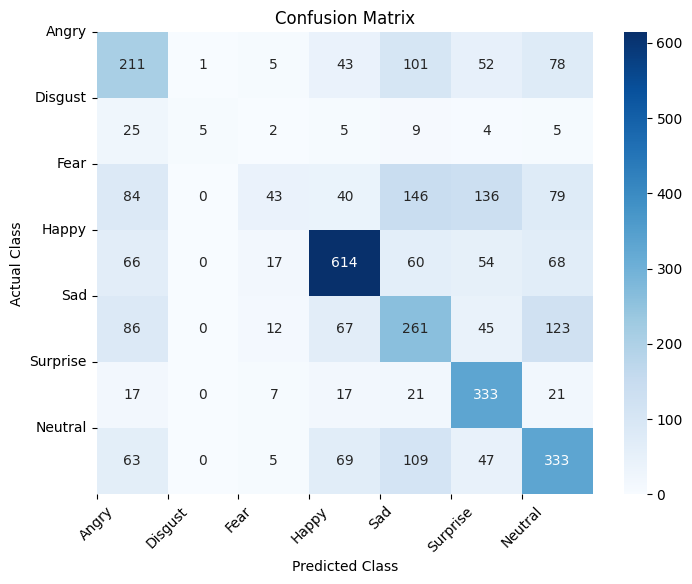

100%|██████████| 113/113 [00:01<00:00, 82.95it/s]


epoch:   5 | Train acc: 58.58 | Val acc: 51.27 | Train loss: 1.1158 | Val loss: 1.2738 | Confusion matrix: [[172   0  62  78  83  25  47]
 [ 18  13   8   5   9   1   2]
 [ 61   0 133  71 113  71  47]
 [ 39   0  17 731  47  25  36]
 [ 71   0  74 138 266  33  71]
 [ 16   0  35  33  14 301  16]
 [ 42   1  54 131 123  32 224]]
overwriting the best model!
epoch:   5 | Test acc: 52.19 | Test loss: 1.2564 | Test Confusion matrix: [[182   2  59  89  89  20  50]
 [ 20   9  13   6   3   3   1]
 [ 64   1 149  77 112  89  36]
 [ 52   0  17 724  37  21  28]
 [ 71   2  74 120 246  22  59]
 [ 13   0  41  39  14 298  11]
 [ 34   0  58 127 107  35 265]]


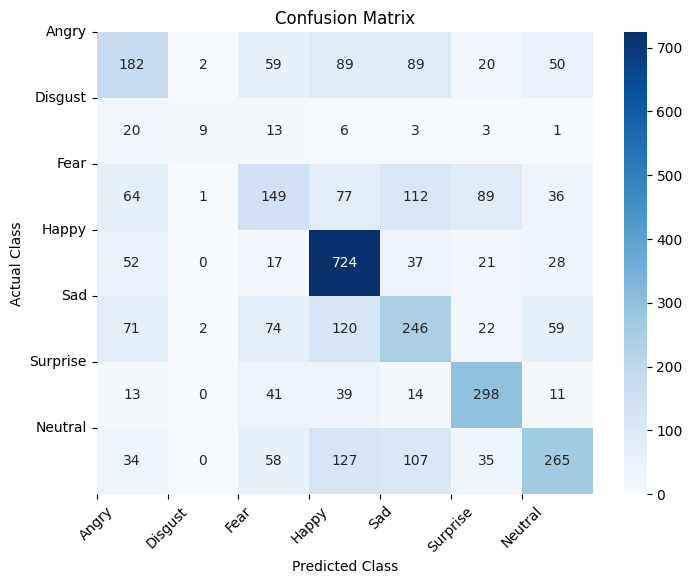

100%|██████████| 113/113 [00:01<00:00, 84.50it/s]


epoch:   6 | Train acc: 61.36 | Val acc: 49.90 | Train loss: 1.0491 | Val loss: 1.3263 | Confusion matrix: [[ 58   1 121  57 126  25  79]
 [  3  11  13   6  16   1   6]
 [ 11   0 166  52 118  53  96]
 [  8   0  44 665  75  21  82]
 [ 13   0 102  57 313  16 152]
 [  5   0  56  22  30 264  38]
 [  7   1  30  87 161   7 314]]


100%|██████████| 113/113 [00:01<00:00, 85.92it/s]


epoch:   7 | Train acc: 63.59 | Val acc: 52.66 | Train loss: 0.9899 | Val loss: 1.2654 | Confusion matrix: [[117   8  85  57 114  18  68]
 [  7  22   9   3  12   0   3]
 [ 23   6 183  45 117  49  73]
 [ 28   4  29 667  69  15  83]
 [ 26   6  93  80 329   9 110]
 [  7   3  73  28  17 266  21]
 [ 23   2  51  80 131  14 306]]
overwriting the best model!
epoch:   7 | Test acc: 52.49 | Test loss: 1.2519 | Test Confusion matrix: [[120   7  94  66 123  14  67]
 [  4  23   8   4  12   1   3]
 [ 24   6 197  46 138  45  72]
 [ 23   4  42 659  79  18  54]
 [ 26   7  83  66 290   8 114]
 [  2   4  69  35  19 268  19]
 [ 23   2  61  64 134  15 327]]


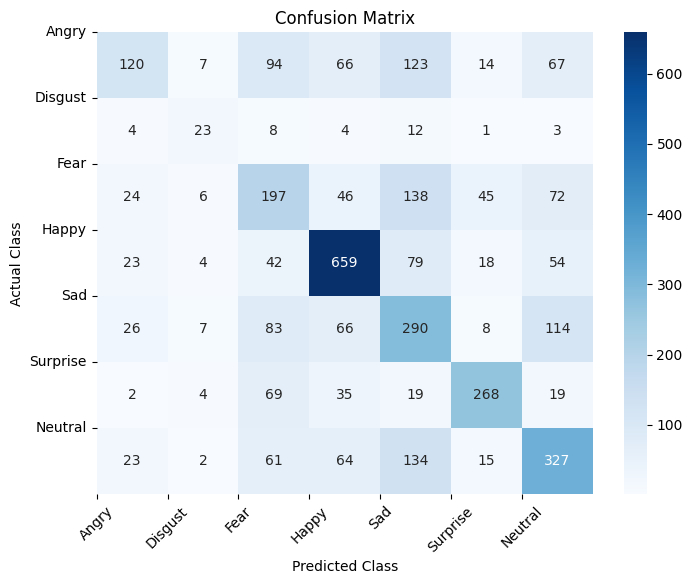

100%|██████████| 113/113 [00:01<00:00, 85.23it/s]


epoch:   8 | Train acc: 66.36 | Val acc: 51.41 | Train loss: 0.9349 | Val loss: 1.3077 | Confusion matrix: [[164   2  45  51 144   6  55]
 [ 17  13   5   2  15   0   4]
 [ 44   1 144  37 179  31  60]
 [ 45   1  26 637 113  15  58]
 [ 61   0  60  50 381   6  95]
 [ 29   1  74  25  37 225  24]
 [ 66   0  33  51 168   8 281]]


100%|██████████| 113/113 [00:01<00:00, 86.08it/s]


epoch:   9 | Train acc: 68.26 | Val acc: 53.05 | Train loss: 0.8859 | Val loss: 1.2901 | Confusion matrix: [[206   9  50  46  72  32  52]
 [ 10  27   4   4   8   1   2]
 [ 58   6 136  32 117  81  66]
 [ 39   6  17 635  49  57  92]
 [112   8  63  51 289  31  99]
 [ 19   1  21  16  27 320  11]
 [ 79   6  33  66 113  19 291]]
overwriting the best model!
epoch:   9 | Test acc: 53.55 | Test loss: 1.2849 | Test Confusion matrix: [[228   7  41  49  80  33  53]
 [ 11  27   4   5   3   3   2]
 [ 75  10 153  42 119  90  39]
 [ 44   3  27 635  63  36  71]
 [102   7  54  52 247  38  94]
 [ 10   4  23  20  14 332  13]
 [ 79   5  61  62  95  24 300]]


100%|██████████| 113/113 [00:01<00:00, 83.38it/s]


epoch:  10 | Train acc: 70.61 | Val acc: 53.75 | Train loss: 0.8433 | Val loss: 1.2904 | Confusion matrix: [[178   4  39  75  54  25  92]
 [ 14  21   3   5   3   1   9]
 [ 49   3 152  57  72  47 116]
 [ 23   1  20 706  36  17  92]
 [ 83   3  75  70 197  21 204]
 [  8   0  42  33  12 293  27]
 [ 47   0  35  64  63  16 382]]
overwriting the best model!
epoch:  10 | Test acc: 54.67 | Test loss: 1.2754 | Test Confusion matrix: [[195   5  35  76  49  18 113]
 [ 16  23   2   6   2   1   5]
 [ 63   4 168  60  70  58 105]
 [ 22   0  27 703  38  18  71]
 [ 78   2  58  80 185  21 170]
 [  8   1  59  29  14 275  30]
 [ 42   0  35  76  47  13 413]]


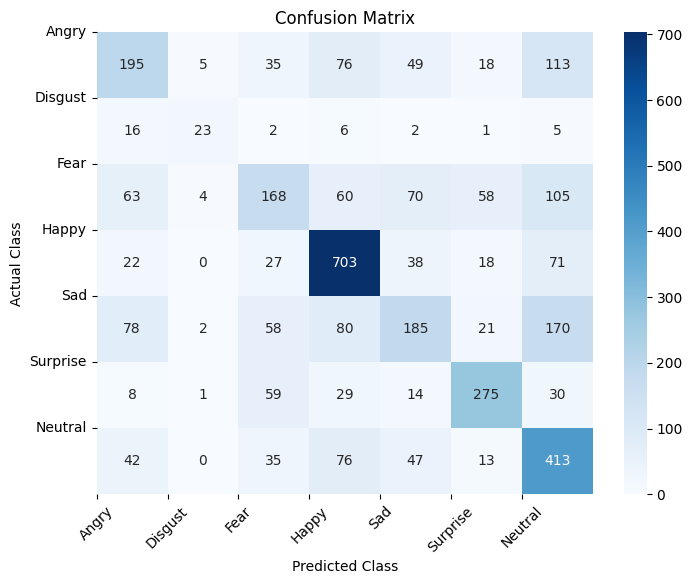

100%|██████████| 113/113 [00:01<00:00, 84.30it/s]


epoch:  11 | Train acc: 72.43 | Val acc: 54.56 | Train loss: 0.7985 | Val loss: 1.2847 | Confusion matrix: [[178   2  68  63  75  16  65]
 [ 10  20   8   7   6   0   5]
 [ 53   3 166  46 109  45  74]
 [ 35   4  30 678  48  14  86]
 [ 62   1  79  61 309  12 129]
 [ 20   0  38  21  21 285  30]
 [ 37   3  46  67 123   9 322]]
overwriting the best model!
epoch:  11 | Test acc: 54.03 | Test loss: 1.2647 | Test Confusion matrix: [[198   4  54  50  96  15  74]
 [  8  24   6   6   7   1   3]
 [ 60   4 182  39 109  59  75]
 [ 25   1  27 662  64  12  88]
 [ 67   0  69  59 268  18 113]
 [ 16   0  49  35  21 271  24]
 [ 38   0  57  64 119  14 334]]


100%|██████████| 113/113 [00:01<00:00, 79.79it/s]


epoch:  12 | Train acc: 73.85 | Val acc: 52.16 | Train loss: 0.7655 | Val loss: 1.3599 | Confusion matrix: [[200   0  52  47  96  12  60]
 [ 20  14   7   2   7   1   5]
 [ 63   0 170  28 129  36  70]
 [ 54   0  33 630  74  19  85]
 [ 78   0  91  44 312   9 119]
 [ 25   0  58  21  29 250  32]
 [ 62   0  50  53 131  15 296]]


100%|██████████| 113/113 [00:01<00:00, 84.63it/s]


epoch:  13 | Train acc: 74.83 | Val acc: 52.88 | Train loss: 0.7420 | Val loss: 1.3101 | Confusion matrix: [[195   8  68  53  72  17  54]
 [ 13  24   5   2   6   0   6]
 [ 73   3 176  43  94  39  68]
 [ 56   4  34 654  44  28  75]
 [ 97   6 104  55 253  13 125]
 [ 16   1  54  15  14 290  25]
 [ 77   1  50  59 102  12 306]]


100%|██████████| 113/113 [00:01<00:00, 86.31it/s]


epoch:  14 | Train acc: 76.28 | Val acc: 52.30 | Train loss: 0.7106 | Val loss: 1.3525 | Confusion matrix: [[199  11  73  42  72  21  49]
 [ 14  24   8   3   3   0   4]
 [ 63   5 175  36  87  66  64]
 [ 46   5  31 647  72  37  57]
 [ 81  11 132  59 250  23  97]
 [ 16   0  51  12  13 303  20]
 [ 63   6  75  65 106  13 279]]


100%|██████████| 113/113 [00:01<00:00, 86.15it/s]


epoch:  15 | Train acc: 77.49 | Val acc: 51.07 | Train loss: 0.6741 | Val loss: 1.4628 | Confusion matrix: [[227   4  53  52  35  16  80]
 [ 13  22   9   3   2   1   6]
 [ 95   6 153  55  47  63  77]
 [ 45   8  40 661  22  31  88]
 [122  13 128  74 144  37 135]
 [ 24   1  39  26   1 308  16]
 [ 61   2  67  70  56  33 318]]


100%|██████████| 113/113 [00:01<00:00, 88.83it/s]


epoch:  16 | Train acc: 78.61 | Val acc: 52.58 | Train loss: 0.6455 | Val loss: 1.4246 | Confusion matrix: [[173   5  45  41  98  44  61]
 [ 10  24   4   2   6   3   7]
 [ 48   0 157  26 125  76  64]
 [ 43   3  26 642  67  53  61]
 [ 78   5  83  55 294  38 100]
 [  6   1  36  16  21 322  13]
 [ 37   0  54  62 135  44 275]]


100%|██████████| 113/113 [00:01<00:00, 85.69it/s]


epoch:  17 | Train acc: 79.83 | Val acc: 53.08 | Train loss: 0.6094 | Val loss: 1.4024 | Confusion matrix: [[187   5  70  65  75  19  46]
 [ 12  23   8   5   6   1   1]
 [ 53   2 185  50 101  51  54]
 [ 40   2  30 708  54  21  40]
 [ 74   5 115  83 278  16  82]
 [ 20   2  43  37  17 273  23]
 [ 56   0  60 106 120  14 251]]


100%|██████████| 113/113 [00:01<00:00, 84.86it/s]


epoch:  18 | Train acc: 88.64 | Val acc: 55.00 | Train loss: 0.3869 | Val loss: 1.4439 | Confusion matrix: [[208   4  62  45  79  19  50]
 [ 15  24   5   3   6   1   2]
 [ 53   3 187  35 114  52  52]
 [ 43   1  30 690  54  24  53]
 [ 87   4 104  69 284  20  85]
 [ 22   0  37  18  16 303  19]
 [ 54   0  53  70 131  21 278]]
overwriting the best model!
epoch:  18 | Test acc: 55.17 | Test loss: 1.4049 | Test Confusion matrix: [[229   2  73  46  71  15  55]
 [ 12  27   3   4   4   2   3]
 [ 57   5 217  40 109  56  44]
 [ 40   3  33 677  56  19  51]
 [ 74   2 118  57 254  15  74]
 [ 11   3  45  29  19 294  15]
 [ 57   1  72  75 123  16 282]]


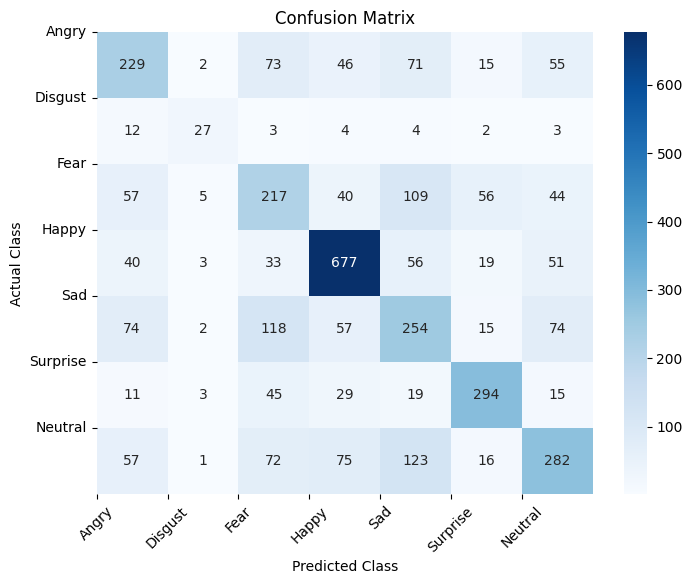

100%|██████████| 113/113 [00:01<00:00, 85.75it/s]


epoch:  19 | Train acc: 92.31 | Val acc: 54.36 | Train loss: 0.2819 | Val loss: 1.4909 | Confusion matrix: [[229   1  50  38  85  22  42]
 [ 13  23   4   3  11   0   2]
 [ 55   3 183  33 120  51  51]
 [ 46   0  28 651  71  33  66]
 [103   3  86  46 317  17  81]
 [ 21   0  45  15  23 292  19]
 [ 63   1  50  59 159  19 256]]


100%|██████████| 113/113 [00:01<00:00, 86.41it/s]


epoch:  20 | Train acc: 94.08 | Val acc: 55.45 | Train loss: 0.2284 | Val loss: 1.5417 | Confusion matrix: [[211   0  42  43  75  21  75]
 [ 13  23   7   4   5   0   4]
 [ 51   0 179  37 109  45  75]
 [ 38   1  21 657  61  26  91]
 [ 90   2  77  37 291  16 140]
 [ 19   0  45  17  22 285  27]
 [ 53   0  42  62  93  13 344]]
overwriting the best model!
epoch:  20 | Test acc: 56.62 | Test loss: 1.4997 | Test Confusion matrix: [[230   1  57  40  76  11  76]
 [ 14  25   3   3   4   1   5]
 [ 60   3 228  29  93  41  74]
 [ 40   4  32 648  58  19  78]
 [ 72   5  79  41 264  11 122]
 [ 15   2  55  21  23 280  20]
 [ 52   1  55  47 107   7 357]]


100%|██████████| 113/113 [00:01<00:00, 82.67it/s]


epoch:  21 | Train acc: 95.03 | Val acc: 54.50 | Train loss: 0.1927 | Val loss: 1.6033 | Confusion matrix: [[206   2  57  56  82  23  41]
 [ 11  24   6   6   7   0   2]
 [ 53   1 186  43 115  49  49]
 [ 35   2  28 691  49  33  57]
 [100   4  95  53 293  19  89]
 [ 18   0  40  19  24 296  18]
 [ 68   0  53  70 136  20 260]]


100%|██████████| 113/113 [00:01<00:00, 83.92it/s]


epoch:  22 | Train acc: 95.90 | Val acc: 54.17 | Train loss: 0.1653 | Val loss: 1.6471 | Confusion matrix: [[232   2  50  44  74  16  49]
 [ 13  24   5   2   7   2   3]
 [ 58   2 184  32 107  54  59]
 [ 38   1  41 648  55  35  77]
 [106   3  97  45 286  21  95]
 [ 19   0  36  20  26 294  20]
 [ 69   3  56  63 123  17 276]]


100%|██████████| 113/113 [00:01<00:00, 85.64it/s]


epoch:  23 | Train acc: 96.73 | Val acc: 55.25 | Train loss: 0.1404 | Val loss: 1.6860 | Confusion matrix: [[228   1  52  42  71  19  54]
 [ 16  23   4   2   5   2   4]
 [ 62   1 174  33 109  49  68]
 [ 47   0  33 657  51  31  76]
 [ 97   3  86  49 308  20  90]
 [ 19   0  35  18  26 293  24]
 [ 69   2  48  63 111  14 300]]


100%|██████████| 113/113 [00:01<00:00, 85.15it/s]


epoch:  24 | Train acc: 97.02 | Val acc: 55.08 | Train loss: 0.1285 | Val loss: 1.6876 | Confusion matrix: [[222   2  58  42  74  17  52]
 [ 14  23   6   4   6   0   3]
 [ 55   0 189  37 115  33  67]
 [ 40   1  28 670  52  22  82]
 [ 99   4  93  49 281  16 111]
 [ 16   0  44  23  25 281  26]
 [ 52   2  60  66 104  12 311]]


100%|██████████| 113/113 [00:01<00:00, 83.80it/s]


epoch:  25 | Train acc: 97.47 | Val acc: 55.31 | Train loss: 0.1133 | Val loss: 1.7248 | Confusion matrix: [[205   3  52  52  74  21  60]
 [ 12  26   2   9   6   0   1]
 [ 60   1 173  44 106  45  67]
 [ 37   1  16 702  36  27  76]
 [102   6  69  66 275  14 121]
 [ 21   0  28  26  27 291  22]
 [ 48   1  36  76 122  11 313]]


100%|██████████| 113/113 [00:01<00:00, 83.09it/s]


epoch:  26 | Train acc: 97.63 | Val acc: 53.72 | Train loss: 0.1050 | Val loss: 1.8183 | Confusion matrix: [[206   2  79  42  78  21  39]
 [ 19  20   6   4   4   1   2]
 [ 62   0 207  35 113  37  42]
 [ 42   0  38 671  50  23  71]
 [101   4 113  49 283  22  81]
 [ 15   0  49  24  26 283  18]
 [ 72   2  82  57 119  17 258]]


100%|██████████| 113/113 [00:01<00:00, 84.51it/s]


epoch:  27 | Train acc: 98.30 | Val acc: 55.36 | Train loss: 0.0841 | Val loss: 1.7827 | Confusion matrix: [[202   1  68  48  72  21  55]
 [ 13  22   5   5   6   1   4]
 [ 59   0 186  37 112  45  57]
 [ 35   0  29 674  51  30  76]
 [ 87   4  86  52 297  20 107]
 [ 15   0  41  24  23 294  18]
 [ 52   1  58  59 110  15 312]]


100%|██████████| 113/113 [00:01<00:00, 87.42it/s]


epoch:  28 | Train acc: 98.76 | Val acc: 54.78 | Train loss: 0.0713 | Val loss: 1.7609 | Confusion matrix: [[217   1  62  43  77  20  47]
 [ 15  22   6   4   6   1   2]
 [ 67   0 180  35 118  45  51]
 [ 50   0  28 667  47  27  76]
 [ 99   5  93  45 301  21  89]
 [ 14   0  38  23  27 292  21]
 [ 62   2  61  62 117  16 287]]


100%|██████████| 113/113 [00:01<00:00, 82.87it/s]


epoch:  29 | Train acc: 99.06 | Val acc: 54.86 | Train loss: 0.0604 | Val loss: 1.7822 | Confusion matrix: [[211   1  69  54  64  18  50]
 [ 15  22   7   5   3   1   3]
 [ 64   0 192  43 103  38  56]
 [ 42   0  28 697  40  23  65]
 [ 92   3 111  62 271  16  98]
 [ 16   0  45  25  23 284  22]
 [ 62   1  70  71 100  11 292]]


100%|██████████| 113/113 [00:01<00:00, 79.09it/s]


epoch:  30 | Train acc: 99.11 | Val acc: 55.22 | Train loss: 0.0574 | Val loss: 1.7885 | Confusion matrix: [[204   2  65  49  69  20  58]
 [ 14  22   4   5   6   1   4]
 [ 55   0 189  43 106  41  62]
 [ 34   1  26 692  47  25  70]
 [ 79   3 104  52 285  19 111]
 [ 14   0  44  23  25 283  26]
 [ 56   1  65  66 100  12 307]]


100%|██████████| 113/113 [00:01<00:00, 71.36it/s]


epoch:  31 | Train acc: 99.25 | Val acc: 55.56 | Train loss: 0.0520 | Val loss: 1.8143 | Confusion matrix: [[221   2  58  43  63  20  60]
 [ 14  23   4   5   5   0   5]
 [ 66   0 174  41 111  45  59]
 [ 44   1  17 684  43  27  79]
 [101   4  85  48 285  20 110]
 [ 16   0  35  22  22 292  28]
 [ 63   2  54  61  97  15 315]]
overwriting the best model!
epoch:  31 | Test acc: 56.56 | Test loss: 1.7593 | Test Confusion matrix: [[242   0  65  39  75   9  61]
 [  9  28   4   3   6   1   4]
 [ 69   2 217  28  91  46  75]
 [ 32   7  36 665  51  16  72]
 [ 78   3  94  53 252  10 104]
 [ 17   3  43  25  20 289  19]
 [ 50   0  58  63 107  11 337]]


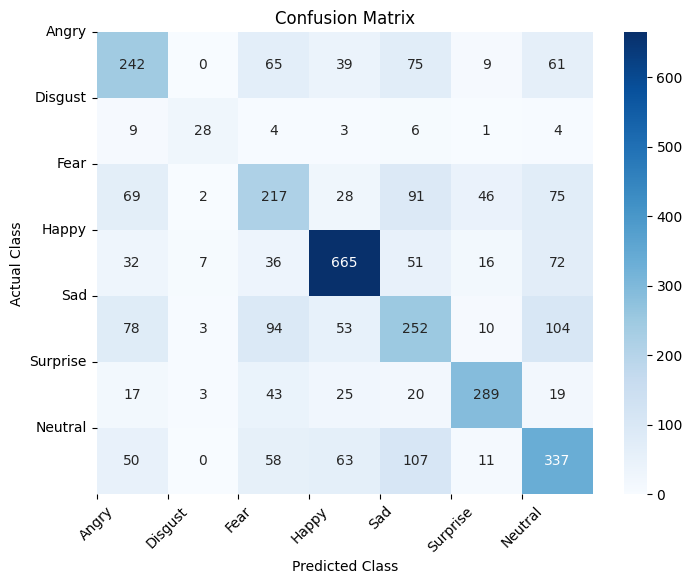

100%|██████████| 113/113 [00:01<00:00, 85.08it/s]


epoch:  32 | Train acc: 99.29 | Val acc: 55.42 | Train loss: 0.0497 | Val loss: 1.8090 | Confusion matrix: [[212   1  59  41  78  19  57]
 [ 16  22   4   4   7   0   3]
 [ 56   0 193  32 116  40  59]
 [ 42   1  30 663  50  23  86]
 [ 81   3 101  46 306  14 102]
 [ 14   0  46  20  26 283  26]
 [ 52   1  64  57 111  12 310]]


100%|██████████| 113/113 [00:01<00:00, 82.10it/s]


epoch:  33 | Train acc: 99.31 | Val acc: 54.95 | Train loss: 0.0491 | Val loss: 1.8482 | Confusion matrix: [[230   2  50  51  68  18  48]
 [ 17  22   4   7   4   1   1]
 [ 73   0 182  39 105  45  52]
 [ 50   1  20 680  47  28  69]
 [110   6  88  53 281  21  94]
 [ 23   0  34  24  24 290  20]
 [ 76   2  58  66 106  12 287]]


100%|██████████| 113/113 [00:01<00:00, 83.49it/s]


epoch:  34 | Train acc: 99.42 | Val acc: 55.25 | Train loss: 0.0459 | Val loss: 1.8151 | Confusion matrix: [[207   0  61  49  68  22  60]
 [ 14  21   6   6   5   2   2]
 [ 49   0 194  48 103  42  60]
 [ 36   1  28 681  43  27  79]
 [ 83   5  97  54 285  23 106]
 [ 19   0  43  22  20 290  21]
 [ 53   1  66  67  97  18 305]]


100%|██████████| 113/113 [00:01<00:00, 84.55it/s]


epoch:  35 | Train acc: 99.45 | Val acc: 55.42 | Train loss: 0.0431 | Val loss: 1.8447 | Confusion matrix: [[234   0  59  39  64  20  51]
 [ 16  23   6   4   5   0   2]
 [ 70   0 197  38 101  35  55]
 [ 55   1  23 674  41  25  76]
 [105   4 100  43 280  19 102]
 [ 21   0  43  21  20 285  25]
 [ 71   2  62  64 100  12 296]]


100%|██████████| 113/113 [00:01<00:00, 85.37it/s]


epoch:  36 | Train acc: 99.44 | Val acc: 54.72 | Train loss: 0.0440 | Val loss: 1.8694 | Confusion matrix: [[238   0  41  40  67  19  62]
 [ 18  21   5   3   6   0   3]
 [ 72   1 171  31 112  44  65]
 [ 57   0  19 659  47  29  84]
 [109   3  86  40 288  20 107]
 [ 21   0  34  20  23 291  26]
 [ 71   1  51  59 115  14 296]]


100%|██████████| 113/113 [00:01<00:00, 87.74it/s]


epoch:  37 | Train acc: 99.49 | Val acc: 54.86 | Train loss: 0.0406 | Val loss: 1.8598 | Confusion matrix: [[211   0  64  44  63  18  67]
 [ 14  24   3   5   5   0   5]
 [ 57   0 188  33 110  45  63]
 [ 45   0  31 658  44  27  90]
 [ 89   3 106  37 288  19 111]
 [ 19   0  41  20  20 290  25]
 [ 54   1  65  59 106  12 310]]


100%|██████████| 113/113 [00:01<00:00, 85.39it/s]


epoch:  38 | Train acc: 99.54 | Val acc: 54.95 | Train loss: 0.0386 | Val loss: 1.8722 | Confusion matrix: [[223   0  50  37  77  20  60]
 [ 15  22   4   5   6   2   2]
 [ 64   0 178  31 114  47  62]
 [ 54   0  22 655  55  29  80]
 [ 97   3  87  35 305  23 103]
 [ 17   0  34  19  25 297  23]
 [ 64   1  54  59 120  17 292]]


100%|██████████| 113/113 [00:01<00:00, 84.84it/s]


epoch:  39 | Train acc: 99.56 | Val acc: 55.39 | Train loss: 0.0378 | Val loss: 1.8523 | Confusion matrix: [[220   0  52  48  69  22  56]
 [ 16  22   4   5   5   1   3]
 [ 60   0 178  37 114  46  61]
 [ 45   0  19 675  52  31  73]
 [ 92   3  89  49 301  22  97]
 [ 18   0  35  22  23 295  22]
 [ 63   1  53  64 114  15 297]]


100%|██████████| 113/113 [00:01<00:00, 84.73it/s]


epoch:  40 | Train acc: 99.61 | Val acc: 55.00 | Train loss: 0.0354 | Val loss: 1.8801 | Confusion matrix: [[228   0  62  39  62  16  60]
 [ 17  24   3   5   4   0   3]
 [ 68   1 191  32 105  38  61]
 [ 57   0  34 657  44  25  78]
 [110   3  94  38 288  16 104]
 [ 24   0  43  21  21 282  24]
 [ 68   1  60  57 106  11 304]]


100%|██████████| 113/113 [00:01<00:00, 86.84it/s]


epoch:  41 | Train acc: 99.61 | Val acc: 55.50 | Train loss: 0.0367 | Val loss: 1.8403 | Confusion matrix: [[208   0  59  47  71  18  64]
 [ 13  23   3   5   8   0   4]
 [ 54   0 186  37 111  44  64]
 [ 36   0  23 683  51  26  76]
 [ 81   3  92  50 302  19 106]
 [ 15   0  43  23  24 286  24]
 [ 53   1  55  62 121  11 304]]


100%|██████████| 113/113 [00:01<00:00, 88.14it/s]


epoch:  42 | Train acc: 99.57 | Val acc: 55.67 | Train loss: 0.0361 | Val loss: 1.8554 | Confusion matrix: [[219   0  56  53  64  17  58]
 [ 15  24   4   5   5   0   3]
 [ 59   1 184  46 104  44  58]
 [ 37   0  19 702  41  24  72]
 [ 91   4  83  64 290  18 103]
 [ 20   0  40  27  21 284  23]
 [ 63   1  56  71 110  11 295]]
overwriting the best model!
epoch:  42 | Test acc: 55.78 | Test loss: 1.8179 | Test Confusion matrix: [[231   2  57  53  79   9  60]
 [ 11  28   3   3   5   1   4]
 [ 71   3 218  37  98  39  62]
 [ 27   7  35 677  51  16  66]
 [ 68   5  99  62 251   9 100]
 [ 18   3  49  27  20 281  18]
 [ 51   0  54  79 116  10 316]]


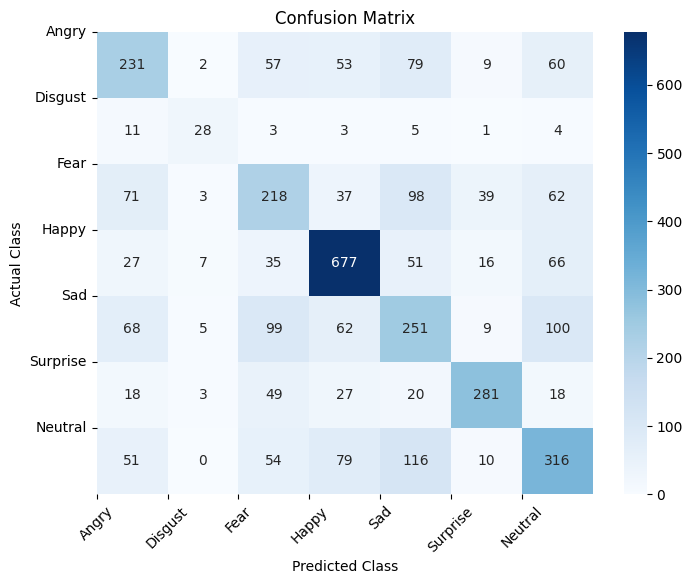

100%|██████████| 113/113 [00:01<00:00, 84.95it/s]


epoch:  43 | Train acc: 99.59 | Val acc: 55.45 | Train loss: 0.0357 | Val loss: 1.8598 | Confusion matrix: [[223   0  60  48  63  19  54]
 [ 14  24   5   5   5   1   2]
 [ 63   0 188  39 101  48  57]
 [ 45   0  23 684  44  31  68]
 [ 94   4 101  52 284  24  94]
 [ 18   0  38  23  21 292  23]
 [ 64   1  65  66 101  15 295]]


100%|██████████| 113/113 [00:01<00:00, 85.64it/s]


epoch:  44 | Train acc: 99.66 | Val acc: 55.34 | Train loss: 0.0335 | Val loss: 1.8404 | Confusion matrix: [[222   0  59  45  66  18  57]
 [ 15  23   4   5   6   0   3]
 [ 60   0 192  37 105  41  61]
 [ 47   0  26 682  42  24  74]
 [ 96   4  97  47 291  18 100]
 [ 21   0  43  22  22 284  23]
 [ 64   1  65  64 109  12 292]]


100%|██████████| 113/113 [00:01<00:00, 87.99it/s]


epoch:  45 | Train acc: 99.63 | Val acc: 55.11 | Train loss: 0.0339 | Val loss: 1.8499 | Confusion matrix: [[212   0  60  45  65  20  65]
 [ 16  23   4   5   3   0   5]
 [ 60   0 194  37  99  44  62]
 [ 39   0  27 673  41  29  86]
 [ 89   4 100  47 277  20 116]
 [ 16   0  43  22  20 289  25]
 [ 60   1  66  63  93  14 310]]


100%|██████████| 113/113 [00:01<00:00, 87.80it/s]


epoch:  46 | Train acc: 99.62 | Val acc: 55.14 | Train loss: 0.0344 | Val loss: 1.8789 | Confusion matrix: [[230   0  51  54  60  19  53]
 [ 16  23   3   5   4   1   4]
 [ 69   0 175  41  98  51  62]
 [ 47   0  18 691  38  30  71]
 [103   3  84  61 273  24 105]
 [ 22   0  34  23  20 294  22]
 [ 70   1  57  70  97  19 293]]


100%|██████████| 113/113 [00:01<00:00, 84.85it/s]


epoch:  47 | Train acc: 99.62 | Val acc: 55.36 | Train loss: 0.0343 | Val loss: 1.8758 | Confusion matrix: [[220   0  53  49  69  18  58]
 [ 15  23   3   5   6   0   4]
 [ 61   0 183  37 107  46  62]
 [ 45   0  22 679  45  28  76]
 [ 95   4  85  47 297  22 103]
 [ 19   0  33  23  23 292  25]
 [ 62   1  57  64 117  13 293]]


100%|██████████| 113/113 [00:01<00:00, 85.78it/s]


epoch:  48 | Train acc: 99.67 | Val acc: 55.45 | Train loss: 0.0325 | Val loss: 1.8572 | Confusion matrix: [[212   0  49  45  81  19  61]
 [ 16  21   4   5   6   0   4]
 [ 59   0 181  35 114  45  62]
 [ 40   0  22 670  52  31  80]
 [ 83   4  83  46 308  22 107]
 [ 15   0  35  22  25 293  25]
 [ 56   1  52  61 119  13 305]]


100%|██████████| 113/113 [00:01<00:00, 86.52it/s]


epoch:  49 | Train acc: 99.67 | Val acc: 54.81 | Train loss: 0.0331 | Val loss: 1.8652 | Confusion matrix: [[225   0  53  43  75  19  52]
 [ 17  22   4   4   6   0   3]
 [ 57   0 186  36 117  46  54]
 [ 48   1  26 664  52  32  72]
 [ 94   4  94  45 300  22  94]
 [ 22   0  38  21  22 291  21]
 [ 70   1  59  62 122  14 279]]


100%|██████████| 113/113 [00:01<00:00, 87.85it/s]


epoch:  50 | Train acc: 99.66 | Val acc: 55.28 | Train loss: 0.0321 | Val loss: 1.8477 | Confusion matrix: [[218   0  58  53  63  16  59]
 [ 16  22   5   5   4   0   4]
 [ 63   0 190  40 103  41  59]
 [ 39   0  27 692  38  26  73]
 [ 91   3 101  58 281  17 102]
 [ 17   0  47  23  19 285  24]
 [ 61   1  69  67 102  11 296]]


100%|██████████| 113/113 [00:01<00:00, 86.80it/s]


epoch:  51 | Train acc: 99.66 | Val acc: 55.28 | Train loss: 0.0314 | Val loss: 1.8597 | Confusion matrix: [[228   1  52  46  66  17  57]
 [ 17  21   4   6   5   0   3]
 [ 67   0 184  37 105  41  62]
 [ 49   0  20 678  46  26  76]
 [100   3  87  50 287  18 108]
 [ 22   0  39  23  20 287  24]
 [ 70   1  57  65 102  13 299]]


100%|██████████| 113/113 [00:01<00:00, 85.80it/s]


epoch:  52 | Train acc: 99.68 | Val acc: 54.78 | Train loss: 0.0311 | Val loss: 1.8767 | Confusion matrix: [[221   0  60  42  64  19  61]
 [ 18  21   5   4   5   0   3]
 [ 62   0 193  32 103  46  60]
 [ 44   0  31 663  46  30  81]
 [ 93   3 108  41 283  18 107]
 [ 19   0  43  21  20 290  22]
 [ 66   1  67  60 106  12 295]]


100%|██████████| 113/113 [00:01<00:00, 88.98it/s]


epoch:  53 | Train acc: 99.68 | Val acc: 55.50 | Train loss: 0.0309 | Val loss: 1.8637 | Confusion matrix: [[229   0  47  45  68  17  61]
 [ 17  21   4   5   4   0   5]
 [ 64   0 172  34 111  50  65]
 [ 48   0  17 674  43  29  84]
 [102   3  73  45 296  21 113]
 [ 21   0  31  22  22 294  25]
 [ 72   1  46  62 107  13 306]]


100%|██████████| 113/113 [00:01<00:00, 83.69it/s]


epoch:  54 | Train acc: 99.68 | Val acc: 55.22 | Train loss: 0.0308 | Val loss: 1.8758 | Confusion matrix: [[228   0  52  53  57  19  58]
 [ 17  23   4   6   4   0   2]
 [ 68   1 183  41 100  44  59]
 [ 44   0  20 689  37  30  75]
 [103   3  88  58 272  21 108]
 [ 23   0  36  22  20 292  22]
 [ 73   1  58  71  95  14 295]]


100%|██████████| 113/113 [00:01<00:00, 86.82it/s]


epoch:  55 | Train acc: 99.70 | Val acc: 55.08 | Train loss: 0.0312 | Val loss: 1.8585 | Confusion matrix: [[221   0  53  51  72  16  54]
 [ 18  21   5   6   4   0   2]
 [ 65   0 190  39 105  41  56]
 [ 44   0  22 684  44  26  75]
 [100   2  93  53 287  15 103]
 [ 19   0  42  25  21 284  24]
 [ 71   1  59  66 108  12 290]]


100%|██████████| 113/113 [00:01<00:00, 83.85it/s]


epoch:  56 | Train acc: 99.70 | Val acc: 55.39 | Train loss: 0.0299 | Val loss: 1.8498 | Confusion matrix: [[218   0  53  45  76  19  56]
 [ 15  22   4   5   6   0   4]
 [ 58   0 185  34 112  47  60]
 [ 43   0  21 672  50  31  78]
 [ 89   3  92  45 303  21 100]
 [ 15   0  35  22  24 295  24]
 [ 59   1  58  64 118  14 293]]


100%|██████████| 113/113 [00:01<00:00, 84.57it/s]


epoch:  57 | Train acc: 99.69 | Val acc: 54.58 | Train loss: 0.0309 | Val loss: 1.8806 | Confusion matrix: [[232   0  59  44  67  19  46]
 [ 20  21   5   4   4   1   1]
 [ 69   0 188  35 106  46  52]
 [ 54   0  26 678  44  28  65]
 [113   3 101  50 280  22  84]
 [ 23   0  40  22  21 291  18]
 [ 84   1  68  68 102  15 269]]
epoch:  57 | Test acc: 55.81 | Test loss: 1.8249 | Test Confusion matrix: [[257   1  66  39  69   9  50]
 [ 13  27   3   3   5   1   3]
 [ 78   2 233  31  94  39  51]
 [ 47   5  44 656  48  19  60]
 [ 96   3 108  51 245  11  80]
 [ 21   3  53  22  17 283  17]
 [ 66   0  64  71 111  12 302]]
Early stopping at epoch 57
epoch:  57 | Test acc: 55.81 | Test loss: 1.8249 | Test Confusion matrix: [[257   1  66  39  69   9  50]
 [ 13  27   3   3   5   1   3]
 [ 78   2 233  31  94  39  51]
 [ 47   5  44 656  48  19  60]
 [ 96   3 108  51 245  11  80]
 [ 21   3  53  22  17 283  17]
 [ 66   0  64  71 111  12 302]]


wandb: Agent Starting Run: 6bdi3lb9 with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.005
wandb: 	weight_decay: 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


device:  cuda:0


  0%|          | 0/898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 113/113 [00:01<00:00, 86.65it/s]


epoch:   1 | Train acc: 35.33 | Val acc: 40.71 | Train loss: 1.6500 | Val loss: 1.5145 | Confusion matrix: [[ 99   0  29  68 166  20  85]
 [ 11   0   5   6  19   0  15]
 [ 53   0  35  55 167  52 134]
 [ 59   0  22 557 191  25  41]
 [ 64   0  37  76 302  20 154]
 [ 16   0  19  32  46 228  74]
 [ 56   0  20  57 221  13 240]]
overwriting the best model!
epoch:   1 | Test acc: 41.21 | Test loss: 1.5274 | Test Confusion matrix: [[107   0  24  53 170  28 109]
 [ 17   0   1   7  16   0  14]
 [ 57   0  45  71 181  62 112]
 [ 56   0  18 565 181  28  31]
 [ 63   0  33  61 294  17 126]
 [ 16   0  35  42  54 192  77]
 [ 39   0  19  68 203  21 276]]


100%|██████████| 113/113 [00:01<00:00, 85.34it/s]


epoch:   2 | Train acc: 46.04 | Val acc: 47.26 | Train loss: 1.3933 | Val loss: 1.3453 | Confusion matrix: [[132   1  20 102 103  12  97]
 [ 29   0   2   6   9   0  10]
 [ 44   0  25 105 115  72 135]
 [ 19   0   8 715  47  13  93]
 [ 62   0  16 134 221  18 202]
 [ 15   0  23  50  23 260  44]
 [ 28   0  11  84 118  23 343]]
overwriting the best model!
epoch:   2 | Test acc: 48.73 | Test loss: 1.3327 | Test Confusion matrix: [[119   0  19  91 134  15 113]
 [ 30   1   2   5   9   3   5]
 [ 54   0  36 106 125  67 140]
 [ 21   0   7 718  48  11  74]
 [ 50   0  16 101 232   7 188]
 [ 11   0  26  54  24 254  47]
 [ 19   0   7 104  91  16 389]]


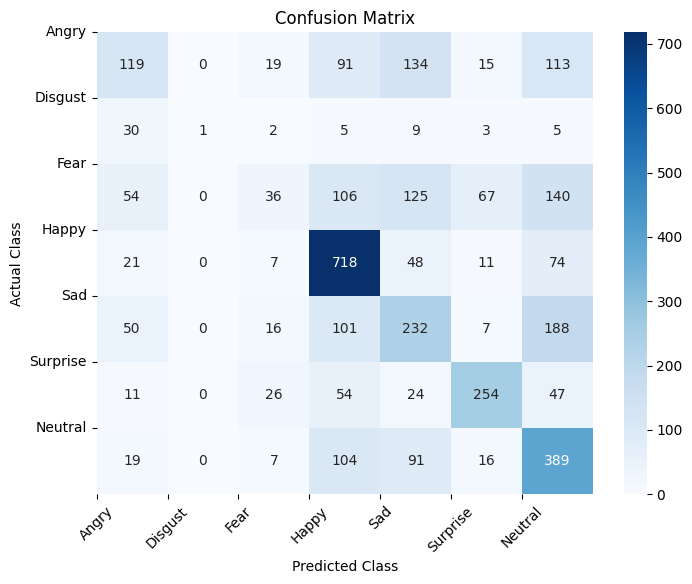

100%|██████████| 113/113 [00:01<00:00, 84.90it/s]


epoch:   3 | Train acc: 51.10 | Val acc: 51.77 | Train loss: 1.2803 | Val loss: 1.2761 | Confusion matrix: [[198   0  20  82  75  13  79]
 [ 26   4   7   8   3   0   8]
 [ 85   0  86  64 110  41 110]
 [ 32   0  14 748  30  10  61]
 [105   0  20 113 244   5 166]
 [ 28   0  47  38  14 245  43]
 [ 68   0  12  97  93   4 333]]
overwriting the best model!
epoch:   3 | Test acc: 51.32 | Test loss: 1.2531 | Test Confusion matrix: [[209   0  27  76  64  14 101]
 [ 27   3   7   6   9   0   3]
 [ 92   0  89  87 114  48  98]
 [ 33   0  12 751  37  13  33]
 [106   0  19  99 206   2 162]
 [ 24   0  61  37  15 233  46]
 [ 67   2  16 102  81   7 351]]


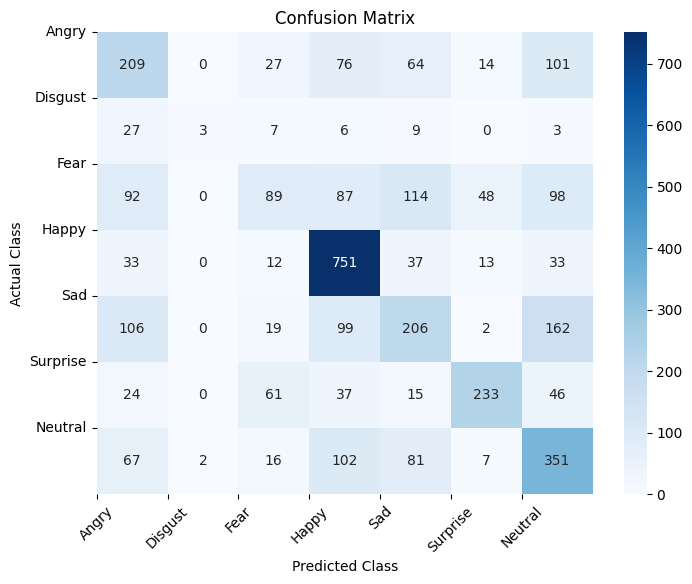

100%|██████████| 113/113 [00:01<00:00, 84.76it/s]


epoch:   4 | Train acc: 54.49 | Val acc: 55.03 | Train loss: 1.2023 | Val loss: 1.1825 | Confusion matrix: [[188   1  19  27 129  18  85]
 [ 17   9   4   3  16   0   7]
 [ 51   0  79  26 172  53 115]
 [ 24   0  15 684  69  27  76]
 [ 52   0  21  44 363  12 161]
 [  9   0  29  17  10 305  45]
 [ 37   1  17  53 142  10 347]]
overwriting the best model!
epoch:   4 | Test acc: 55.34 | Test loss: 1.1709 | Test Confusion matrix: [[204   1  20  27 139  17  83]
 [ 22   3   0   5  21   1   3]
 [ 71   0  77  33 172  72 103]
 [ 33   0  10 688  75  22  51]
 [ 51   0  24  35 326  13 145]
 [ 14   0  32  20  19 294  37]
 [ 33   1   9  50 133   6 394]]


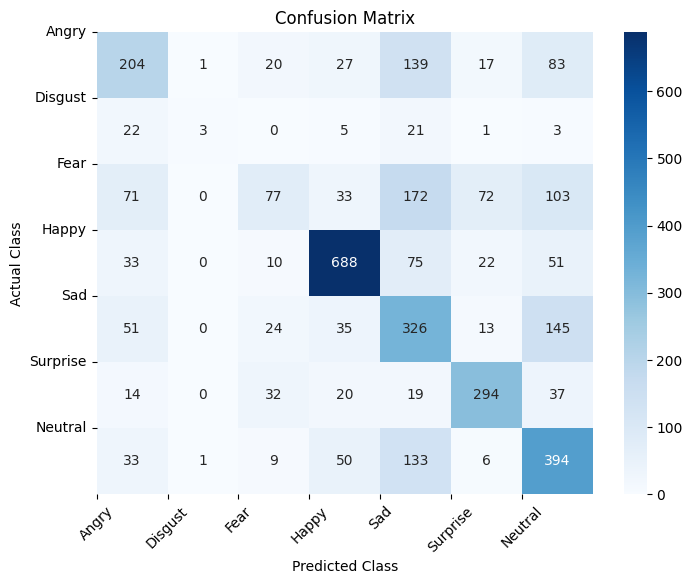

100%|██████████| 113/113 [00:01<00:00, 85.08it/s]


epoch:   5 | Train acc: 56.77 | Val acc: 55.53 | Train loss: 1.1359 | Val loss: 1.1814 | Confusion matrix: [[208   2  43  47  79  17  71]
 [ 16  12   7   6   7   0   8]
 [ 53   2 139  50 122  54  76]
 [ 33   0  14 738  45  19  46]
 [ 82   0  62  71 304  19 115]
 [ 13   0  43  33  14 297  15]
 [ 54   1  32  87 123  15 295]]
overwriting the best model!
epoch:   5 | Test acc: 56.26 | Test loss: 1.1346 | Test Confusion matrix: [[221   4  54  52  73   8  79]
 [ 16   6  16   6   9   1   1]
 [ 67   3 157  48 124  62  67]
 [ 36   0  12 747  40  11  33]
 [ 67   2  62  75 265  12 111]
 [  9   0  57  37  10 283  20]
 [ 42   0  27  74 127  16 340]]


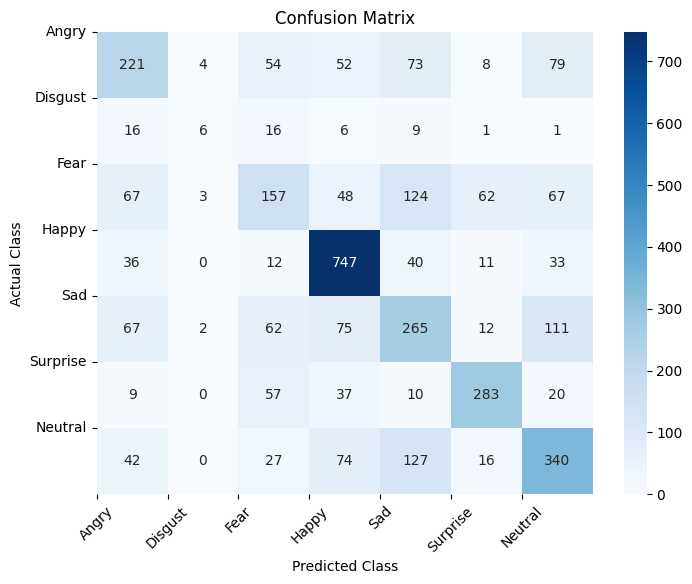

100%|██████████| 113/113 [00:01<00:00, 85.41it/s]


epoch:   6 | Train acc: 59.40 | Val acc: 56.48 | Train loss: 1.0713 | Val loss: 1.1616 | Confusion matrix: [[194   2  36  23 145  13  54]
 [ 10  14   8   1  15   0   8]
 [ 47   0 110  21 200  51  67]
 [ 32   0  21 682  90  16  54]
 [ 50   1  36  36 431  10  89]
 [ 12   0  26  19  26 308  24]
 [ 29   0  21  63 199   7 288]]
overwriting the best model!
epoch:   6 | Test acc: 56.78 | Test loss: 1.1367 | Test Confusion matrix: [[203   3  43  26 135   9  72]
 [ 15   7  11   3  15   2   2]
 [ 47   0 134  32 194  61  60]
 [ 41   1  16 686  91  15  29]
 [ 35   1  36  39 404   5  74]
 [ 10   0  45  26  23 287  25]
 [ 21   0  15  53 212   8 317]]


100%|██████████| 113/113 [00:01<00:00, 81.42it/s]


epoch:   7 | Train acc: 61.81 | Val acc: 56.31 | Train loss: 1.0122 | Val loss: 1.1652 | Confusion matrix: [[200   3  19  55  56  20 114]
 [ 13  15   5   6   5   0  12]
 [ 45   0 113  47  98  59 134]
 [ 15   0   9 755  27  20  69]
 [ 59   1  55  80 245  13 200]
 [ 14   0  25  23   8 311  34]
 [ 28   0  23  89  76   9 382]]


100%|██████████| 113/113 [00:01<00:00, 87.37it/s]


epoch:   8 | Train acc: 64.54 | Val acc: 57.45 | Train loss: 0.9533 | Val loss: 1.1682 | Confusion matrix: [[202   2  26  56  80  13  88]
 [ 20  16   2   4   6   0   8]
 [ 51   1 133  43 145  40  83]
 [ 33   1  10 738  34  16  63]
 [ 75   0  37  59 314   9 159]
 [ 10   0  45  28  17 290  25]
 [ 41   0  21  78  92   6 369]]
overwriting the best model!
epoch:   8 | Test acc: 58.76 | Test loss: 1.1142 | Test Confusion matrix: [[236   5  25  42  88   7  88]
 [ 18  15   1   6   9   1   5]
 [ 62   3 137  47 128  58  93]
 [ 24   0   6 759  38  17  35]
 [ 64   3  38  53 283   8 145]
 [ 15   2  57  27  11 272  32]
 [ 25   1  22  57 106   8 407]]


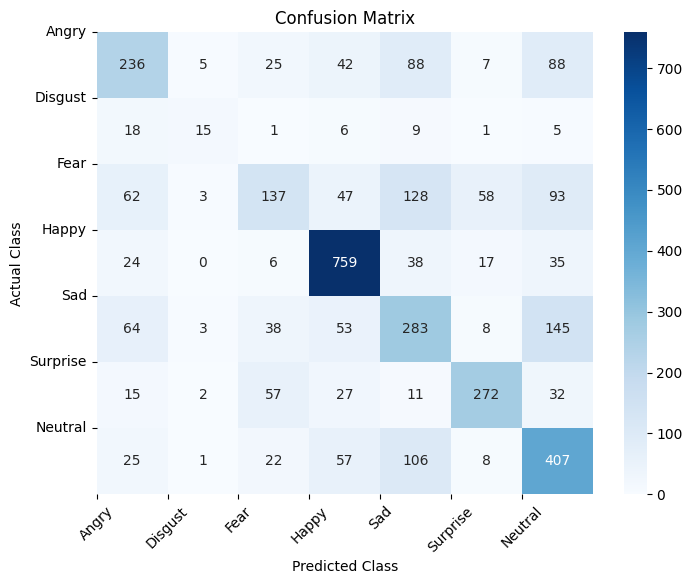

100%|██████████| 113/113 [00:01<00:00, 88.24it/s]


epoch:   9 | Train acc: 66.95 | Val acc: 58.29 | Train loss: 0.8832 | Val loss: 1.1817 | Confusion matrix: [[254   2  61  27  61  11  51]
 [ 22  15   8   3   5   0   3]
 [ 60   0 190  20 128  35  63]
 [ 30   1  27 706  45  22  64]
 [ 99   1  62  35 330  16 110]
 [ 12   0  48  21  22 295  17]
 [ 89   0  36  63 105  12 302]]
overwriting the best model!
epoch:   9 | Test acc: 59.18 | Test loss: 1.1146 | Test Confusion matrix: [[274   2  56  24  77   5  53]
 [ 27  13   4   3   5   2   1]
 [ 64   2 217  21 120  53  51]
 [ 26   0  29 719  55  16  34]
 [ 93   2  65  35 296   8  95]
 [ 14   1  71  24  15 271  20]
 [ 84   0  34  42 120  12 334]]


100%|██████████| 113/113 [00:01<00:00, 88.58it/s]


epoch:  10 | Train acc: 69.72 | Val acc: 58.26 | Train loss: 0.8184 | Val loss: 1.1503 | Confusion matrix: [[230   1  61  25  51  23  76]
 [ 22  19   6   2   3   0   4]
 [ 50   0 207  18  87  52  82]
 [ 35   0  31 702  28  23  76]
 [ 81   0 129  32 245  14 152]
 [  9   0  38  18  10 325  15]
 [ 44   1  60  49  80  10 363]]


100%|██████████| 113/113 [00:01<00:00, 85.14it/s]


epoch:  11 | Train acc: 72.97 | Val acc: 59.01 | Train loss: 0.7419 | Val loss: 1.1785 | Confusion matrix: [[235  10  45  26  89  20  42]
 [  9  26   5   5   7   1   3]
 [ 53   0 175  33 137  64  34]
 [ 38   0  15 734  33  32  43]
 [ 70   8  79  52 351  25  68]
 [ 13   0  21  24  16 329  12]
 [ 52   3  47  81 143  13 268]]
overwriting the best model!
epoch:  11 | Test acc: 60.18 | Test loss: 1.1415 | Test Confusion matrix: [[264  13  53  23  83  14  41]
 [ 13  25   2   4   7   2   2]
 [ 55   5 192  24 140  75  37]
 [ 26   0  18 733  43  24  35]
 [ 66   4  68  52 322  16  66]
 [  6   1  34  24  13 327  11]
 [ 48   1  42  68 145  25 297]]


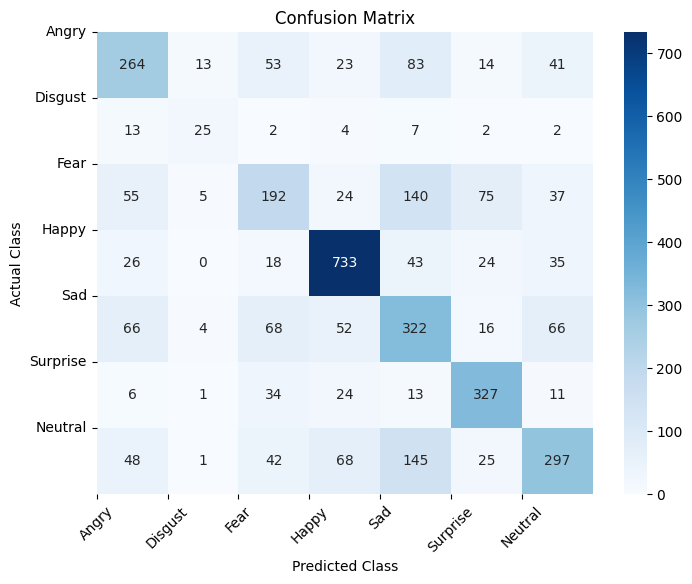

100%|██████████| 113/113 [00:01<00:00, 84.67it/s]


epoch:  12 | Train acc: 75.31 | Val acc: 58.85 | Train loss: 0.6791 | Val loss: 1.2527 | Confusion matrix: [[275   1  32  20  77   9  53]
 [ 24  21   4   3   2   0   2]
 [ 66   0 190  23 113  48  56]
 [ 43   0  27 668  59  19  79]
 [ 93   1  77  30 320   6 126]
 [ 19   2  43  22  12 298  19]
 [ 60   2  46  43 103  13 340]]


100%|██████████| 113/113 [00:01<00:00, 86.25it/s]


epoch:  13 | Train acc: 78.40 | Val acc: 58.93 | Train loss: 0.6060 | Val loss: 1.2762 | Confusion matrix: [[260   6  37  43  57  22  42]
 [ 13  27   7   3   4   0   2]
 [ 55   1 190  44 114  49  43]
 [ 46   0  15 730  32  28  44]
 [105   7  78  50 300  14  99]
 [ 11   1  34  26   9 321  13]
 [ 87   2  46  66 107  12 287]]


100%|██████████| 113/113 [00:01<00:00, 88.52it/s]


epoch:  14 | Train acc: 80.38 | Val acc: 58.37 | Train loss: 0.5437 | Val loss: 1.3620 | Confusion matrix: [[255   8  47  30  38  20  69]
 [ 14  28   5   3   3   0   3]
 [ 54   2 192  39  80  51  78]
 [ 30   1  25 710  16  27  86]
 [102   8  91  54 224  19 155]
 [  7   0  31  21  11 325  20]
 [ 57   2  50  62  63  12 361]]


100%|██████████| 113/113 [00:01<00:00, 83.27it/s]


epoch:  15 | Train acc: 82.79 | Val acc: 58.76 | Train loss: 0.4846 | Val loss: 1.3817 | Confusion matrix: [[255   3  63  25  63   6  52]
 [ 18  21   8   3   3   1   2]
 [ 56   0 235  30  98  27  50]
 [ 35   1  28 724  27  16  64]
 [ 87   2 144  47 252   9 112]
 [ 16   0  53  22   7 300  17]
 [ 61   1  75  66  75   7 322]]


100%|██████████| 113/113 [00:01<00:00, 87.87it/s]


epoch:  16 | Train acc: 84.60 | Val acc: 59.40 | Train loss: 0.4380 | Val loss: 1.4171 | Confusion matrix: [[249  11  38  20  73  19  57]
 [ 10  31   3   1   4   1   6]
 [ 66   5 173  21 116  53  62]
 [ 27   3  27 686  42  33  77]
 [ 80   3  72  42 334  19 103]
 [ 13   0  32  15  10 327  18]
 [ 55   1  34  50 120  15 332]]
overwriting the best model!
epoch:  16 | Test acc: 60.24 | Test loss: 1.3816 | Test Confusion matrix: [[262  14  38  18  82  13  64]
 [ 11  30   2   1   8   2   1]
 [ 64   6 208  19 125  57  49]
 [ 36   2  18 684  69  28  42]
 [ 64   6  73  41 287  11 112]
 [ 10   1  38  14  14 324  15]
 [ 45   3  34  43 127   7 367]]


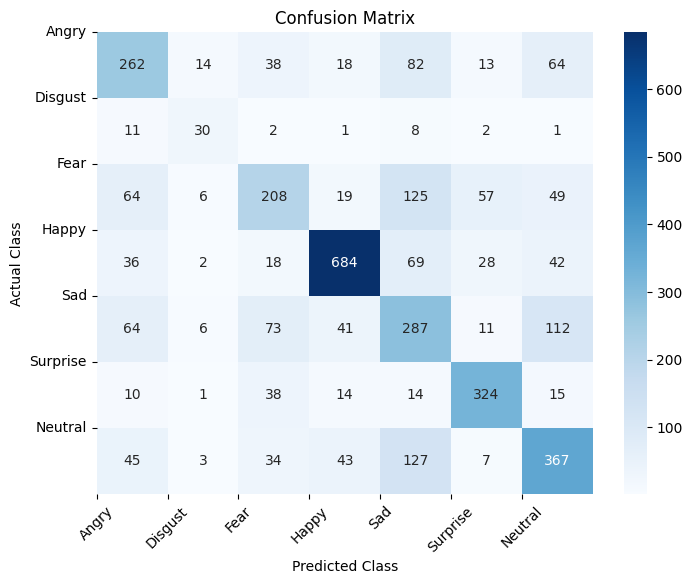

100%|██████████| 113/113 [00:01<00:00, 88.25it/s]


epoch:  17 | Train acc: 86.24 | Val acc: 58.51 | Train loss: 0.3883 | Val loss: 1.5634 | Confusion matrix: [[274   1  39  24  69  10  50]
 [ 19  23   5   2   6   0   1]
 [ 67   0 202  20 110  41  56]
 [ 42   0  25 685  51  25  67]
 [117   3  76  37 305  10 105]
 [ 15   1  41  21  15 307  15]
 [ 92   1  31  48 125   6 304]]


100%|██████████| 113/113 [00:01<00:00, 77.96it/s]


epoch:  18 | Train acc: 87.82 | Val acc: 57.95 | Train loss: 0.3492 | Val loss: 1.5851 | Confusion matrix: [[216  10  68  26  69  14  64]
 [  9  28   8   4   4   0   3]
 [ 44   2 232  24  95  44  55]
 [ 31   1  46 670  38  23  86]
 [ 63   8 113  40 295  12 122]
 [  7   1  62  22   9 301  13]
 [ 47   3  61  52  93  13 338]]


100%|██████████| 113/113 [00:01<00:00, 87.44it/s]


epoch:  19 | Train acc: 89.21 | Val acc: 58.37 | Train loss: 0.3133 | Val loss: 1.6584 | Confusion matrix: [[252   0  33  25  65  14  78]
 [ 22  21   4   1   5   0   3]
 [ 73   2 161  24 102  54  80]
 [ 42   0  14 680  23  37  99]
 [ 91   0  59  49 295  14 145]
 [ 11   0  33  18   8 316  29]
 [ 61   1  32  52  81  10 370]]


100%|██████████| 113/113 [00:01<00:00, 87.36it/s]


epoch:  20 | Train acc: 90.03 | Val acc: 58.62 | Train loss: 0.2886 | Val loss: 1.7924 | Confusion matrix: [[270   6  39  24  52  16  60]
 [ 13  23   7   3   3   2   5]
 [ 67   3 188  20  93  59  66]
 [ 40   0  23 700  22  31  79]
 [ 97   6  89  44 273  11 133]
 [ 15   1  36  21   7 311  24]
 [ 67   1  50  57  81  12 339]]


100%|██████████| 113/113 [00:01<00:00, 84.25it/s]


epoch:  21 | Train acc: 90.61 | Val acc: 58.85 | Train loss: 0.2661 | Val loss: 1.8204 | Confusion matrix: [[231   2  47  24  73  25  65]
 [ 12  27   5   3   6   1   2]
 [ 43   1 185  31 119  63  54]
 [ 38   3  22 691  37  40  64]
 [ 75   2  72  45 320  24 115]
 [  7   2  33  22  10 330  11]
 [ 51   1  50  54 105  18 328]]


100%|██████████| 113/113 [00:01<00:00, 86.16it/s]


epoch:  22 | Train acc: 91.63 | Val acc: 59.13 | Train loss: 0.2401 | Val loss: 1.8457 | Confusion matrix: [[252   3  35  24  76  19  58]
 [ 17  25   5   1   6   0   2]
 [ 48   0 210  21 122  44  51]
 [ 38   1  30 687  42  29  68]
 [ 89   2  90  38 318  15 101]
 [  6   0  38  17  20 321  13]
 [ 68   1  56  52 111  10 309]]


100%|██████████| 113/113 [00:01<00:00, 87.76it/s]


epoch:  23 | Train acc: 95.58 | Val acc: 60.21 | Train loss: 0.1334 | Val loss: 1.9658 | Confusion matrix: [[248   3  38  28  70  18  62]
 [ 14  27   3   4   5   0   3]
 [ 43   1 216  27 105  50  54]
 [ 29   1  19 711  33  24  78]
 [ 82   3  92  39 302  11 124]
 [  7   0  33  20  12 325  18]
 [ 61   1  62  48  91  12 332]]
overwriting the best model!
epoch:  23 | Test acc: 60.88 | Test loss: 1.8369 | Test Confusion matrix: [[251   7  62  23  70   9  69]
 [ 15  29   1   2   5   2   1]
 [ 47   2 246  21  94  52  66]
 [ 31   0  20 708  46  15  59]
 [ 73   5  87  35 262  11 121]
 [  7   0  43  15  11 325  15]
 [ 56   0  56  48  88  14 364]]


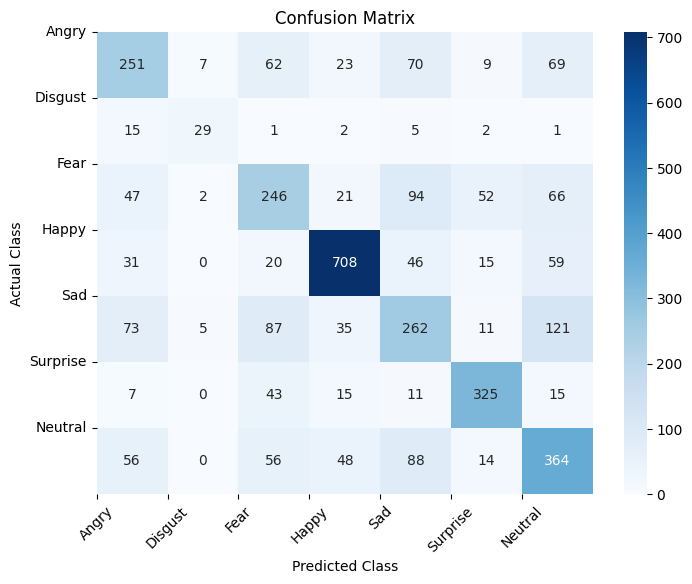

100%|██████████| 113/113 [00:01<00:00, 86.81it/s]


epoch:  24 | Train acc: 97.63 | Val acc: 60.02 | Train loss: 0.0768 | Val loss: 2.2495 | Confusion matrix: [[246   4  45  28  79  16  49]
 [ 15  27   4   2   5   0   3]
 [ 43   1 211  31 120  47  43]
 [ 30   1  25 722  33  18  66]
 [ 71   6  96  37 328  10 105]
 [  6   0  40  23  13 317  16]
 [ 63   1  60  56 112  12 303]]


100%|██████████| 113/113 [00:01<00:00, 83.26it/s]


epoch:  25 | Train acc: 98.33 | Val acc: 60.30 | Train loss: 0.0536 | Val loss: 2.3624 | Confusion matrix: [[251   1  43  25  73  17  57]
 [ 14  30   2   4   3   0   3]
 [ 44   0 199  28 123  49  53]
 [ 29   1  18 727  32  20  68]
 [ 80   3  82  49 311  11 117]
 [  8   0  31  21  12 325  18]
 [ 61   1  54  58 103   9 321]]
overwriting the best model!
epoch:  25 | Test acc: 61.41 | Test loss: 2.1764 | Test Confusion matrix: [[257   8  53  27  79   8  59]
 [ 14  30   1   3   4   2   1]
 [ 54   1 234  20 102  48  69]
 [ 28   0  17 725  45  15  49]
 [ 79   3  73  36 287   8 108]
 [  5   0  40  21  13 324  13]
 [ 50   1  44  54 111  19 347]]


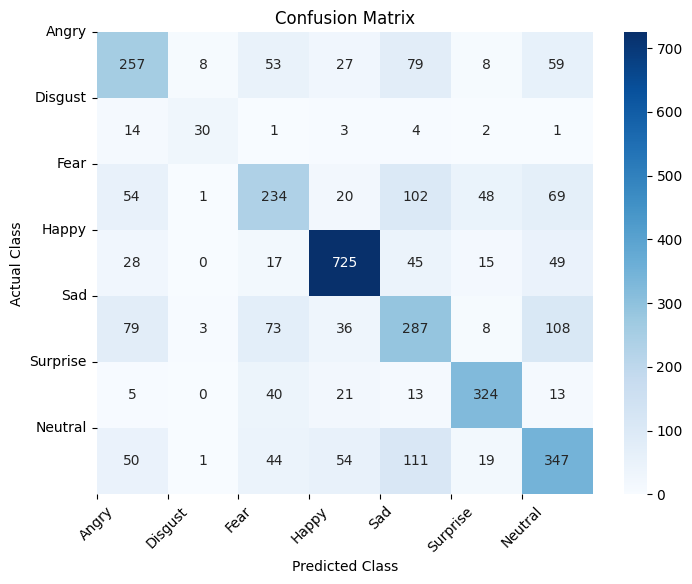

100%|██████████| 113/113 [00:01<00:00, 85.51it/s]


epoch:  26 | Train acc: 98.77 | Val acc: 60.16 | Train loss: 0.0435 | Val loss: 2.6239 | Confusion matrix: [[258   3  43  24  71  18  50]
 [ 16  31   2   2   2   0   3]
 [ 46   1 212  23 114  49  51]
 [ 38   2  19 712  36  22  66]
 [ 89   5  85  45 315  11 103]
 [ 10   0  33  17  13 327  15]
 [ 69   1  55  54 115   9 304]]


100%|██████████| 113/113 [00:01<00:00, 82.68it/s]


epoch:  27 | Train acc: 98.94 | Val acc: 59.71 | Train loss: 0.0388 | Val loss: 2.7135 | Confusion matrix: [[249   6  46  22  66  19  59]
 [ 14  28   5   3   2   0   4]
 [ 45   0 217  27 108  46  53]
 [ 35   2  25 710  27  24  72]
 [ 82   3  96  38 307  12 115]
 [ 11   0  40  19   8 322  15]
 [ 65   1  66  58  98   9 310]]


100%|██████████| 113/113 [00:01<00:00, 85.27it/s]


epoch:  28 | Train acc: 99.18 | Val acc: 59.91 | Train loss: 0.0285 | Val loss: 2.8747 | Confusion matrix: [[248   6  44  32  64  16  57]
 [ 13  30   4   3   2   0   4]
 [ 49   0 198  33 111  49  56]
 [ 29   1  14 736  22  23  70]
 [ 86   1  88  47 307  10 114]
 [  7   0  31  19  13 328  17]
 [ 65   2  60  63 104  10 303]]


100%|██████████| 113/113 [00:01<00:00, 84.75it/s]


epoch:  29 | Train acc: 99.19 | Val acc: 59.96 | Train loss: 0.0310 | Val loss: 2.8228 | Confusion matrix: [[251   4  40  31  72  20  49]
 [ 15  29   6   1   2   0   3]
 [ 44   0 210  33 110  47  52]
 [ 33   1  19 733  26  21  62]
 [ 93   2  94  43 300  13 108]
 [  7   0  31  22  14 327  14]
 [ 64   1  57  62 104  17 302]]


100%|██████████| 113/113 [00:01<00:00, 83.23it/s]


epoch:  30 | Train acc: 99.18 | Val acc: 59.10 | Train loss: 0.0272 | Val loss: 2.8722 | Confusion matrix: [[248   5  49  24  76  17  48]
 [ 16  27   5   2   3   0   3]
 [ 42   0 224  24 116  44  46]
 [ 34   1  25 701  44  24  66]
 [ 78   1 111  40 311   8 104]
 [  8   0  42  15  17 321  12]
 [ 62   2  72  56 113  13 289]]


100%|██████████| 113/113 [00:01<00:00, 86.11it/s]


epoch:  31 | Train acc: 99.33 | Val acc: 59.68 | Train loss: 0.0232 | Val loss: 3.0414 | Confusion matrix: [[248   8  47  30  64  17  53]
 [ 15  30   4   3   1   0   3]
 [ 46   1 214  26 108  53  48]
 [ 29   2  20 722  34  26  62]
 [ 83   4 105  47 303  12  99]
 [  8   0  38  19  10 326  14]
 [ 71   2  57  61 105  12 299]]


100%|██████████| 113/113 [00:01<00:00, 86.99it/s]


epoch:  32 | Train acc: 99.51 | Val acc: 59.91 | Train loss: 0.0158 | Val loss: 2.9532 | Confusion matrix: [[243   6  47  28  72  13  58]
 [ 16  28   5   2   2   0   3]
 [ 44   1 213  26 118  44  50]
 [ 33   0  23 717  35  20  67]
 [ 84   3  95  38 313   9 111]
 [  7   0  40  21  13 319  15]
 [ 68   2  57  49 107   7 317]]


100%|██████████| 113/113 [00:01<00:00, 85.52it/s]


epoch:  33 | Train acc: 99.65 | Val acc: 59.65 | Train loss: 0.0124 | Val loss: 3.1039 | Confusion matrix: [[247   6  47  27  73  14  53]
 [ 16  27   6   2   2   0   3]
 [ 49   1 213  26 115  46  46]
 [ 32   0  21 723  33  22  64]
 [ 85   2 110  41 312  10  93]
 [  7   0  43  22   9 321  13]
 [ 68   2  61  58 108  12 298]]


100%|██████████| 113/113 [00:01<00:00, 83.83it/s]


epoch:  34 | Train acc: 99.69 | Val acc: 59.74 | Train loss: 0.0109 | Val loss: 3.1853 | Confusion matrix: [[245   5  51  29  68  11  58]
 [ 14  27   7   3   2   0   3]
 [ 45   0 218  27 113  44  49]
 [ 32   0  25 726  29  20  63]
 [ 79   2 114  41 302  10 105]
 [  6   0  46  21   9 320  13]
 [ 62   2  71  57 101   8 306]]


100%|██████████| 113/113 [00:01<00:00, 86.96it/s]


epoch:  35 | Train acc: 99.67 | Val acc: 59.57 | Train loss: 0.0097 | Val loss: 3.2016 | Confusion matrix: [[245   7  48  31  64  13  59]
 [ 16  27   6   2   2   0   3]
 [ 47   0 219  30 106  43  51]
 [ 29   0  21 734  23  21  67]
 [ 89   2 114  48 284  11 105]
 [  8   0  40  22   9 322  14]
 [ 66   2  66  65  89  12 307]]


100%|██████████| 113/113 [00:01<00:00, 85.60it/s]


epoch:  36 | Train acc: 99.68 | Val acc: 59.71 | Train loss: 0.0097 | Val loss: 3.1910 | Confusion matrix: [[252   5  43  27  70  13  57]
 [ 16  28   6   2   1   0   3]
 [ 48   1 209  27 117  45  49]
 [ 34   0  20 721  32  22  66]
 [ 91   2 105  42 300  10 103]
 [  9   0  34  19  11 325  17]
 [ 67   2  60  60  98  12 308]]


100%|██████████| 113/113 [00:01<00:00, 86.63it/s]


epoch:  37 | Train acc: 99.71 | Val acc: 59.74 | Train loss: 0.0086 | Val loss: 3.1701 | Confusion matrix: [[242   5  49  26  71  14  60]
 [ 15  27   6   3   2   0   3]
 [ 43   1 214  27 117  45  49]
 [ 32   0  20 721  36  21  65]
 [ 82   2 109  40 304   7 109]
 [  8   0  42  17  10 320  18]
 [ 58   2  63  57 100  11 316]]


100%|██████████| 113/113 [00:01<00:00, 85.25it/s]


epoch:  38 | Train acc: 99.75 | Val acc: 60.13 | Train loss: 0.0079 | Val loss: 3.1957 | Confusion matrix: [[247   6  45  27  75  12  55]
 [ 16  27   6   2   2   0   3]
 [ 46   0 207  27 124  45  47]
 [ 31   0  20 719  38  20  67]
 [ 83   1  97  39 326   8  99]
 [  8   0  36  17  13 323  18]
 [ 58   1  60  53 114  12 309]]


100%|██████████| 113/113 [00:01<00:00, 85.97it/s]


epoch:  39 | Train acc: 99.72 | Val acc: 59.74 | Train loss: 0.0071 | Val loss: 3.2284 | Confusion matrix: [[246   5  46  27  77  12  54]
 [ 16  27   6   2   2   0   3]
 [ 47   1 207  27 120  48  46]
 [ 32   0  20 724  36  21  62]
 [ 88   2  94  43 320   9  97]
 [  9   0  37  20  12 322  15]
 [ 62   2  61  62 109  13 298]]


100%|██████████| 113/113 [00:01<00:00, 86.24it/s]


epoch:  40 | Train acc: 99.76 | Val acc: 59.99 | Train loss: 0.0071 | Val loss: 3.3371 | Confusion matrix: [[250   5  46  28  71  12  55]
 [ 16  27   6   2   2   0   3]
 [ 46   1 211  27 116  43  52]
 [ 33   0  24 723  34  19  62]
 [ 83   2 105  40 311   9 103]
 [  7   0  39  18  10 326  15]
 [ 60   2  63  60 104  13 305]]
epoch:  40 | Test acc: 61.10 | Test loss: 3.1400 | Test Confusion matrix: [[253   7  62  27  66   8  68]
 [ 16  29   1   0   4   3   2]
 [ 48   1 266  18  88  41  66]
 [ 35   1  29 709  42  13  50]
 [ 67   2  91  36 276  11 111]
 [  9   0  50  16   8 316  17]
 [ 58   2  56  57  94  15 344]]
Early stopping at epoch 40
epoch:  40 | Test acc: 61.10 | Test loss: 3.1400 | Test Confusion matrix: [[253   7  62  27  66   8  68]
 [ 16  29   1   0   4   3   2]
 [ 48   1 266  18  88  41  66]
 [ 35   1  29 709  42  13  50]
 [ 67   2  91  36 276  11 111]
 [  9   0  50  16   8 316  17]
 [ 58   2  56  57  94  15 344]]


wandb: Agent Starting Run: 7ry1pbrs with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.005
wandb: 	weight_decay: 0.01


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudn

epoch:   1 | Train acc: 25.07 | Val acc: 28.00 | Train loss: 1.8203 | Val loss: 1.7609 | Confusion matrix: [[  0   0   5 421   0  41   0]
 [  0   0   0  53   0   3   0]
 [  0   0   5 433   0  58   0]
 [  0   0   3 847   0  45   0]
 [  0   0   5 598   0  50   0]
 [  0   0   4 258   0 153   0]
 [  0   0   2 574   0  31   0]]
overwriting the best model!
epoch:   1 | Test acc: 27.31 | Test loss: 1.7721 | Test Confusion matrix: [[  0   0   4 436   0  51   0]
 [  0   0   0  48   0   7   0]
 [  0   0   3 462   0  63   0]
 [  0   0   4 827   0  48   0]
 [  0   0   3 550   0  41   0]
 [  0   0   5 261   0 150   0]
 [  0   0   0 598   0  28   0]]


 75%|███████▍  | 670/898 [00:16<00:05, 41.59it/s]

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from datetime import datetime
import time
import argparse
import torchvision.models as models
import random
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from tqdm import tqdm

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
def train_with_hyperparameters():
  wandb.init()
  config = wandb.config
  set_seed(35)
  class_dirs = ['Angry',  'Disgust', 'Fear', 'Happy',  'Sad',  'Surprise', 'Neutral']

  # Hyperparameters
  batch_size = config.batch_size
  learning_rate = config.lr
  weight_decay = config.weight_decay
  model_name = "ResNet18"
  optimizer_name = "Adam"
  num_classes = 4
  num_worker = 4
  num_epoch = 100
  best_acc = 0
  early_stopping_thresh = 15
  LRScheduling_patience = 5
  lrs_factor = 0.2
  best_threshold = 0.0001
  early_stop_counter = 0

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("device: ", device)

  model = models.resnet18(pretrained=False)

  # Modify the first convolutional layer to accept 1 channel input
  model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  # Change the final layer to output 7 classes
  model.fc = torch.nn.Linear(model.fc.in_features, 7)
  model.to(device)

  if optimizer_name == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=lrs_factor, patience=LRScheduling_patience, threshold=best_threshold, verbose=True)

  criterion = nn.CrossEntropyLoss()

  # Training loop
  for epoch in range(num_epoch):
      #print("hehehe")
      model.train()
      training_loss, train_correct = 0.0, 0
      i=0
      for data, target in tqdm(train_loader):
          #print("train {}".format(i))
          #i+=1
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output, target)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          prediction = output.argmax(dim=1, keepdim=True)
          train_correct += prediction.eq(target.view_as(prediction)).sum().item()
          training_loss += loss.item()
      training_loss /= len(train_loader)
      train_accuracy = train_correct / len(train_loader.dataset)

      model.eval()
      val_loss, val_correct = 0.0, 0
      y_true, y_pred = [], []
      #print("validation")
      with torch.no_grad():
          for data, target in tqdm(val_loader):
              #print("validation")
              data, target = data.to(device), target.to(device)
              y_true.extend(target.cpu().tolist())
              output = model(data)
              loss = criterion(output, target)
              prediction = output.argmax(dim=1, keepdim=True)
              y_pred.extend(prediction.cpu().tolist())
              val_correct += prediction.eq(target.view_as(prediction)).sum().item()
              val_loss += loss.item()
      val_loss /= len(val_loader)
      val_accuracy = val_correct / len(val_loader.dataset)

      scheduler.step(val_accuracy)

      cm_4class = confusion_matrix(y_true, y_pred)
      flattened_preds = [item for sublist in y_pred for item in sublist] if isinstance(y_pred[0], list) else y_pred
      print("epoch: {:3.0f}".format(epoch + 1) + " | Train acc: {:4.2f}".format(
          train_accuracy * 100) + " | Val acc: {:4.2f}".format(
          val_accuracy * 100) + " | Train loss: {:6.4f}".format(
          training_loss) + " | Val loss: {:6.4f}".format(
          val_loss) +  " | Confusion matrix: {}".format(cm_4class))
      wandb.log({
            "epoch": epoch + 1,
            "lr": optimizer.param_groups[0]['lr'],
            'train loss': training_loss,
            'val loss': val_loss,
            'train acc': train_accuracy,
            'val acc': val_accuracy,
            'conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=flattened_preds, class_names=class_dirs)
        })


      if val_accuracy > best_acc * (1 + best_threshold):
          early_stop_counter = 0
          best_acc = val_accuracy
          print("overwriting the best model!")

          torch.save(model.state_dict(), "weights/best_" + model_name + '.pth.tar')
          model.eval()
          test_loss, test_correct = 0.0, 0
          y_true_test, y_pred_test = [], []
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  y_true_test.extend(target.cpu().tolist())
                  output = model(data)
                  loss = criterion(output, target)
                  prediction = output.argmax(dim=1, keepdim=True)
                  y_pred_test.extend(prediction.cpu().tolist())
                  test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                  test_loss += loss.item()
          test_loss /= len(test_loader)
          test_accuracy = test_correct / len(test_loader.dataset)
          cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
          flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
          print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
              test_accuracy * 100) + " | Test loss: {:6.4f}".format(
              test_loss) +  " | Test Confusion matrix: {}".format(cm_4class_test))
          wandb.log({
                "test_lr": optimizer.param_groups[0]['lr'],
                'test loss': test_loss,
                'test acc': test_accuracy,
                'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_dirs)
            })
          plt.figure(figsize=(8, 6))
          sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
          plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
          plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
          plt.xlabel("Predicted Class")
          plt.ylabel("Actual Class")
          plt.title("Confusion Matrix")
          plt.show()
      else:
          early_stop_counter += 1
      if early_stop_counter >= early_stopping_thresh:
          model.eval()
          test_loss, test_correct = 0.0, 0
          y_true_test, y_pred_test = [], []
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  y_true_test.extend(target.cpu().tolist())
                  output = model(data)
                  loss = criterion(output, target)
                  prediction = output.argmax(dim=1, keepdim=True)
                  y_pred_test.extend(prediction.cpu().tolist())
                  test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                  test_loss += loss.item()
          test_loss /= len(test_loader)
          test_accuracy = test_correct / len(test_loader.dataset)
          cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
          flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
          print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
              test_accuracy * 100) + " | Test loss: {:6.4f}".format(
              test_loss) +  " | Test Confusion matrix: {}".format(cm_4class_test))
          wandb.log({
                "test_lr": optimizer.param_groups[0]['lr'],
                'test loss': test_loss,
                'test acc': test_accuracy,
                'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_dirs)
            })
          print("Early stopping at epoch {}".format(epoch + 1))
          break
  model.eval()
  test_loss, test_correct = 0.0, 0
  y_true_test, y_pred_test = [], []
  with torch.no_grad():
      for data, target in test_loader:
          #print("validation")
          data, target = data.to(device), target.to(device)
          y_true_test.extend(target.cpu().tolist())
          output = model(data)
          loss = criterion(output, target)
          prediction = output.argmax(dim=1, keepdim=True)
          y_pred_test.extend(prediction.cpu().tolist())
          test_correct += prediction.eq(target.view_as(prediction)).sum().item()
          test_loss += loss.item()
  test_loss /= len(test_loader)
  test_accuracy = test_correct / len(test_loader.dataset)
  cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
  flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
  print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
      test_accuracy * 100) + " | Test loss: {:6.4f}".format(
      test_loss) + " | Test Confusion matrix: {}".format(cm_4class_test))

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
  plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
  plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.title("Confusion Matrix")
  plt.show()
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [32]},
        'lr': {'values': [0.001, 0.0001, 0.005]},
        'weight_decay': {'values': [0, 0.01]},
    }
}

sweep_id = wandb.sweep(sweep_config, project='DI504-Project-EmreCakmakyurdu-ResNet18_3')
wandb.agent(sweep_id, train_with_hyperparameters)


Index([3, 6, 4, 2, 0, 5, 1], dtype='int64', name='emotion')


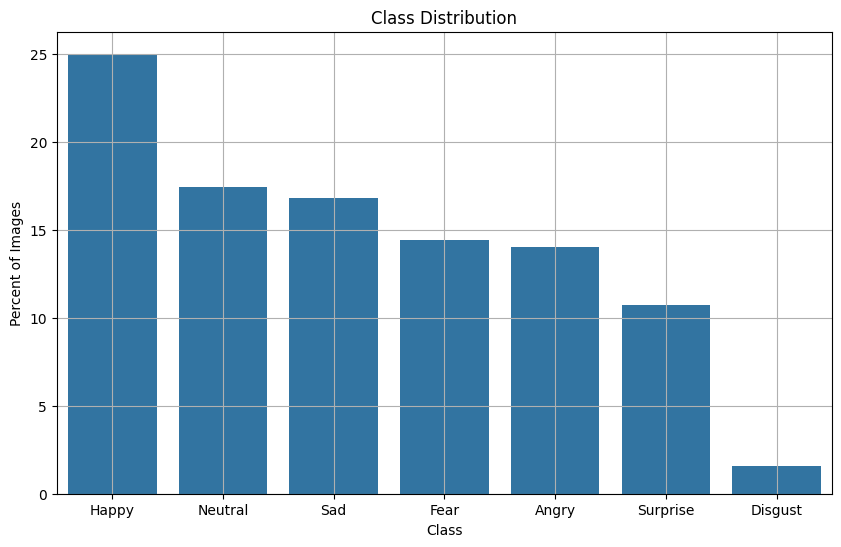

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('fer2013.csv')
class_counts = data['emotion'].value_counts(normalize=True) * 100
print(class_counts.keys())
class_dirs = ['Angry',  'Disgust', 'Fear', 'Happy',  'Sad',  'Surprise', 'Neutral']
class_image_count = {}
for class_ in class_counts.keys():
  class_image_count[class_dirs[class_]] = class_counts[class_]

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_image_count.keys()), y=list(class_image_count.values()))
plt.xlabel('Class')
plt.ylabel('Percent of Images')
plt.title('Class Distribution')
plt.grid(True)
plt.show()


# MaxVit


In [ ]:
!pip install transformers torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 11.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: bac63avs
Sweep URL: https://wandb.ai/di725/DI504-Project-EmreCakmakyurdu-MaxVit1/sweeps/bac63avs


wandb: Agent Starting Run: cmkt6l4l with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0001
wandb: 	weight_decay: 0
wandb: Currently logged in as: ecyurdu (di725). Use `wandb login --relogin` to force relogin


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:   1 | Train acc: 58.69 | Val acc: 65.73 | Train loss: 1.0966 | Val loss: 0.9303 | Confusion matrix: [[266   3  43  23  71  16  45]
 [ 21  21   2   1   6   1   4]
 [ 68   3 173  16 129  64  43]
 [ 12   0   6 788  16  21  52]
 [ 71   0  71  19 396  16  80]
 [ 11   0  21  14   7 358   4]
 [ 31   0  27  52 133   7 357]]
overwriting the best model!
epoch:   1 | Test acc: 67.34 | Test loss: 0.8844 | Test Confusion matrix: [[292   5  36  15  84  12  47]
 [ 19  19   4   1   9   2   1]
 [ 77   5 201  16 125  60  44]
 [  9   0   8 795  22  20  25]
 [ 54   1  48  23 377   9  82]
 [ 11   0  30  25   8 336   6]
 [ 12   0  34  29 140  14 397]]


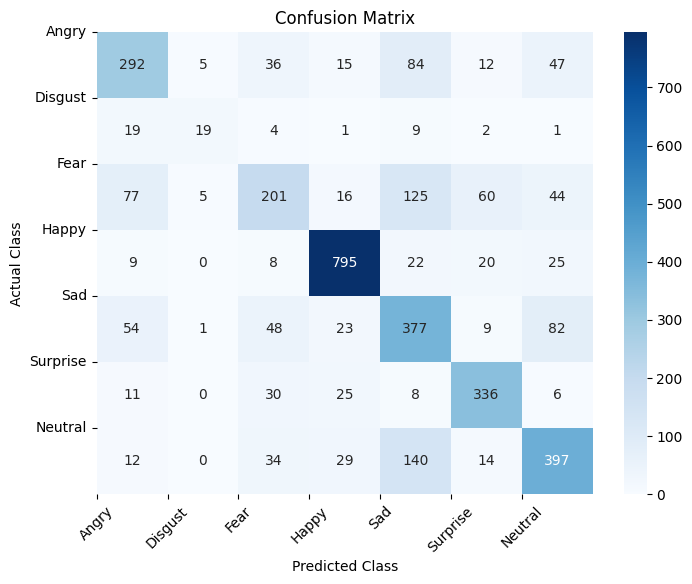

100%|██████████| 113/113 [00:18<00:00,  6.04it/s]


epoch:   2 | Train acc: 70.76 | Val acc: 68.46 | Train loss: 0.7964 | Val loss: 0.8785 | Confusion matrix: [[301  10  25  18  64  10  39]
 [ 13  31   5   1   4   0   2]
 [ 69   4 174  11 135  56  47]
 [ 20   3   7 783   6  27  49]
 [ 57   3  40  21 435  14  83]
 [ 12   0  19  10   9 355  10]
 [ 29   1  25  54 114   6 378]]
overwriting the best model!
epoch:   2 | Test acc: 68.71 | Test loss: 0.8339 | Test Confusion matrix: [[301  11  23  10  92  12  42]
 [ 18  26   4   1   5   0   1]
 [ 89   2 199  11 132  59  36]
 [ 14   0   6 791  15  21  32]
 [ 39   4  35  23 393   9  91]
 [ 16   0  28  17   8 335  12]
 [ 25   2  27  26 116   9 421]]


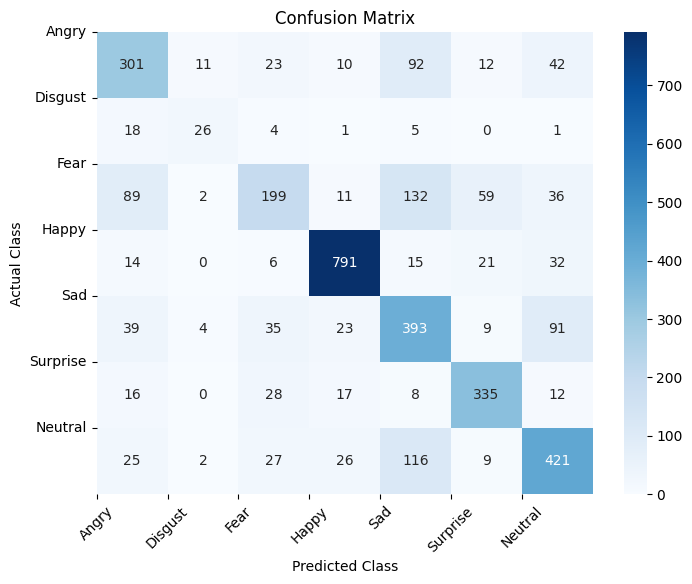

100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:   3 | Train acc: 78.46 | Val acc: 68.38 | Train loss: 0.6066 | Val loss: 0.9087 | Confusion matrix: [[249   9  65  14  57  16  57]
 [  9  35   5   1   3   0   3]
 [ 40   2 258   8  89  44  55]
 [ 11   1  17 749  17  30  70]
 [ 63   1  82   8 378  14 107]
 [  8   0  38   7   5 352   5]
 [ 20   0  45  24  79   6 433]]


100%|██████████| 113/113 [00:18<00:00,  6.07it/s]


epoch:   4 | Train acc: 85.40 | Val acc: 68.99 | Train loss: 0.4132 | Val loss: 0.9836 | Confusion matrix: [[316  10  47  14  38   6  36]
 [  9  38   2   2   3   0   2]
 [ 64   3 251  10  86  35  47]
 [ 18   2  14 778  17  25  41]
 [ 80   2  87  17 362  12  93]
 [ 14   0  28  11   4 352   6]
 [ 38   1  57  50  71  11 379]]
overwriting the best model!
epoch:   4 | Test acc: 70.52 | Test loss: 0.8979 | Test Confusion matrix: [[324   9  49   6  53   9  41]
 [  7  44   1   1   0   1   1]
 [ 69   3 295  11  78  34  38]
 [  9   0  14 791  19  17  29]
 [ 69   1  72  18 317   9 108]
 [ 12   0  46  19   2 332   5]
 [ 30   1  51  32  70  14 428]]


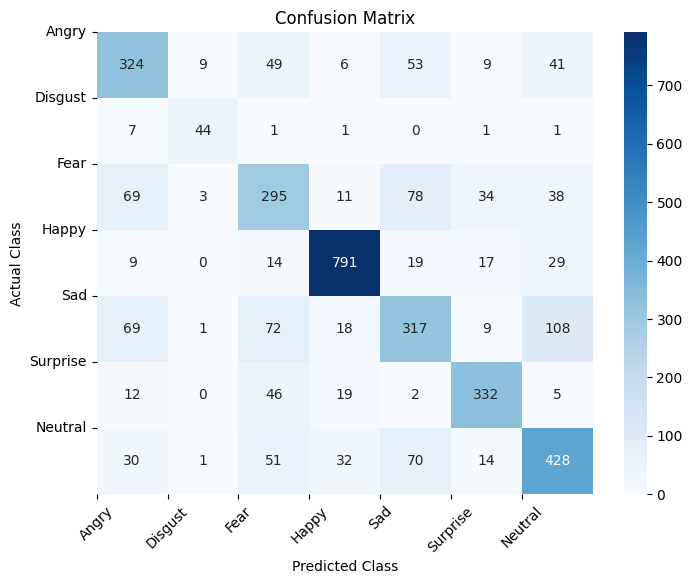

100%|██████████| 113/113 [00:18<00:00,  6.05it/s]


epoch:   5 | Train acc: 91.50 | Val acc: 69.16 | Train loss: 0.2512 | Val loss: 1.0841 | Confusion matrix: [[299   8  41  27  57   4  31]
 [ 14  31   3   1   5   0   2]
 [ 52   1 245  18  95  28  57]
 [ 18   2  13 802   4  16  40]
 [100   1  55  20 375  10  92]
 [ 11   1  28  23   9 331  12]
 [ 43   0  29  55  80   1 399]]
overwriting the best model!
epoch:   5 | Test acc: 70.21 | Test loss: 1.0180 | Test Confusion matrix: [[322   6  43  13  63   6  38]
 [ 10  37   4   2   2   0   0]
 [ 73   2 283  19  84  19  48]
 [  8   1   7 797  14  14  38]
 [ 78   0  58  22 329   5 102]
 [ 13   0  42  26   8 318   9]
 [ 36   2  30  39  78   7 434]]


100%|██████████| 113/113 [00:18<00:00,  6.06it/s]


epoch:   6 | Train acc: 94.46 | Val acc: 68.18 | Train loss: 0.1627 | Val loss: 1.3806 | Confusion matrix: [[262   7  45  26  34  16  77]
 [  8  33   7   3   2   0   3]
 [ 36   1 258  21  67  37  76]
 [  7   0  12 813   4  17  42]
 [ 48   2  87  37 292  12 175]
 [ 10   0  18  15   3 352  17]
 [ 18   2  25  69  45  11 437]]


100%|██████████| 113/113 [00:18<00:00,  6.07it/s]


epoch:   7 | Train acc: 95.74 | Val acc: 68.10 | Train loss: 0.1244 | Val loss: 1.3681 | Confusion matrix: [[286  13  63  10  58  13  24]
 [ 13  34   5   1   2   0   1]
 [ 47   7 284   7  89  29  33]
 [ 24   1  27 750  20  28  45]
 [ 70   9  92  14 400  13  55]
 [ 12   0  35   9   6 349   4]
 [ 35   5  51  41 113  21 341]]


100%|██████████| 113/113 [00:18<00:00,  6.07it/s]


epoch:   8 | Train acc: 96.45 | Val acc: 69.35 | Train loss: 0.1059 | Val loss: 1.4788 | Confusion matrix: [[301   6  52  24  52   5  27]
 [ 13  30   5   1   7   0   0]
 [ 46   1 278  12  83  28  48]
 [ 18   0  15 802   6  14  40]
 [ 81   0 102  20 372  10  68]
 [ 11   0  38  19   8 330   9]
 [ 53   0  47  44  80   7 376]]
overwriting the best model!
epoch:   8 | Test acc: 69.71 | Test loss: 1.3732 | Test Confusion matrix: [[311   4  58  15  61   6  36]
 [  8  35   6   1   4   1   0]
 [ 65   3 307  14  77  18  44]
 [  7   0   9 809  10  13  31]
 [ 62   0  97  23 310   5  97]
 [ 11   1  41  28   5 323   7]
 [ 35   1  45  31 102   5 407]]


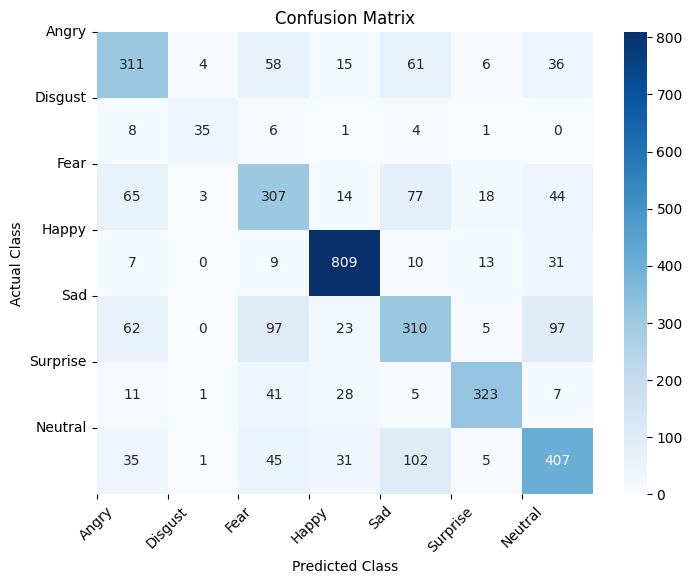

100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:   9 | Train acc: 97.20 | Val acc: 69.71 | Train loss: 0.0832 | Val loss: 1.5218 | Confusion matrix: [[258   9  47  23  70  15  45]
 [ 12  31   3   1   8   0   1]
 [ 39   2 256   8  98  39  54]
 [ 11   0   9 784  16  22  53]
 [ 44   2  69  19 398  13 108]
 [  7   0  32  12   6 350   8]
 [ 20   2  25  42  80  13 425]]
overwriting the best model!
epoch:   9 | Test acc: 70.21 | Test loss: 1.4256 | Test Confusion matrix: [[263   6  48  14  93   7  60]
 [  5  41   4   1   1   3   0]
 [ 45   3 289  13  85  35  58]
 [  4   0   8 796  17  15  39]
 [ 34   2  62  13 344  12 127]
 [  7   0  38  20   9 335   7]
 [ 13   2  29  29  96   5 452]]


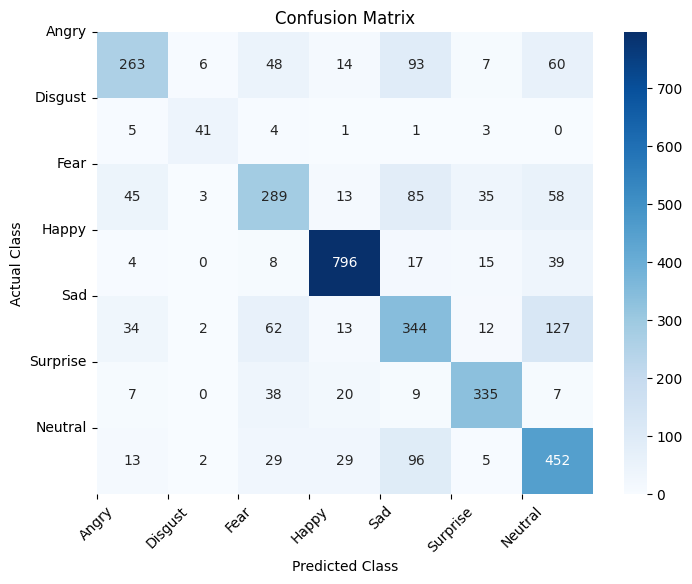

100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:  10 | Train acc: 97.65 | Val acc: 68.40 | Train loss: 0.0704 | Val loss: 1.5406 | Confusion matrix: [[296   5  54  18  51   8  35]
 [ 11  36   2   1   4   0   2]
 [ 45   5 258  18  94  36  40]
 [ 17   0  13 793   9  16  47]
 [ 78   2 108  25 346  14  80]
 [  9   0  29  15   8 347   7]
 [ 34   1  40  59  87   7 379]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  11 | Train acc: 97.31 | Val acc: 69.07 | Train loss: 0.0802 | Val loss: 1.5891 | Confusion matrix: [[286   7  48  16  56  15  39]
 [ 10  34   1   1   5   1   4]
 [ 44   1 239  15  94  50  53]
 [ 17   0   6 764  20  27  61]
 [ 67   1  78  15 412  14  66]
 [  8   0  13  14   7 367   6]
 [ 29   1  34  40 110  16 377]]


100%|██████████| 113/113 [00:18<00:00,  6.05it/s]


epoch:  12 | Train acc: 97.66 | Val acc: 69.46 | Train loss: 0.0696 | Val loss: 1.5601 | Confusion matrix: [[274   6  55  23  54  13  42]
 [ 11  33   3   2   5   0   2]
 [ 45   2 256  16  95  43  39]
 [ 13   0  12 792  14  18  46]
 [ 62   0  84  25 380  19  83]
 [  6   0  15  13   6 369   6]
 [ 19   1  37  58  91  12 389]]


100%|██████████| 113/113 [00:18<00:00,  6.04it/s]


epoch:  13 | Train acc: 97.77 | Val acc: 68.93 | Train loss: 0.0644 | Val loss: 1.6328 | Confusion matrix: [[294   9  45  18  51   8  42]
 [ 12  34   3   0   6   0   1]
 [ 46   3 252  10  95  40  50]
 [ 16   1   8 743  14  28  85]
 [ 70   5  67  14 400   8  89]
 [  9   0  27   8  13 346  12]
 [ 29   3  22  34 104  10 405]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:  14 | Train acc: 97.95 | Val acc: 69.38 | Train loss: 0.0611 | Val loss: 1.7020 | Confusion matrix: [[287  10  57  25  36  13  39]
 [ 12  33   5   0   3   0   3]
 [ 43   3 271  17  67  43  52]
 [ 14   0   9 797   5  22  48]
 [ 70   3  86  35 344  17  98]
 [  7   0  21  14   4 365   4]
 [ 34   1  34  54  77  14 393]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  15 | Train acc: 98.04 | Val acc: 69.80 | Train loss: 0.0589 | Val loss: 1.6568 | Confusion matrix: [[272  13  53  22  47  11  49]
 [  9  36   4   1   5   0   1]
 [ 42   1 246  13  89  44  61]
 [  8   0   8 799  11  22  47]
 [ 75   3  48  20 368  11 128]
 [  8   0  14  13   5 364  11]
 [ 35   2  25  54  64   7 420]]
overwriting the best model!
epoch:  15 | Test acc: 70.80 | Test loss: 1.5522 | Test Confusion matrix: [[282   5  51  17  60  12  64]
 [  4  40   3   2   3   1   2]
 [ 53   2 277  16  73  38  69]
 [  4   0  12 797   8  20  38]
 [ 53   4  49  19 329   8 132]
 [  5   2  30  17   5 346  11]
 [ 18   2  22  35  73   6 470]]


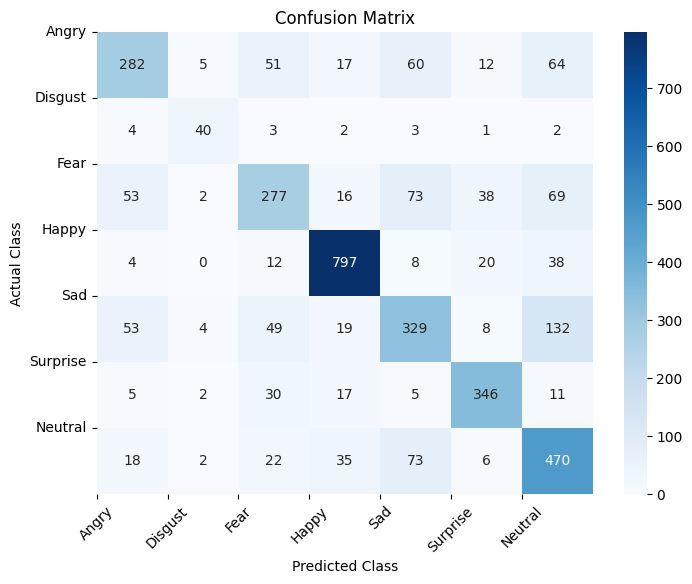

100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  16 | Train acc: 98.17 | Val acc: 68.29 | Train loss: 0.0549 | Val loss: 1.7356 | Confusion matrix: [[304   4  39  23  54  21  22]
 [ 16  28   3   1   6   1   1]
 [ 61   1 232  18  85  60  39]
 [ 19   0   8 798   9  32  29]
 [ 94   2  59  32 388  13  65]
 [  8   0  11  14   6 367   9]
 [ 51   0  38  82  95   7 334]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:  17 | Train acc: 98.07 | Val acc: 69.30 | Train loss: 0.0551 | Val loss: 1.7383 | Confusion matrix: [[297   6  40  27  40  12  45]
 [ 14  32   0   1   6   1   2]
 [ 50   0 233  19 100  39  55]
 [ 17   0  14 778   8  26  52]
 [101   2  50  17 373  12  98]
 [  9   0  19  11   4 360  12]
 [ 39   0  22  55  67  10 414]]


100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:  18 | Train acc: 98.40 | Val acc: 68.99 | Train loss: 0.0486 | Val loss: 1.8708 | Confusion matrix: [[315   6  50  13  21  11  51]
 [ 14  33   1   1   3   1   3]
 [ 46   2 287   8  52  33  68]
 [ 21   1  19 758   9  25  62]
 [ 94   5  98  21 285  13 137]
 [ 12   0  33   8   0 347  15]
 [ 37   0  31  34  48   6 451]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  19 | Train acc: 98.16 | Val acc: 68.71 | Train loss: 0.0523 | Val loss: 1.7965 | Confusion matrix: [[302  10  39  21  36  11  48]
 [ 11  34   5   1   3   0   2]
 [ 45   1 229  12  84  44  81]
 [ 16   0  12 768   8  28  63]
 [ 91   1  49  24 337  14 137]
 [  9   0  12  14   6 363  11]
 [ 42   1  18  44  56  13 433]]


100%|██████████| 113/113 [00:18<00:00,  6.04it/s]


epoch:  20 | Train acc: 98.25 | Val acc: 69.46 | Train loss: 0.0496 | Val loss: 1.8562 | Confusion matrix: [[279   6  55  19  64   7  37]
 [ 10  36   3   1   4   0   2]
 [ 35   5 285   9  96  25  41]
 [ 22   2  24 744  19  27  57]
 [ 60   2  63  11 436  10  71]
 [  8   0  38  12  10 337  10]
 [ 41   2  36  41 107   4 376]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  21 | Train acc: 98.36 | Val acc: 69.35 | Train loss: 0.0457 | Val loss: 1.7226 | Confusion matrix: [[290  11  42  19  54   7  44]
 [  9  34   4   1   5   0   3]
 [ 53   1 248   9 109  26  50]
 [ 12   0  11 774  20  13  65]
 [ 60   2  63  14 410   8  96]
 [ 14   0  26  18  12 336   9]
 [ 26   1  26  44 108   5 397]]
epoch:  21 | Test acc: 69.82 | Test loss: 1.6412 | Test Confusion matrix: [[281   6  57  13  78   6  50]
 [  8  37   5   1   4   0   0]
 [ 55   3 286   8  99  21  56]
 [  8   0  12 781  14  13  51]
 [ 47   2  70  17 353   4 101]
 [  7   2  39  24  13 321  10]
 [ 23   2  27  26  98   3 447]]
Early stopping at epoch 21
epoch:  21 | Test acc: 69.82 | Test loss: 1.6412 | Test Confusion matrix: [[281   6  57  13  78   6  50]
 [  8  37   5   1   4   0   0]
 [ 55   3 286   8  99  21  56]
 [  8   0  12 781  14  13  51]
 [ 47   2  70  17 353   4 101]
 [  7   2  39  24  13 321  10]
 [ 23   2  27  26  98   3 447]]


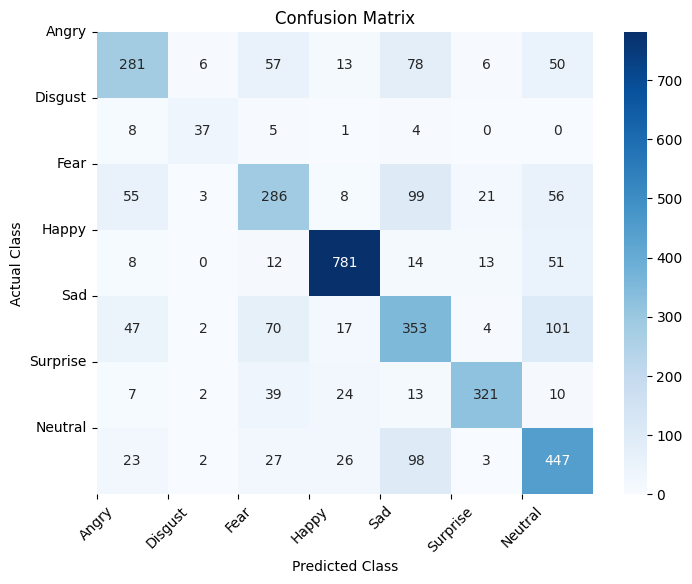

wandb: Agent Starting Run: sqjx491z with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0001
wandb: 	weight_decay: 0.001


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 113/113 [00:18<00:00,  6.04it/s]


epoch:   1 | Train acc: 58.54 | Val acc: 65.25 | Train loss: 1.0945 | Val loss: 0.9363 | Confusion matrix: [[251   6  45  26  64  17  58]
 [ 20  23   4   1   3   1   4]
 [ 67   5 188  14 115  60  47]
 [ 10   3   7 773  16  21  65]
 [ 73   0  56  19 373  16 116]
 [ 13   0  18  15   8 351  10]
 [ 20   1  25  43 127   8 383]]
overwriting the best model!
epoch:   1 | Test acc: 66.29 | Test loss: 0.8936 | Test Confusion matrix: [[287   7  33  17  72  17  58]
 [ 23  21   3   2   5   1   0]
 [ 73   5 194  15 116  69  56]
 [  8   1   7 785  26  18  34]
 [ 54   6  53  25 347   8 101]
 [ 11   3  32  28   6 327   9]
 [ 18   2  25  30 122  11 418]]


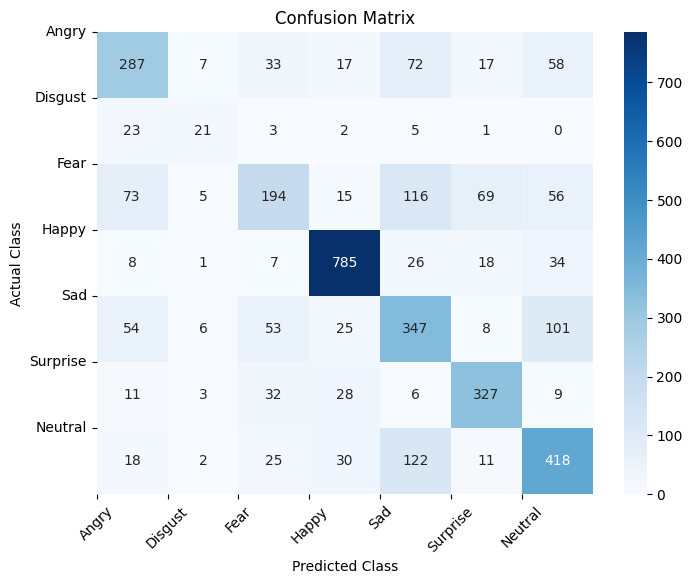

100%|██████████| 113/113 [00:18<00:00,  6.04it/s]


epoch:   2 | Train acc: 70.51 | Val acc: 67.54 | Train loss: 0.7991 | Val loss: 0.8791 | Confusion matrix: [[296   6  26  17  79  10  33]
 [ 22  25   0   1   7   1   0]
 [ 69   3 187  12 151  43  31]
 [ 16   0   8 790  13  23  45]
 [ 63   1  48  19 443  14  65]
 [ 12   0  32  11  11 343   6]
 [ 29   0  19  63 150   6 340]]
overwriting the best model!
epoch:   2 | Test acc: 68.04 | Test loss: 0.8514 | Test Confusion matrix: [[304   7  26  10  99  10  35]
 [ 18  29   2   1   4   0   1]
 [ 88   3 202  11 143  48  33]
 [ 14   0   4 785  24  25  27]
 [ 51   2  30  17 415   9  70]
 [ 14   1  40  16   7 331   7]
 [ 25   0  27  31 162   5 376]]


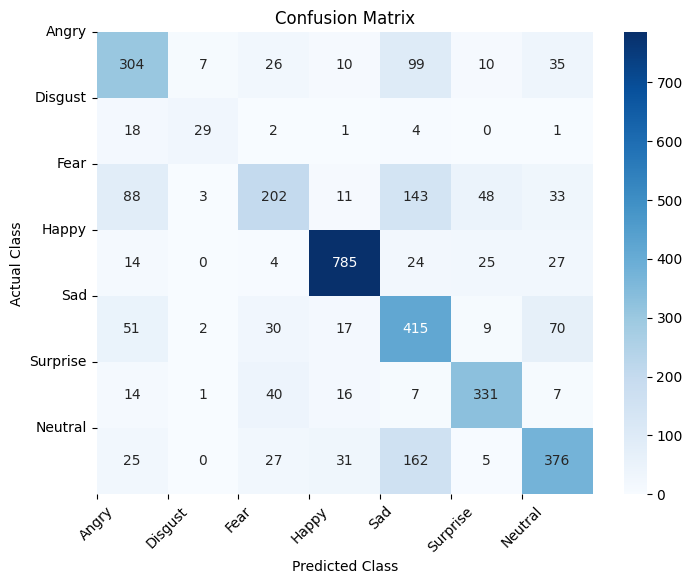

100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:   3 | Train acc: 78.22 | Val acc: 68.90 | Train loss: 0.6089 | Val loss: 0.8831 | Confusion matrix: [[253  20  57  16  56  10  55]
 [  8  36   4   2   4   0   2]
 [ 39   5 230  12 111  42  57]
 [ 10   1   9 785  10  28  52]
 [ 66   5  48  19 384  12 119]
 [  7   1  23  10  10 354  10]
 [ 18   1  26  47  81   3 431]]
overwriting the best model!
epoch:   3 | Test acc: 70.58 | Test loss: 0.8383 | Test Confusion matrix: [[283  13  42  11  66  13  63]
 [ 12  34   3   1   2   1   2]
 [ 48   3 270   9 102  40  56]
 [  6   0  12 783  17  22  39]
 [ 43   3  53  21 350   7 117]
 [  6   2  33  17   5 340  13]
 [ 14   2  29  24  78   6 473]]


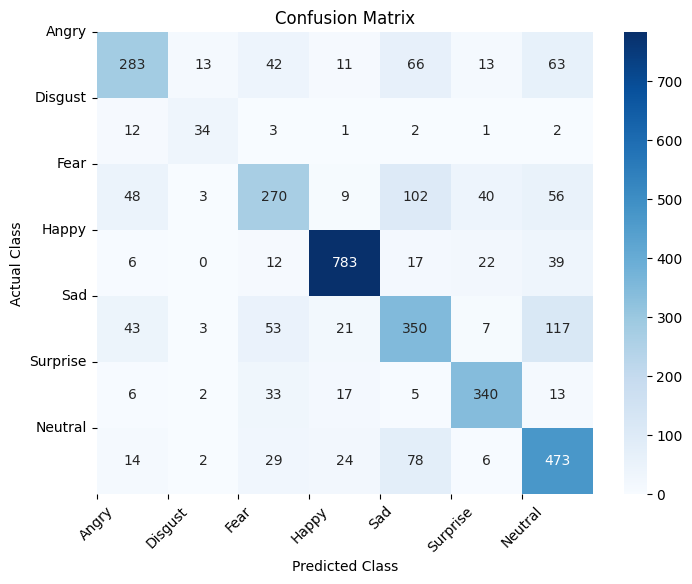

100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:   4 | Train acc: 85.54 | Val acc: 69.04 | Train loss: 0.4129 | Val loss: 0.9786 | Confusion matrix: [[274  11  41  30  55  11  45]
 [  8  35   4   1   7   0   1]
 [ 39   3 226  19 103  44  62]
 [  7   0   8 820   6  13  41]
 [ 77   2  54  24 360  11 125]
 [  6   0  22  20   3 350  14]
 [ 24   2  32  67  65   4 413]]
overwriting the best model!
epoch:   4 | Test acc: 70.55 | Test loss: 0.9131 | Test Confusion matrix: [[301   9  51  14  62  10  44]
 [  6  42   3   1   2   0   1]
 [ 46   2 281  23  78  40  58]
 [  5   0   8 807  19  13  27]
 [ 47   5  66  32 307   7 130]
 [  9   1  31  27   3 334  11]
 [ 23   0  31  45  60   7 460]]


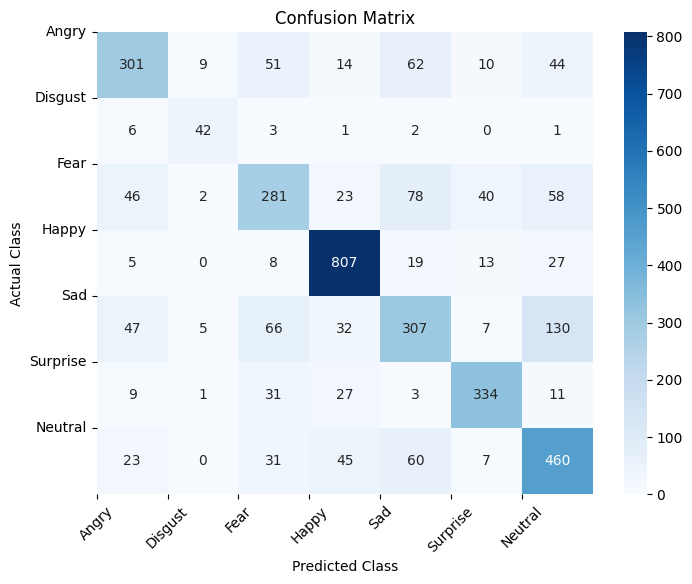

100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:   5 | Train acc: 91.33 | Val acc: 67.99 | Train loss: 0.2537 | Val loss: 1.1211 | Confusion matrix: [[261  17  67  16  64  10  32]
 [ 11  36   3   1   3   0   2]
 [ 33   2 284   8  95  23  51]
 [ 11   2  29 733  19   9  92]
 [ 53   1  76  11 405   9  98]
 [  4   1  67  11   8 316   8]
 [ 23   3  39  38  97   2 405]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:   6 | Train acc: 94.42 | Val acc: 69.02 | Train loss: 0.1626 | Val loss: 1.3421 | Confusion matrix: [[292   4  41  25  30  14  61]
 [ 13  30   2   2   5   0   4]
 [ 45   1 269  18  48  39  76]
 [  8   1   8 800   6  16  56]
 [ 69   0  95  26 285  14 164]
 [ 10   0  21  14   3 356  11]
 [ 22   1  39  57  35   8 445]]


100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:   7 | Train acc: 96.13 | Val acc: 69.57 | Train loss: 0.1143 | Val loss: 1.3685 | Confusion matrix: [[292  14  48  20  52  15  26]
 [ 10  38   4   1   2   0   1]
 [ 45   1 268  10  89  39  44]
 [ 14   3  24 769  17  26  42]
 [ 74   3  63  13 407  12  81]
 [ 14   0  31  11   8 342   9]
 [ 31   3  37  51  89  15 381]]
overwriting the best model!
epoch:   7 | Test acc: 69.46 | Test loss: 1.3064 | Test Confusion matrix: [[299  17  58  10  68   9  30]
 [  6  43   3   0   1   1   1]
 [ 60   3 296   7  92  31  39]
 [ 12   1  13 773  19  21  40]
 [ 55   7  76  21 326   8 101]
 [ 11   2  36  12   6 340   9]
 [ 29   3  39  29 102   8 416]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:   8 | Train acc: 96.54 | Val acc: 68.38 | Train loss: 0.1005 | Val loss: 1.4419 | Confusion matrix: [[300   3  57  17  59   4  27]
 [ 22  27   2   1   4   0   0]
 [ 55   2 242   8 127  32  30]
 [ 20   0  17 772  18  16  52]
 [ 75   0  54  12 443   6  63]
 [ 12   0  42  10  12 332   7]
 [ 46   0  33  48 135   7 338]]


100%|██████████| 113/113 [00:18<00:00,  6.00it/s]


epoch:   9 | Train acc: 97.23 | Val acc: 69.16 | Train loss: 0.0849 | Val loss: 1.5816 | Confusion matrix: [[245   4  62  22  96  11  27]
 [  8  33   4   1   9   0   1]
 [ 30   1 264  12 111  33  45]
 [ 11   1  18 775  25  15  50]
 [ 43   1  53  18 458   7  73]
 [  5   0  27  18  15 339  11]
 [ 18   2  31  50 130   8 368]]


100%|██████████| 113/113 [00:18<00:00,  6.05it/s]


epoch:  10 | Train acc: 97.49 | Val acc: 69.80 | Train loss: 0.0757 | Val loss: 1.5608 | Confusion matrix: [[327   8  38  15  52  10  17]
 [ 13  34   5   1   2   0   1]
 [ 57   0 260  12 101  38  28]
 [ 21   1  16 779  14  22  42]
 [ 90   1  55  19 411  19  58]
 [ 11   0  24   6   9 361   4]
 [ 53   1  35  51 123  11 333]]
overwriting the best model!
epoch:  10 | Test acc: 69.16 | Test loss: 1.5192 | Test Confusion matrix: [[321   8  54   9  65  10  24]
 [ 12  38   2   1   0   1   1]
 [ 75   6 278   9  94  37  29]
 [ 21   1   9 776  23  21  28]
 [ 73   6  60  23 341  13  78]
 [  8   2  34  12   9 347   4]
 [ 51   1  38  37 106  12 381]]


100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:  11 | Train acc: 97.46 | Val acc: 69.16 | Train loss: 0.0745 | Val loss: 1.6153 | Confusion matrix: [[314   5  41  23  36   6  42]
 [ 16  31   1   1   5   0   2]
 [ 54   0 257  18  79  41  47]
 [ 15   0   9 784   7  16  64]
 [ 93   3  83  35 335  10  94]
 [ 15   0  16  15   5 353  11]
 [ 40   3  25  51  71   9 408]]


100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:  12 | Train acc: 97.83 | Val acc: 69.24 | Train loss: 0.0648 | Val loss: 1.6731 | Confusion matrix: [[306   9  38  21  40  11  42]
 [ 12  36   1   0   5   1   1]
 [ 68   3 229  16  91  42  47]
 [ 10   3  14 795  12  21  40]
 [ 91   3  52  21 391  11  84]
 [ 11   0  23  14   5 347  15]
 [ 44   2  27  80  69   4 381]]


100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:  13 | Train acc: 97.89 | Val acc: 69.35 | Train loss: 0.0627 | Val loss: 1.6386 | Confusion matrix: [[291   7  44  23  53  15  34]
 [ 14  31   3   2   3   0   3]
 [ 43   2 247  17 106  44  37]
 [  8   2  12 790   6  26  51]
 [ 63   0  67  37 397  13  76]
 [  6   0  21  12   9 359   8]
 [ 26   1  30  60 108   8 374]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  14 | Train acc: 98.02 | Val acc: 68.29 | Train loss: 0.0599 | Val loss: 1.7254 | Confusion matrix: [[282  11  61  19  63  13  18]
 [  8  36   3   1   6   1   1]
 [ 48   2 262  12 117  26  29]
 [  6   2  23 779  23  21  41]
 [ 82   1  64  16 443   9  38]
 [ 10   0  50  10  11 327   7]
 [ 50   1  33  55 142   4 322]]


100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:  15 | Train acc: 98.07 | Val acc: 69.71 | Train loss: 0.0546 | Val loss: 1.6305 | Confusion matrix: [[267   9  53  19  69  13  37]
 [  7  37   3   1   7   0   1]
 [ 32   0 266  14  99  41  44]
 [ 13   0   9 778  29  21  45]
 [ 61   4  52  19 415  11  91]
 [  8   0  17  14  10 356  10]
 [ 24   2  34  52 103   9 383]]


100%|██████████| 113/113 [00:18<00:00,  6.00it/s]


epoch:  16 | Train acc: 98.07 | Val acc: 69.46 | Train loss: 0.0569 | Val loss: 1.6678 | Confusion matrix: [[311   2  49  22  40  11  32]
 [  9  38   0   0   5   0   4]
 [ 53   1 271  12  73  38  48]
 [ 16   0  12 783  13  13  58]
 [ 85   2  86  23 372   9  76]
 [ 15   0  18  17   9 347   9]
 [ 46   2  47  47  88   6 371]]
epoch:  16 | Test acc: 70.33 | Test loss: 1.5495 | Test Confusion matrix: [[311   7  50  10  66   9  38]
 [  9  39   2   1   2   1   1]
 [ 61   2 292  11  78  41  43]
 [ 12   2   9 775  18  16  47]
 [ 60   5  81  20 336   3  89]
 [ 11   0  29  22   8 337   9]
 [ 32   1  43  25  84   7 434]]
Early stopping at epoch 16
epoch:  16 | Test acc: 70.33 | Test loss: 1.5495 | Test Confusion matrix: [[311   7  50  10  66   9  38]
 [  9  39   2   1   2   1   1]
 [ 61   2 292  11  78  41  43]
 [ 12   2   9 775  18  16  47]
 [ 60   5  81  20 336   3  89]
 [ 11   0  29  22   8 337   9]
 [ 32   1  43  25  84   7 434]]


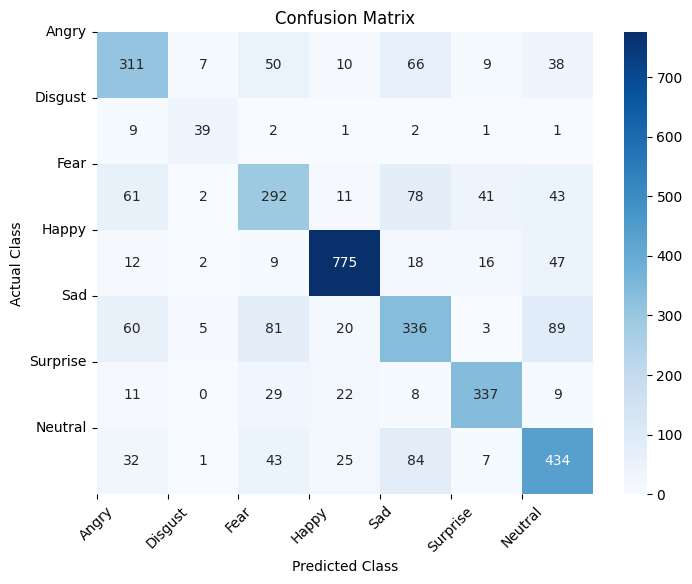

wandb: Agent Starting Run: d7gh2hlv with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0005
wandb: 	weight_decay: 0


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 113/113 [00:18<00:00,  5.95it/s]


epoch:   1 | Train acc: 57.48 | Val acc: 61.83 | Train loss: 1.1268 | Val loss: 1.0533 | Confusion matrix: [[265   9  43  31  19  31  69]
 [ 24  23   3   2   0   4   0]
 [ 81   4 170  22  72  88  59]
 [ 17   3  17 805   4  22  27]
 [114   6  68  48 229  27 161]
 [ 11   0  16  18   2 361   7]
 [ 45   3  25  95  50  23 366]]
overwriting the best model!
epoch:   1 | Test acc: 62.91 | Test loss: 0.9858 | Test Confusion matrix: [[297   6  42  31  30  23  62]
 [ 27  16   2   2   3   4   1]
 [ 94   5 172  34  58 100  65]
 [ 14   0  16 801   8  20  20]
 [ 93   5  68  49 223  17 139]
 [  9   1  25  28   2 345   6]
 [ 31   1  24  80  57  29 404]]


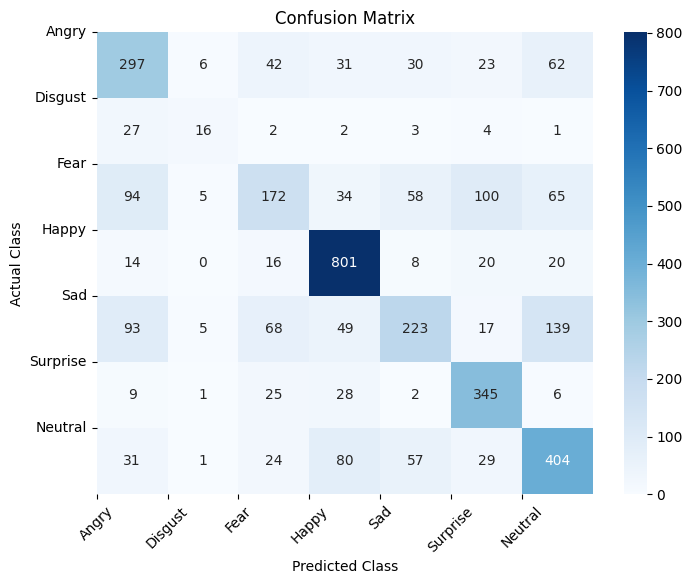

100%|██████████| 113/113 [00:18<00:00,  6.00it/s]


epoch:   2 | Train acc: 66.52 | Val acc: 65.67 | Train loss: 0.9035 | Val loss: 0.9381 | Confusion matrix: [[309  11  18  14  74  10  31]
 [ 19  31   1   0   4   1   0]
 [ 79   6 114  13 190  61  33]
 [ 32   3   6 787  11  33  23]
 [ 79  10  23  29 446  11  55]
 [ 22   0  11   9  16 355   2]
 [ 47   4  12  78 142   9 315]]
overwriting the best model!
epoch:   2 | Test acc: 66.01 | Test loss: 0.9184 | Test Confusion matrix: [[320  10  16  15  83  13  34]
 [ 15  32   1   2   2   2   1]
 [107   8 129  14 155  72  43]
 [ 31   0   4 783  22  26  13]
 [ 53  10  16  22 416  11  66]
 [ 24   1  22  19  11 335   4]
 [ 42   4  17  49 154   6 354]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:   3 | Train acc: 70.57 | Val acc: 65.53 | Train loss: 0.7947 | Val loss: 0.9365 | Confusion matrix: [[311   3  38   3  40   7  65]
 [ 27  17   1   1   6   0   4]
 [ 80   1 213   5 102  35  60]
 [ 32   0  19 714  20  28  82]
 [ 91   0  70   7 331   5 149]
 [ 17   0  51  10   3 323  11]
 [ 41   0  32  22  67   2 443]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:   4 | Train acc: 74.63 | Val acc: 66.56 | Train loss: 0.6948 | Val loss: 0.9731 | Confusion matrix: [[245  23  36  27  42  25  69]
 [  5  41   3   2   2   0   3]
 [ 44   9 213  10  82  66  72]
 [  8   1  13 783  10  36  44]
 [ 53  13  75  27 310  27 148]
 [  6   1  24   8   4 366   6]
 [ 16   4  23  48  46  39 431]]
overwriting the best model!
epoch:   4 | Test acc: 68.10 | Test loss: 0.9037 | Test Confusion matrix: [[255  30  49  25  43  18  71]
 [  5  44   1   2   0   2   1]
 [ 60  10 241  14  77  66  60]
 [  7   2   5 789  10  36  30]
 [ 30   7  62  28 299  18 150]
 [  2   4  40  11   3 351   5]
 [ 11   2  33  35  53  27 465]]


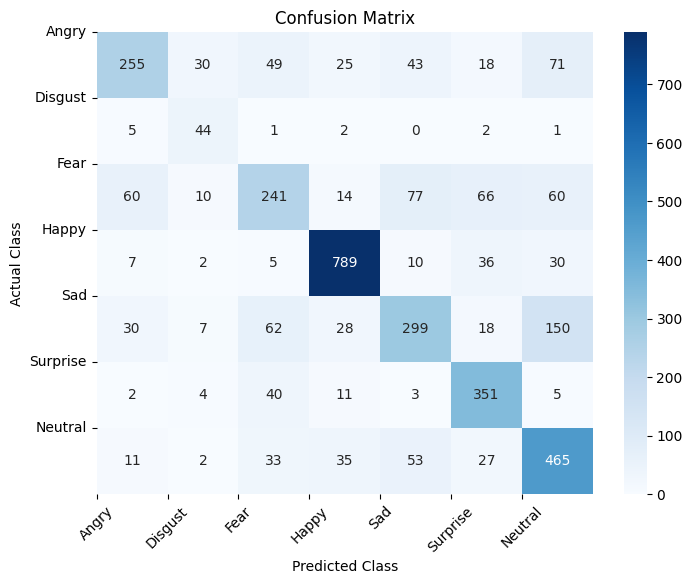

100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:   5 | Train acc: 78.49 | Val acc: 68.04 | Train loss: 0.5913 | Val loss: 0.9575 | Confusion matrix: [[262   2  80  16  46  14  47]
 [ 17  18   5   1  12   2   1]
 [ 29   0 261   6  99  37  64]
 [ 13   0  17 750   9  20  86]
 [ 58   0  77  13 348   9 148]
 [  8   0  31  13   6 345  12]
 [ 24   0  29  25  65   6 458]]
overwriting the best model!
epoch:   5 | Test acc: 69.38 | Test loss: 0.8909 | Test Confusion matrix: [[275   2  81  12  51   8  62]
 [ 17  16   9   1   9   0   3]
 [ 33   0 299  11  78  45  62]
 [  4   0  23 751  14  16  71]
 [ 35   0  70  10 325   7 147]
 [  5   0  53  20   7 322   9]
 [ 22   0  36  13  47   6 502]]


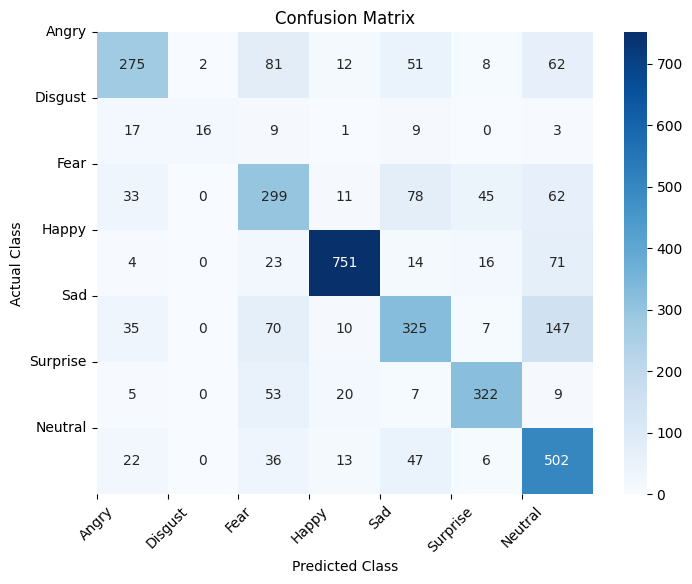

100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:   6 | Train acc: 82.62 | Val acc: 67.09 | Train loss: 0.4882 | Val loss: 1.1499 | Confusion matrix: [[260  13  49  26  19  13  87]
 [  7  35   6   1   3   0   4]
 [ 44   1 269   9  42  36  95]
 [  8   1  10 802   2  23  49]
 [ 70   4 107  41 228   9 194]
 [  4   0  36  20   3 342  10]
 [ 14   1  27  61  27   5 472]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:   7 | Train acc: 85.74 | Val acc: 67.18 | Train loss: 0.3987 | Val loss: 1.0619 | Confusion matrix: [[298  12  65  13  43   4  32]
 [  9  36   4   1   5   0   1]
 [ 43   4 302   5  77  23  42]
 [ 22   1  41 742  23  21  45]
 [ 85   3 117  16 354   6  72]
 [ 11   0  70  14   6 308   6]
 [ 40   1  55  46  91   3 371]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:   8 | Train acc: 88.56 | Val acc: 68.63 | Train loss: 0.3230 | Val loss: 1.1020 | Confusion matrix: [[273  12  57  19  44  22  40]
 [ 10  36   3   1   5   1   0]
 [ 44   4 267  10  71  51  49]
 [ 13   1  16 789   8  31  37]
 [ 68   5 106  24 353  12  85]
 [  9   0  18  14   4 367   3]
 [ 22   3  43  68  79  14 378]]
overwriting the best model!
epoch:   8 | Test acc: 68.90 | Test loss: 1.0551 | Test Confusion matrix: [[285   9  69  12  47  23  46]
 [  7  43   2   1   0   0   2]
 [ 51   2 275  17  68  73  42]
 [ 15   2  14 778  16  26  28]
 [ 40   0  89  25 320  12 108]
 [  5   1  27  18   4 356   5]
 [ 22   1  52  48  79   8 416]]


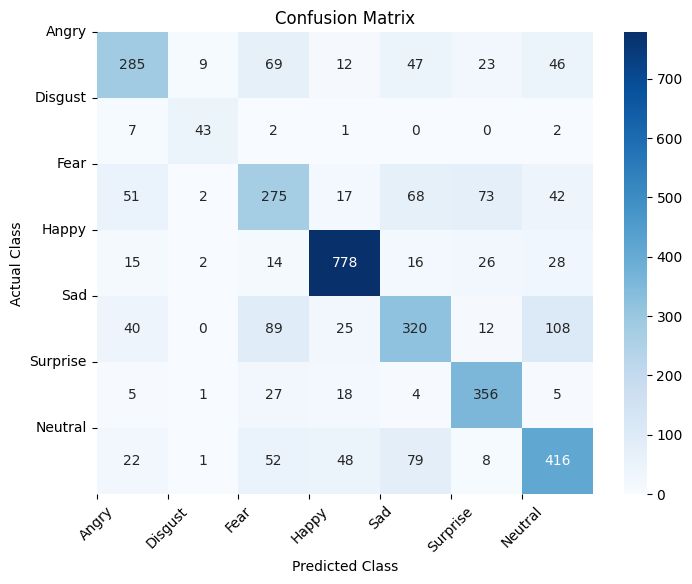

100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:   9 | Train acc: 90.77 | Val acc: 69.41 | Train loss: 0.2643 | Val loss: 1.1680 | Confusion matrix: [[274  16  28  21  68  11  49]
 [  4  42   0   1   7   1   1]
 [ 43   4 204  12 121  47  65]
 [ 14   1   6 797   8  12  57]
 [ 54  10  32  27 411  16 103]
 [ 10   0  13  27   9 347   9]
 [ 28   4  10  51  90   8 416]]
overwriting the best model!
epoch:   9 | Test acc: 68.88 | Test loss: 1.1415 | Test Confusion matrix: [[280  16  43  20  72  11  49]
 [  8  42   2   2   0   0   1]
 [ 53   8 216  23 105  62  61]
 [ 10   0   7 791  14  15  42]
 [ 41   5  37  23 348  14 126]
 [  6   2  22  35   6 336   9]
 [ 29   1  12  27  88  10 459]]


100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:  10 | Train acc: 92.79 | Val acc: 66.59 | Train loss: 0.2125 | Val loss: 1.2816 | Confusion matrix: [[335   5  32   8  51   5  31]
 [ 16  31   2   1   5   0   1]
 [ 76   1 231   3 102  39  44]
 [ 34   0  30 673  18  31 109]
 [ 83   4  78  17 370  11  90]
 [ 24   0  25  10   6 339  11]
 [ 51   0  28  24  87   6 411]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  11 | Train acc: 93.22 | Val acc: 68.65 | Train loss: 0.1907 | Val loss: 1.2781 | Confusion matrix: [[305  14  33  16  51  12  36]
 [ 14  36   1   1   3   1   0]
 [ 52   4 227   5 107  51  50]
 [ 35   1  14 733  29  29  54]
 [ 62   3  56  12 407   9 104]
 [ 10   2  14  11  10 354  14]
 [ 28   2  19  36 112   8 402]]


100%|██████████| 113/113 [00:18<00:00,  6.00it/s]


epoch:  12 | Train acc: 94.24 | Val acc: 67.93 | Train loss: 0.1673 | Val loss: 1.3756 | Confusion matrix: [[256  15  40  43  58  22  33]
 [  6  40   2   3   3   1   1]
 [ 31   5 237  22  97  53  51]
 [  7   0   8 820  10  19  31]
 [ 60  10  76  51 349  19  88]
 [  5   0  20  28   5 351   6]
 [ 20   4  27  69  94   8 385]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:  13 | Train acc: 94.78 | Val acc: 67.82 | Train loss: 0.1508 | Val loss: 1.3877 | Confusion matrix: [[268   2  65  13  73   9  37]
 [  6  37   6   1   6   0   0]
 [ 40   1 270   3 119  26  37]
 [ 16   0  26 756  29  20  48]
 [ 42   1  81  29 440   2  58]
 [ 11   0  47  17   8 321  11]
 [ 26   0  49  50 137   3 342]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  14 | Train acc: 95.40 | Val acc: 68.68 | Train loss: 0.1349 | Val loss: 1.4334 | Confusion matrix: [[260   5  89  18  52   4  39]
 [ 10  33   6   1   6   0   0]
 [ 35   3 269  15 109  25  40]
 [ 20   1  20 780  15  18  41]
 [ 49   2  74  31 401   7  89]
 [  7   1  57  13  11 315  11]
 [ 20   1  34  57  88   0 407]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:  15 | Train acc: 95.55 | Val acc: 68.90 | Train loss: 0.1303 | Val loss: 1.4527 | Confusion matrix: [[294   5  48  27  45  15  33]
 [ 12  32   3   1   8   0   0]
 [ 50   2 251  16  87  45  45]
 [ 18   0  11 797   9  31  29]
 [ 76   1  67  43 347   9 110]
 [ 10   0  30  11   2 357   5]
 [ 46   0  31  65  56  14 395]]
epoch:  15 | Test acc: 69.13 | Test loss: 1.3352 | Test Confusion matrix: [[305   2  53  21  54  16  40]
 [ 10  38   3   1   2   0   1]
 [ 62   5 272  24  75  44  46]
 [  3   0  10 801  12  26  27]
 [ 60   1  65  41 300  12 115]
 [  9   1  35  19   5 341   6]
 [ 62   1  29  50  48  12 424]]
Early stopping at epoch 15
epoch:  15 | Test acc: 69.13 | Test loss: 1.3352 | Test Confusion matrix: [[305   2  53  21  54  16  40]
 [ 10  38   3   1   2   0   1]
 [ 62   5 272  24  75  44  46]
 [  3   0  10 801  12  26  27]
 [ 60   1  65  41 300  12 115]
 [  9   1  35  19   5 341   6]
 [ 62   1  29  50  48  12 424]]


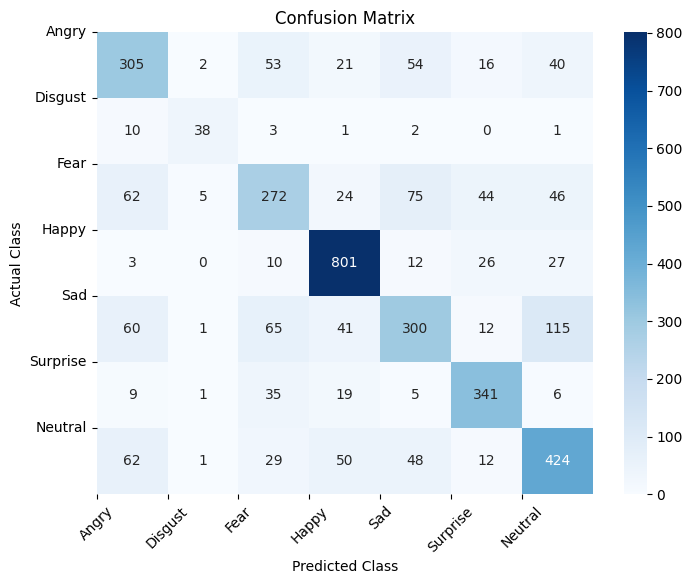

wandb: Agent Starting Run: 0qf94p2x with config:
wandb: 	batch_size: 16
wandb: 	lr: 0.0005
wandb: 	weight_decay: 0.001


device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:   1 | Train acc: 57.72 | Val acc: 62.61 | Train loss: 1.1225 | Val loss: 1.0208 | Confusion matrix: [[274  16  46  33  28  17  53]
 [ 22  24   5   2   1   2   0]
 [ 79  10 182  22  77  78  48]
 [ 16   5  14 786  12  27  35]
 [106   9  77  43 290  25 103]
 [ 13   2  24  16   3 346  11]
 [ 48   4  36  72  87  15 345]]
overwriting the best model!
epoch:   1 | Test acc: 64.17 | Test loss: 0.9547 | Test Confusion matrix: [[301  18  42  30  32  12  56]
 [ 22  23   4   1   3   1   1]
 [ 98  17 193  25  73  79  43]
 [ 10   4  12 796  14  22  21]
 [ 90  12  69  42 275  12  94]
 [ 13   3  34  25   2 335   4]
 [ 38   3  38  55  94  18 380]]


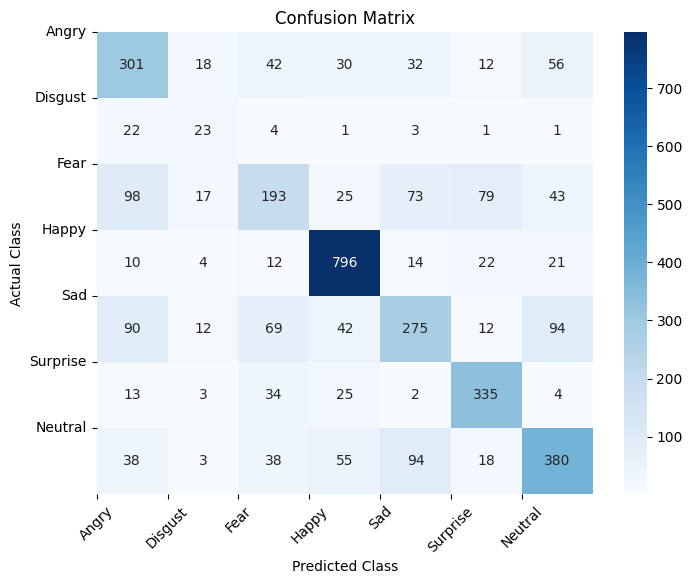

100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:   2 | Train acc: 66.22 | Val acc: 65.65 | Train loss: 0.9048 | Val loss: 0.9375 | Confusion matrix: [[332   8   9  15  60  13  30]
 [ 19  30   1   1   4   0   1]
 [ 88   9 115  13 169  61  41]
 [ 35   3   3 776   9  34  35]
 [101   8  23  25 414  10  72]
 [ 24   0  14  10  15 343   9]
 [ 65   0  12  64 116   4 346]]
overwriting the best model!
epoch:   2 | Test acc: 66.62 | Test loss: 0.8973 | Test Confusion matrix: [[346   8  15   9  67  11  35]
 [ 18  32   1   1   1   1   1]
 [126   9 117  15 145  65  51]
 [ 35   1   3 785  13  22  20]
 [ 74   8  16  18 395   5  78]
 [ 22   0  24  19  12 331   8]
 [ 57   1  14  38 126   5 385]]


100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:   3 | Train acc: 70.36 | Val acc: 64.92 | Train loss: 0.7946 | Val loss: 0.9613 | Confusion matrix: [[285   4  25  12  54  11  76]
 [ 23  20   3   1   5   0   4]
 [ 70   0 138  10 160  39  79]
 [ 25   0   5 728  28  23  86]
 [ 69   0  19  10 394   6 155]
 [ 11   0  43   9   7 319  26]
 [ 26   0   8  25 100   2 446]]


100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:   4 | Train acc: 74.36 | Val acc: 66.62 | Train loss: 0.7003 | Val loss: 0.9382 | Confusion matrix: [[287  17  46  19  23   9  66]
 [  6  39   3   2   4   0   2]
 [ 76   3 225  11  58  45  78]
 [ 14   1  11 775   5  31  58]
 [ 70   1  87  29 255  17 194]
 [ 10   0  33  11   3 354   4]
 [ 31   0  32  44  23  21 456]]
overwriting the best model!
epoch:   4 | Test acc: 69.07 | Test loss: 0.8653 | Test Confusion matrix: [[310  11  40  22  31  12  65]
 [  3  43   3   3   1   0   2]
 [ 88   3 260  15  50  43  69]
 [  8   2   8 787  11  27  36]
 [ 47   1  80  27 240  10 189]
 [ 11   3  39  16   1 340   6]
 [ 16   5  44  26  28   8 499]]


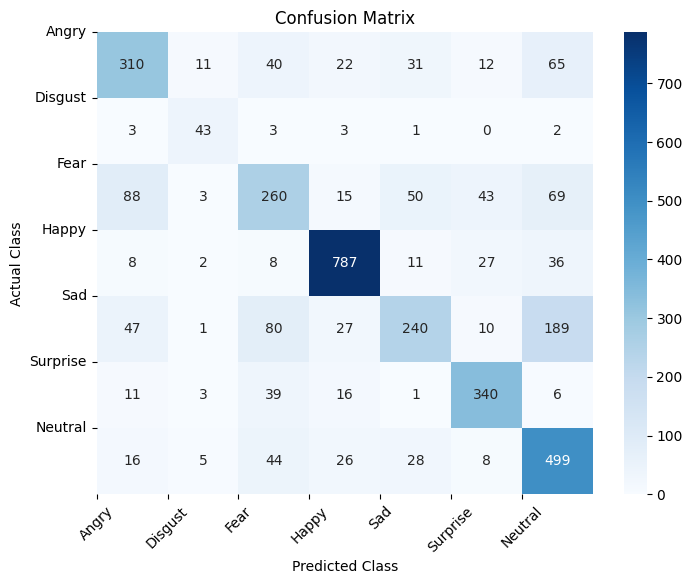

100%|██████████| 113/113 [00:19<00:00,  5.94it/s]


epoch:   5 | Train acc: 78.16 | Val acc: 67.99 | Train loss: 0.5995 | Val loss: 0.9559 | Confusion matrix: [[294   1 101  11  30  10  20]
 [ 23  17   7   1   6   2   0]
 [ 51   0 289   5  77  40  34]
 [ 27   0  22 781   4  23  38]
 [ 87   0 115  21 340  12  78]
 [  8   0  42  11   5 342   7]
 [ 45   0  63  54  65   3 377]]
overwriting the best model!
epoch:   5 | Test acc: 69.13 | Test loss: 0.8956 | Test Confusion matrix: [[292   0 109  10  39   4  37]
 [ 26  15   9   1   3   0   1]
 [ 38   0 342   9  62  44  33]
 [ 13   0  29 772  11  26  28]
 [ 70   0 106  18 304   5  91]
 [  8   0  45  19   4 330  10]
 [ 42   1  58  26  69   4 426]]


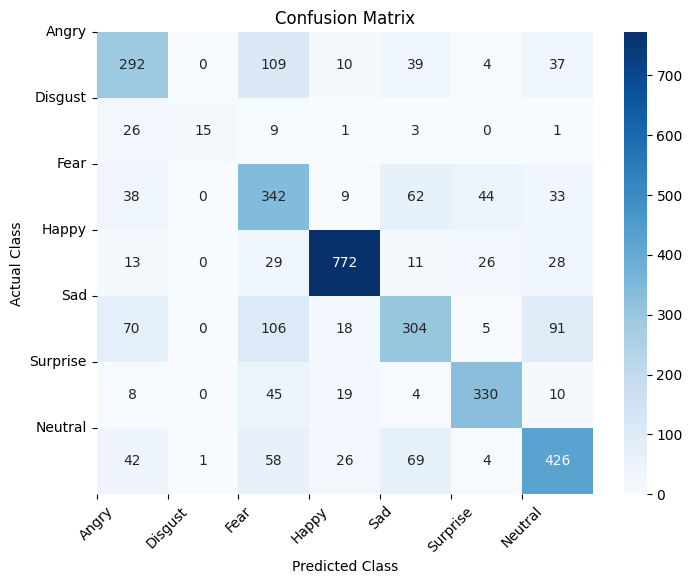

100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:   6 | Train acc: 82.15 | Val acc: 67.37 | Train loss: 0.4966 | Val loss: 1.0469 | Confusion matrix: [[286  18  53  21  18  14  57]
 [  7  39   3   2   2   0   3]
 [ 48   1 287  13  38  41  68]
 [  9   0  12 794   6  18  56]
 [ 53   6 172  34 207  12 169]
 [  5   0  32  18   2 341  17]
 [ 21   2  58  38  17   7 464]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:   7 | Train acc: 85.04 | Val acc: 66.51 | Train loss: 0.4175 | Val loss: 1.0895 | Confusion matrix: [[288   9  99   8  25   7  31]
 [ 19  29   3   0   4   0   1]
 [ 48   3 298   7  63  29  48]
 [ 50   0  28 743   5  22  47]
 [102   3  97  15 320   9 107]
 [ 10   0  66  11   3 314  11]
 [ 55   0  50  42  57   8 395]]


100%|██████████| 113/113 [00:18<00:00,  6.01it/s]


epoch:   8 | Train acc: 87.84 | Val acc: 68.21 | Train loss: 0.3416 | Val loss: 1.1387 | Confusion matrix: [[277   9  74  15  43  12  37]
 [ 14  27   4   2   7   1   1]
 [ 30   4 290  13  68  52  39]
 [ 15   0  15 794  13  21  37]
 [ 64   4 141  19 343  10  72]
 [  4   0  28  12   2 362   7]
 [ 37   3  65  63  76   8 355]]
overwriting the best model!
epoch:   8 | Test acc: 69.55 | Test loss: 1.0388 | Test Confusion matrix: [[292   6  76  16  43  13  45]
 [ 11  36   5   2   0   0   1]
 [ 44   4 326  21  52  46  35]
 [ 11   0  25 791  10  20  22]
 [ 35   3 133  27 295   8  93]
 [  7   0  28  19   2 355   5]
 [ 33   1  71  41  68  11 401]]


100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:   9 | Train acc: 90.41 | Val acc: 67.87 | Train loss: 0.2748 | Val loss: 1.1748 | Confusion matrix: [[249  23  66  17  51  23  38]
 [  4  40   4   1   4   0   3]
 [ 36  10 256   8  76  51  59]
 [ 12   4   8 794  15  23  39]
 [ 54   7  88  26 335  14 129]
 [  8   0  20  18   7 355   7]
 [ 29   5  25  65  65  11 407]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  10 | Train acc: 92.04 | Val acc: 67.62 | Train loss: 0.2303 | Val loss: 1.3266 | Confusion matrix: [[313  10  50  24  36  15  19]
 [  9  36   1   3   2   4   1]
 [ 58   1 245   9  94  58  31]
 [ 23   0  14 793  14  32  19]
 [ 80   5  85  28 395  12  48]
 [ 10   1  26  13   4 356   5]
 [ 61   1  35  73 134  14 289]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  11 | Train acc: 93.18 | Val acc: 68.35 | Train loss: 0.1989 | Val loss: 1.4399 | Confusion matrix: [[296   8  42  17  32  22  50]
 [ 14  31   0   1   5   1   4]
 [ 61   2 216  11  65  74  67]
 [ 16   1  15 781   4  29  49]
 [ 83   2  55  17 329  16 151]
 [  6   0   9  12   5 375   8]
 [ 41   1  18  46  54  22 425]]
overwriting the best model!
epoch:  11 | Test acc: 69.38 | Test loss: 1.3020 | Test Confusion matrix: [[299  10  44  18  33  20  67]
 [ 11  38   2   1   0   1   2]
 [ 48   5 245  11  69  83  67]
 [ 11   0   7 780  15  28  38]
 [ 54   5  44  19 283  17 172]
 [  7   1  21  13   1 367   6]
 [ 33   1  27  26  44  17 478]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:  12 | Train acc: 94.11 | Val acc: 67.96 | Train loss: 0.1704 | Val loss: 1.3848 | Confusion matrix: [[285   6  63  24  46  12  31]
 [ 13  35   3   1   3   0   1]
 [ 42   0 276   9  79  48  42]
 [  8   0  19 795  12  19  42]
 [ 73   6 116  36 336   9  77]
 [ 10   0  23  16   5 356   5]
 [ 34   2  57  63  88   7 356]]


100%|██████████| 113/113 [00:18<00:00,  6.03it/s]


epoch:  13 | Train acc: 94.41 | Val acc: 67.68 | Train loss: 0.1627 | Val loss: 1.3667 | Confusion matrix: [[291  14  56  12  45  10  39]
 [ 14  32   2   1   6   0   1]
 [ 53   1 241   5 110  41  45]
 [ 24   0  27 723  31  20  70]
 [ 61   3  77  14 396   8  94]
 [ 11   1  23  11  10 348  11]
 [ 48   1  30  34  88   8 398]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  14 | Train acc: 95.29 | Val acc: 68.24 | Train loss: 0.1401 | Val loss: 1.3890 | Confusion matrix: [[320  10  42  17  38  10  30]
 [  9  38   2   1   6   0   0]
 [ 54   4 238  14  99  43  44]
 [ 27   2  18 766  19  17  46]
 [ 96   3  64  26 374   5  85]
 [ 19   0  21  16  10 345   4]
 [ 54   1  27  58  86  13 368]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:  15 | Train acc: 95.78 | Val acc: 67.34 | Train loss: 0.1286 | Val loss: 1.4398 | Confusion matrix: [[271   5  56  18  82   9  26]
 [  8  31   5   1   9   0   2]
 [ 39   0 265   7 106  43  36]
 [ 19   0  18 754  25  31  48]
 [ 45   1  76  18 418  11  84]
 [  5   0  35  13   4 353   5]
 [ 41   0  51  51 116  23 325]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:  16 | Train acc: 95.56 | Val acc: 68.49 | Train loss: 0.1313 | Val loss: 1.4562 | Confusion matrix: [[298  18  59  13  41   7  31]
 [  7  39   4   2   3   0   1]
 [ 42   4 253  12 108  33  44]
 [ 23   6  14 768  14  20  50]
 [ 70   5  70  26 394   9  79]
 [  6   0  29  16   8 348   8]
 [ 53   1  33  56  98   8 358]]
overwriting the best model!
epoch:  16 | Test acc: 69.55 | Test loss: 1.3251 | Test Confusion matrix: [[301  20  50  16  58  12  34]
 [  5  43   5   1   0   0   1]
 [ 60   8 279  17  93  34  37]
 [ 13   2  10 776  19  17  42]
 [ 60   6  54  27 357   6  84]
 [  7   1  45  19   5 332   7]
 [ 51   5  32  31  92   7 408]]


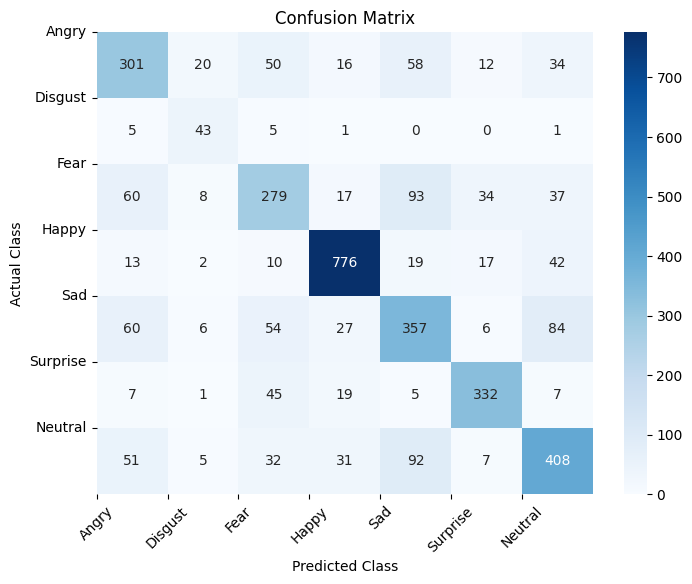

100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


epoch:  17 | Train acc: 96.19 | Val acc: 67.29 | Train loss: 0.1135 | Val loss: 1.5430 | Confusion matrix: [[261  12  51  12  70  15  46]
 [  6  31   3   3  11   0   2]
 [ 34   0 225   6 138  45  48]
 [ 17   0  23 727  28  33  67]
 [ 43   1  55  13 439   6  96]
 [  4   0  24  11  14 351  11]
 [ 28   2  23  34 128  11 381]]


100%|██████████| 113/113 [00:18<00:00,  5.95it/s]


epoch:  18 | Train acc: 95.99 | Val acc: 68.04 | Train loss: 0.1168 | Val loss: 1.5346 | Confusion matrix: [[253  12  59  20  74  14  35]
 [  8  32   6   2   6   0   2]
 [ 38   1 241   9 106  53  48]
 [  9   1  16 755  34  26  54]
 [ 56   3  69  13 412   7  93]
 [  8   0  23  16   3 351  14]
 [ 34   0  32  47  90   6 398]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:  19 | Train acc: 96.13 | Val acc: 67.85 | Train loss: 0.1138 | Val loss: 1.5917 | Confusion matrix: [[282  11  37  16  49   8  64]
 [ 12  33   2   1   6   0   2]
 [ 48   2 227  12  90  37  80]
 [ 16   0  15 777  13  18  56]
 [ 70   2  41  17 337   7 179]
 [ 11   0  30  16   6 337  15]
 [ 30   0  18  47  64   6 442]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  20 | Train acc: 96.33 | Val acc: 67.90 | Train loss: 0.1078 | Val loss: 1.6371 | Confusion matrix: [[308   5  57  16  32  17  32]
 [ 12  32   3   2   5   1   1]
 [ 57   2 258  15  70  46  48]
 [ 20   0  11 780   7  31  46]
 [ 97   3  96  27 326  11  93]
 [ 10   0  18  14   6 363   4]
 [ 61   3  30  70  61  12 370]]


100%|██████████| 113/113 [00:18<00:00,  5.96it/s]


epoch:  21 | Train acc: 96.76 | Val acc: 68.88 | Train loss: 0.0973 | Val loss: 1.6080 | Confusion matrix: [[270   4  51  15  65  11  51]
 [  8  33   1   2   9   0   3]
 [ 40   1 257  10  97  34  57]
 [ 14   2  16 745  18  30  70]
 [ 46   2  64  18 417  15  91]
 [  7   1  30  16  10 341  10]
 [ 23   2  24  39 103   7 409]]
overwriting the best model!
epoch:  21 | Test acc: 69.43 | Test loss: 1.5512 | Test Confusion matrix: [[272   8  51  13  77  11  59]
 [ 10  33   6   2   1   1   2]
 [ 52   1 272  10 104  36  53]
 [  6   1  13 755  20  29  55]
 [ 29   1  53  19 372   6 114]
 [  7   1  42  11   9 333  13]
 [ 13   2  31  21  97   7 455]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:  22 | Train acc: 96.88 | Val acc: 68.29 | Train loss: 0.0952 | Val loss: 1.5804 | Confusion matrix: [[324   7  17  14  60  10  35]
 [ 11  33   3   2   5   1   1]
 [ 79   2 212   9 111  35  48]
 [ 44   1  12 752  18  15  53]
 [ 83   4  39  19 393   8 107]
 [ 17   0  20  20  10 337  11]
 [ 53   4  14  40  92   4 400]]


100%|██████████| 113/113 [00:18<00:00,  5.99it/s]


epoch:  23 | Train acc: 97.12 | Val acc: 68.88 | Train loss: 0.0864 | Val loss: 1.5916 | Confusion matrix: [[315   7  37  17  54   5  32]
 [  9  36   1   1   8   0   1]
 [ 69   2 240  10 118  27  30]
 [ 22   2  16 775  22  24  34]
 [ 76   4  43  19 420   8  83]
 [ 13   0  43  19  12 321   7]
 [ 43   1  28  55 109   6 365]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:  24 | Train acc: 96.83 | Val acc: 67.51 | Train loss: 0.0931 | Val loss: 1.7106 | Confusion matrix: [[315  11  37  26  32   8  38]
 [ 10  33   4   3   4   0   2]
 [ 72   3 234  35  70  38  44]
 [ 10   1  11 810   3  15  45]
 [ 89   4  85  46 297   8 124]
 [  9   0  27  26   3 342   8]
 [ 61   0  34  65  49   6 392]]


100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:  25 | Train acc: 97.12 | Val acc: 68.01 | Train loss: 0.0868 | Val loss: 1.4883 | Confusion matrix: [[265   9  68  19  75  12  19]
 [  4  40   4   1   6   0   1]
 [ 39   2 278   9  86  41  41]
 [ 12   1  20 758  23  24  57]
 [ 41   3  94  18 415   5  77]
 [  9   0  34  14   7 346   5]
 [ 31   0  54  37 136  10 339]]


100%|██████████| 113/113 [00:18<00:00,  5.97it/s]


epoch:  26 | Train acc: 97.04 | Val acc: 67.04 | Train loss: 0.0887 | Val loss: 1.6330 | Confusion matrix: [[259  23  62  30  37  21  35]
 [  7  40   4   1   3   0   1]
 [ 44   5 259  23  69  46  50]
 [ 12   1  12 800   6  19  45]
 [ 73   8  98  34 317  13 110]
 [  6   1  23  19   5 342  19]
 [ 37   6  40  61  64  10 389]]


100%|██████████| 113/113 [00:18<00:00,  5.98it/s]


epoch:  27 | Train acc: 97.35 | Val acc: 67.04 | Train loss: 0.0770 | Val loss: 1.7411 | Confusion matrix: [[222  40  74  13  74  16  28]
 [  3  45   3   0   4   0   1]
 [ 28  10 279   7  95  39  38]
 [  4   6  22 746  29  26  62]
 [ 38  18 102  18 411   9  57]
 [  4   2  13  15  17 354  10]
 [ 20   3  55  46 131   3 349]]
epoch:  27 | Test acc: 67.04 | Test loss: 1.5989 | Test Confusion matrix: [[236  27  76  14  83  10  45]
 [  3  46   5   1   0   0   0]
 [ 36  15 300   8  82  44  43]
 [  2   3  13 755  29  22  55]
 [ 32   9 104  15 352   7  75]
 [  5   3  40  11   8 331  18]
 [ 15   4  56  26 134   5 386]]
Early stopping at epoch 27
epoch:  27 | Test acc: 67.04 | Test loss: 1.5989 | Test Confusion matrix: [[236  27  76  14  83  10  45]
 [  3  46   5   1   0   0   0]
 [ 36  15 300   8  82  44  43]
 [  2   3  13 755  29  22  55]
 [ 32   9 104  15 352   7  75]
 [  5   3  40  11   8 331  18]
 [ 15   4  56  26 134   5 386]]


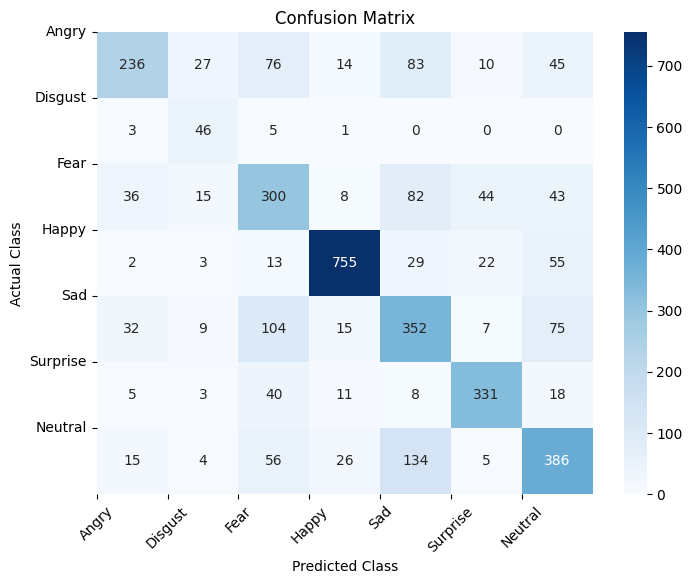

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import lr_scheduler, AdamW
import torchvision.transforms as transforms
from datetime import datetime
import time
import argparse
import torchvision.models as models
import random
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from tqdm import tqdm
import wandb
wandb.login()

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
def train_with_hyperparameters():
  wandb.init()
  config = wandb.config

  set_seed(35)
  class_dirs = ['Angry',  'Disgust', 'Fear', 'Happy',  'Sad',  'Surprise', 'Neutral']

  # Hyperparameters
  batch_size = config.batch_size
  learning_rate = config.lr
  weight_decay = config.weight_decay
  model_name = "MaxVit"
  optimizer_name = "AdamW"
  num_classes = 4
  num_worker = 4
  num_epoch = 50
  best_acc = 0
  early_stopping_thresh = 6
  LRScheduling_patience = 10
  lrs_factor = 0.2
  best_threshold = 0.0001
  early_stop_counter = 0

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("device: ", device)

  model = timm.create_model('maxvit_tiny_tf_224.in1k', pretrained=True, num_classes=7)

  model.to(device)

  optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=lrs_factor, patience=LRScheduling_patience, threshold=best_threshold, verbose=True)

  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epoch):
      model.train()
      training_loss, train_correct = 0.0, 0
      i=0
      for data, target in tqdm(train_loader):
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output, target)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          prediction = output.argmax(dim=1, keepdim=True)
          train_correct += prediction.eq(target.view_as(prediction)).sum().item()
          training_loss += loss.item()
      training_loss /= len(train_loader)
      train_accuracy = train_correct / len(train_loader.dataset)

      model.eval()
      val_loss, val_correct = 0.0, 0
      y_true, y_pred = [], []
      with torch.no_grad():
          for data, target in tqdm(val_loader):
              data, target = data.to(device), target.to(device)
              y_true.extend(target.cpu().tolist())
              output = model(data)
              loss = criterion(output, target)
              prediction = output.argmax(dim=1, keepdim=True)
              y_pred.extend(prediction.cpu().tolist())
              val_correct += prediction.eq(target.view_as(prediction)).sum().item()
              val_loss += loss.item()
      val_loss /= len(val_loader)
      val_accuracy = val_correct / len(val_loader.dataset)

      scheduler.step(val_accuracy)

      cm_4class = confusion_matrix(y_true, y_pred)
      flattened_preds = [item for sublist in y_pred for item in sublist] if isinstance(y_pred[0], list) else y_pred
      print("epoch: {:3.0f}".format(epoch + 1) + " | Train acc: {:4.2f}".format(
          train_accuracy * 100) + " | Val acc: {:4.2f}".format(
          val_accuracy * 100) + " | Train loss: {:6.4f}".format(
          training_loss) + " | Val loss: {:6.4f}".format(
          val_loss) +  " | Confusion matrix: {}".format(cm_4class))
      wandb.log({
            "epoch": epoch + 1,
            "lr": optimizer.param_groups[0]['lr'],
            'train loss': training_loss,
            'val loss': val_loss,
            'train acc': train_accuracy,
            'val acc': val_accuracy,
            'conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=flattened_preds, class_names=class_dirs)
        })


      if val_accuracy > best_acc * (1 + best_threshold):
          early_stop_counter = 0
          best_acc = val_accuracy
          print("overwriting the best model!")

          torch.save(model.state_dict(), "weights/best_" + model_name + '.pth.tar')
          model.eval()
          test_loss, test_correct = 0.0, 0
          y_true_test, y_pred_test = [], []
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  y_true_test.extend(target.cpu().tolist())
                  output = model(data)
                  loss = criterion(output, target)
                  prediction = output.argmax(dim=1, keepdim=True)
                  y_pred_test.extend(prediction.cpu().tolist())
                  test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                  test_loss += loss.item()
          test_loss /= len(test_loader)
          test_accuracy = test_correct / len(test_loader.dataset)
          cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
          flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
          print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
              test_accuracy * 100) + " | Test loss: {:6.4f}".format(
              test_loss) +  " | Test Confusion matrix: {}".format(cm_4class_test))
          wandb.log({
                "test_lr": optimizer.param_groups[0]['lr'],
                'test loss': test_loss,
                'test acc': test_accuracy,
                'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_dirs)
            })
          plt.figure(figsize=(8, 6))
          sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
          plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
          plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
          plt.xlabel("Predicted Class")
          plt.ylabel("Actual Class")
          plt.title("Confusion Matrix")
          plt.show()
      else:
          early_stop_counter += 1
      if early_stop_counter >= early_stopping_thresh:
          model.eval()
          test_loss, test_correct = 0.0, 0
          y_true_test, y_pred_test = [], []
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  y_true_test.extend(target.cpu().tolist())
                  output = model(data)
                  loss = criterion(output, target)
                  prediction = output.argmax(dim=1, keepdim=True)
                  y_pred_test.extend(prediction.cpu().tolist())
                  test_correct += prediction.eq(target.view_as(prediction)).sum().item()
                  test_loss += loss.item()
          test_loss /= len(test_loader)
          test_accuracy = test_correct / len(test_loader.dataset)
          cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
          flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
          print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
              test_accuracy * 100) + " | Test loss: {:6.4f}".format(
              test_loss) +  " | Test Confusion matrix: {}".format(cm_4class_test))
          wandb.log({
                "test_lr": optimizer.param_groups[0]['lr'],
                'test loss': test_loss,
                'test acc': test_accuracy,
                'test_conf_mat': wandb.plot.confusion_matrix(probs=None, y_true=y_true_test, preds=flattened_preds_test, class_names=class_dirs)
            })
          print("Early stopping at epoch {}".format(epoch + 1))
          break
  model.eval()
  test_loss, test_correct = 0.0, 0
  y_true_test, y_pred_test = [], []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          y_true_test.extend(target.cpu().tolist())
          output = model(data)
          loss = criterion(output, target)
          prediction = output.argmax(dim=1, keepdim=True)
          y_pred_test.extend(prediction.cpu().tolist())
          test_correct += prediction.eq(target.view_as(prediction)).sum().item()
          test_loss += loss.item()
  test_loss /= len(test_loader)
  test_accuracy = test_correct / len(test_loader.dataset)
  cm_4class_test = confusion_matrix(y_true_test, y_pred_test)
  flattened_preds_test = [item for sublist in y_pred_test for item in sublist] if isinstance(y_pred_test[0], list) else y_pred_test
  print("epoch: {:3.0f}".format(epoch + 1) + " | Test acc: {:4.2f}".format(
      test_accuracy * 100) + " | Test loss: {:6.4f}".format(
      test_loss) + " | Test Confusion matrix: {}".format(cm_4class_test))
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_4class_test, annot=True, fmt='d', cmap='Blues')
  plt.xticks(range(len(class_dirs)), class_dirs, rotation=45)
  plt.yticks(range(len(class_dirs)), class_dirs, rotation=0)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.title("Confusion Matrix")
  plt.show()


sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {'values': [16]},
        'lr': {'values': [0.0001, 0.0005]},
        'weight_decay': {'values': [0, 0.001]},
    }
}

sweep_id = wandb.sweep(sweep_config, project='DI504-Project-EmreCakmakyurdu-MaxVit1')
wandb.agent(sweep_id, train_with_hyperparameters)